In this project our main character will be compliance. Compliance = the rules are followed. Non-compliance = the rules are not followed. What rules? Rules can be different and they are set by the company we are doing the project for. We don't know them.

In [4384]:
#libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import shapiro
from scipy.stats import kruskal
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA


## **Dataset overview**

In [4387]:
# load the dataset
conn = sqlite3.connect("org_compliance_data.db")

In [4389]:
#list all the datasets in 'org_compliance_data.db'
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                       name
0               departments
1  risk_summary_by_division
2     high_risk_departments
3           data_dictionary


In [4391]:
# Load tables into variables
departments = pd.read_sql_query("SELECT * FROM departments;", conn)
high_risk_departments = pd.read_sql_query("SELECT * FROM high_risk_departments;", conn)
risk_summary_by_division = pd.read_sql_query("SELECT * FROM risk_summary_by_division;", conn)
data_dictionary = pd.read_sql_query("SELECT * FROM data_dictionary;", conn)

In [4393]:
#create backup tables
departments_copy = departments.copy() 
high_risk_departments_copy = high_risk_departments.copy()
risk_summary_by_division_copy = risk_summary_by_division.copy()

In [4395]:
# Show preview of each table
for name, df in {
    "departments": departments,
    "high_risk_departments": high_risk_departments,
    "risk_summary_by_division": risk_summary_by_division,
    "data_dictionary": data_dictionary
}.items():
    print(f"\n{'='*50}")
    print(f"Table: {name}")
    print("="*50)
    display(df.head(6))

print("'departments' table shape:", departments.shape)


Table: departments


dept_id                            dept_name           dept_category  \
0  DEPT-1620                      Core Compliance     Financial_Reporting   
1  DEPT-1133                   Digital Governance     Financial_Reporting   
2  DEPT-4917                          Central Hub  Operational_Compliance   
3  DEPT-6959           Compliance - Legacy Region     Financial_Reporting   
4  DEPT-4312               West Internal Controls     Financial_Reporting   
5  DEPT-3347  Business Integrity - Central Region     Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Operations             8.0        Remote     Large   
1  Corporate_HQ  Compliance             8.0         Urban     Large   
2          None        None             NaN          None      None   
3  Corporate_HQ     Support             8.0         Urban     Large   
4  Corporate_HQ  Operations             6.0         Urban     Small   
5  Corporate_HQ  Operations             6.0         Urban     Small   

  reporting_structure  manager_experience_level  supervisor_experience_level  \
0         Centralized                       2.0                          2.0   
1         Centralized                       2.0                          2.0   
2                None                       NaN                          NaN   
3         Centralized                       4.0                          3.0   
4         Centralized                       1.0                          NaN   
5         Centralized                       2.0                          1.0   

  primary_function secondary_function creation_reason  oversight_body  \
0            Other              Other   Restructuring  Internal_Audit   
1            Other     Administrative      Regulation            None   
2             None               None            None            None   
3            Other              Other      Regulation  Internal_Audit   
4            Other              Other   Restructuring  Internal_Audit   
5   Administrative              Other      Regulation            None   

   reporting_lag_days  training_hours_quarterly  violations_past_3years  \
0                 1.0                       NaN                     0.0   
1                 1.0                      20.0                     1.0   
2                 NaN                       NaN                     NaN   
3                 1.0                      60.0                     0.0   
4                 2.0                      40.0                     0.0   
5                 1.0                      20.0                     1.0   

   remediation_plan_active  executive_support  external_consulting  \
0                      1.0                0.0                  0.0   
1                      0.0                1.0                  0.0   
2                      NaN                NaN                  NaN   
3                      0.0                1.0                  0.0   
4                      0.0                1.0                  0.0   
5                      0.0                0.0                  0.0   

   engagement_programs  onboarding_program  improvement_commitment  \
0                  0.0                 1.0                     1.0   
1                  1.0                 0.0                     0.0   
2                  NaN                 NaN                     NaN   
3                  1.0                 1.0                     1.0   
4                  0.0                 1.0                     1.0   
5                  1.0                 1.0                     1.0   

   digital_systems  external_partnerships  interdept_collaboration_score  \
0              0.0                    NaN                            3.0   
1              1.0                    1.0                            4.0   
2              NaN                    NaN                            NaN   
3              1.0                    1.0                            4.0   
4     


Table: high_risk_departments


dept_id                            dept_name        dept_category  \
0  DEPT-1133                   Digital Governance  Financial_Reporting   
1  DEPT-4312               West Internal Controls  Financial_Reporting   
2  DEPT-3347  Business Integrity - Central Region  Financial_Reporting   
3  DEPT-2554                         Central Team  Financial_Reporting   
4  DEPT-3151             Compliance - East Region  Financial_Reporting   
5  DEPT-3953         Compliance - Emerging Region  Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Compliance             8.0         Urban     Large   
1  Corporate_HQ  Operations             6.0         Urban     Small   
2  Corporate_HQ  Operations             6.0         Urban     Small   
3  Corporate_HQ     Support             5.0         Urban     Small   
4  Corporate_HQ        None             8.0         Urban     Small   
5  Corporate_HQ     Support             6.0         Urban     Small   

  reporting_structure  manager_experience_level  supervisor_experience_level  \
0         Centralized                       2.0                          2.0   
1         Centralized                       1.0                          NaN   
2         Centralized                       2.0                          1.0   
3          Autonomous                       3.0                          3.0   
4         Centralized                       3.0                          3.0   
5         Centralized                       2.0                          2.0   

  primary_function secondary_function creation_reason    oversight_body  \
0            Other     Administrative      Regulation              None   
1            Other              Other   Restructuring    Internal_Audit   
2   Administrative              Other      Regulation              None   
3            Other               None          Merger    Internal_Audit   
4       Operations            Finance   Restructuring  External_Auditor   
5   Administrative              Other      Regulation    Internal_Audit   

   reporting_lag_days  training_hours_quarterly  violations_past_3years  \
0                 1.0                      20.0                     1.0   
1                 2.0                      40.0                     0.0   
2                 1.0                      20.0                     1.0   
3                 1.0                      20.0                     0.0   
4                 1.0                      40.0                     0.0   
5                 1.0                      40.0                     0.0   

   remediation_plan_active  executive_support  external_consulting  \
0                      0.0                1.0                  0.0   
1                      0.0                1.0                  0.0   
2                      0.0                0.0                  0.0   
3                      NaN                0.0                  0.0   
4                      0.0                1.0                  0.0   
5                      0.0                1.0                  0.0   

   engagement_programs  onboarding_program  improvement_commitment  \
0                  1.0                 0.0                     0.0   
1                  0.0                 1.0                     1.0   
2                  1.0                 1.0                     1.0   
3                  0.0                 1.0                     1.0   
4                  0.0                 1.0                     1.0   
5                  0.0                 NaN                     1.0   

   digital_systems  external_partnerships  interdept_collaboration_score  \
0              1.0                    1.0                            4.0   
1              1.0                    0.0                            3.0   
2              0.0                    1.0                            4.0   
3              1.0                    0.0                            NaN   
4            


Table: risk_summary_by_division


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.245477             13.369017   
1  Regional_Operations             76.054167             13.777896   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.463636         428  
1       64.000000          27


Table: data_dictionary


table_name      field_name data_type  \
0  departments         dept_id    string   
1  departments       dept_name    string   
2  departments   dept_category    string   
3  departments        division    string   
4  departments       dept_type    string   
5  departments  dept_age_years   integer   

                                                                                  description  
0                                                                Unique department identifier  
1                                                                             Department name  
2  Primary compliance category (Financial_Reporting, Operational_Compliance, Risk_Management)  
3                                 Organizational division (Corporate_HQ, Regional_Operations)  
4               Department type (Operations, Support, Compliance, Finance, Technology, Legal)  
5                                              Age of department in years since establishment

'departments' table shape: (709, 37)


In [4396]:
data_dictionary.head(39)

table_name                       field_name data_type  \
0   departments                          dept_id    string   
1   departments                        dept_name    string   
2   departments                    dept_category    string   
3   departments                         division    string   
4   departments                        dept_type    string   
5   departments                   dept_age_years   integer   
6   departments                    location_type    string   
7   departments                        team_size    string   
8   departments              reporting_structure    string   
9   departments         manager_experience_level   integer   
10  departments      supervisor_experience_level   integer   
11  departments                 primary_function    string   
12  departments               secondary_function    string   
13  departments                  creation_reason    string   
14  departments                   oversight_body    string   
15  departments               reporting_lag_days   integer   
16  departments         training_hours_quarterly   integer   
17  departments           violations_past_3years   integer   
18  departments            reporting_gaps_annual   integer   
19  departments          remediation_plan_active   integer   
20  departments                executive_support   integer   
21  departments              external_consulting   integer   
22  departments              engagement_programs   integer   
23  departments               onboarding_program   integer   
24  departments           improvement_commitment   integer   
25  departments                  digital_systems   integer   
26  departments            external_partnerships   integer   
27  departments    interdept_collaboration_score   integer   
28  departments      resource_availability_score   integer   
29  departments  external_interactions_frequency   integer   
30  departments        risk_exposure_operational   integer   
31  departments          risk_exposure_financial   integer   
32  departments         operational_health_index   integer   
33  departments               overall_risk_score     float   
34  departments                   audit_score_q1     float   
35  departments                   audit_score_q2     float   
36  departments           compliance_score_final     float   
37    _metadata                         project_    string   
38    _metadata                    academic_year    string   

                                                                                         description  
0                                                                       Unique department identifier  
1                                                                                    Department name  
2         Primary compliance category (Financial_Reporting, Operational_Compliance, Risk_Management)  
3                                        Organizational division (Corporate_HQ, Regional_Operations)  
4                      Department type (Operations, Support, Compliance, Finance, Technology, Legal)  
5                                                     Age of department in years since establishment  
6                                  Geographic location type (Urban, Remote, Suburban, International)  
7                                                          Team size category (Small, Medium, Large)  
8                                              Reporting hierarchy (Centralized, Autonomous, Hybrid)  
9                                                   Manager experience level (0=none to 4=extensive)  
10                                               Supervisor experience level (0=none to 4=extensive)  
11                                                                         Primary business function  
12                                                                       Secondary business function  
13         Reason for department creation (Merger, Expansion, Regulation, Restruct

# ---
**We can see that there are 4 tables:**

1. `departments` (the main table describing departments)

2. `high_risk_departments` (subset of the 'departments' table describing only risky departments)

3. `risk_summary_by_division` (shows information about divisions, and divisions contain departments)

4. `data_dictionary` (explains variables)

>#### Full variable analysis
>
>There are variables that help us identify departments:
>- `dept_id` -> very important -> **keep**
>- `dept_name`: does not bring any useful information -> **drop**
>- `dept_category`:  rules for Financial_Reporting, Operational_Compliance, Risk_Management. Workers in one department deal with one of these three groups of rules. So potentially, it can be harder to deal with one of the groups than with the others, so the non-compliance level for these departments can be higher. -> **keep**
>- `division`: departments belong to either of two divisions. Important for understanding the bigger picture -> **keep**
>- `dept_type`: what the department does in general: Operations, Support, Compliance, Finance, Technology, Legal. Again, potentially, it can be more difficult to follow rules when dealing with, for example, operations so the non-compliance level will be higher for these departments. -> **keep**
>
>Variables that give us understanding of structure and context of the departments:
>
>- `dept_age_years`-> **keep**
>- `location_type`-> **keep**
>- `team_size` -> **keep**
>- `reporting_structure`: how compliance reports are organized (Centralized, Autonomous, Hybrid) -> **keep**
>- `manager_experience_level`-> **keep**
>- `supervisor_experience_level`-> **keep**
>- `primary_function`: what exactly a department does (IT support, Audit, Reporting, etc) first -> **keep**
>- `secondary_function`: what a department does after its primary function -> **drop**
>- `oversight_body`: who monitors the department(Internal_Audit, External_Auditor, Compliance_Officer, Board_Committee) - who checks that the rules are followed -> **keep**
>- `creation_reason` : does not bring any useful information -> **drop**
>
>Variables that give us information on how the compliance is being treated:
>
>- `reporting_lag_days`: average delay in compliance report, so high level may be correlated with non-compliance -> **keep**
>- `training_hours_quarterly`: how much compliance training (in hours) the department received -> **keep**
>- `violations_past_3years`: direct indicator of past violations in the department -> **keep**
>- `remediation_plan_active`: shows if there is an active plan to fix compliance issues. -> **keep**
>- `executive_support` -> **keep**
>- `external_consulting` -> **keep**
>- `engagement_programs`: whether there are active employee engagement programs -> **keep**
>- `onboarding_program` the department has a structured onboarding program for new employees about compliance rules -> **keep**
>- `improvement_commitment` -> **keep**
>- `digital_systems`: whether the department uses software/tools to manage compliance -> **keep**
>- `external_partnerships`: whether the department collaborates with external entities for compliance (like hiring external consultants) -> **keep**
>
>'Soft' indexes, like soft skills of departments:
>
>- `interdept_collaboration_score`: does this department collaborate with other departments? -> **keep**
>- `resource_availability_score`: how well it collaborates with other departments -> **keep**
>- `external_interactions_frequency`: how often the department interacts with external stakeholders (Frequent interactions may improve compliance awareness, but increase exposure if mismanaged) -> **keep**
>
> Risk and health:
>- `risk_exposure_operational`: how likely an operational miskate or failure can happen. For example, is the operation of this department is mostly manual then the likelihood of a mistake is higher than for departments with automated work. -> **keep**
>- `risk_exposure_financial`: potential financial impact of the department's actions. Finance department->5, IT->1 -> **keep**
>- `operational_health_index`: how well the department runs its processes -> **keep**
>- `reporting_gaps_annual`: missed or incomplete reports per year -> **keep**
>- `audit_score_q1`: how well the department passes the Q1 audit -> **keep**
>- `audit_score_q2`: how well the department passes the Q2 audit -> **keep**
>- `compliance_score_final`: Overall compliance rating for the year. PRIMARY TARGET -> **TARGET**
>- `overall_risk_score`: Weighted score combining operational, financial, and other risk factors. -> **keep**
---
There are many variables that could possibly affect the non-compliance. However, `reation_reason`, `secondary_function`, `dept_name` will bring more noise than information, therefore, should be dropped at the very early stages.

**What is non-compliance?** 
As the dictionary table explains, there already exist **two main scores** assosiated with compliance and overall risk: `compliance_score` and the `overall_risk_score`. What is the difference between them?

**Hypothesis** 
`compliance_score` is the overall compliance rating, so the compliance was already measures for the chosen department. `overall_risk_score` includes risks, but not only for non-compliance. Possibly also financial risk, operatrional risk, etc.

---

## **Before we started EDA...**

**we should do the following steps**

### **1. Change data types**

We have a lot of boolean variables that were stored as objects. We should change them to numeric to avoid pandas errors.

In [4404]:
bool_columns = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]

for col in bool_columns:
    departments[col] = pd.to_numeric(departments[col], errors='coerce')
    high_risk_departments[col] = pd.to_numeric(high_risk_departments[col], errors='coerce')

---
### **2. Drop immediately**
We drop immediately `creation_reason`, `secondary_function`, `dept_name` since they are not useful for our task. We delete them from both tables `departments` and `high_risk_departments`.

---

In [4407]:
cols_to_delete = [
    'dept_name', 
    'secondary_function', 
    'creation_reason', 
    '_metadataproject_string', 
    '_metadataacademic_year'
]

departments = departments.drop(columns=cols_to_delete, errors='ignore')
high_risk_departments = high_risk_departments.drop(columns=cols_to_delete, errors='ignore')
print("'departments' table shape:", departments.shape)

'departments' table shape: (709, 34)


---
### **3. Variable presence check**
Now we check that all departments in `the high_risk_departments` also present in `departments`.

---

In [4410]:
# Departments in high_risk_departments that are NOT in departments
missing_in_departments = high_risk_departments[~high_risk_departments['dept_id'].isin(departments['dept_id'])]

# Check results
print(f"Number of high-risk departments not present in main departments table: {len(missing_in_departments)}")

# Optional: show the dept_ids if any
if len(missing_in_departments) > 0:
    print("Dept IDs missing in main table:")
    display(missing_in_departments['dept_id'])
else:
    print("All high-risk departments are present in the main departments table.")

Number of high-risk departments not present in main departments table: 0
All high-risk departments are present in the main departments table.


---
Drop them since we can't restore their original view.

---

In [4413]:
high_risk_departments = high_risk_departments[
    high_risk_departments['dept_id'].isin(departments['dept_id'])
].copy()
missing_in_departments = high_risk_departments[~high_risk_departments['dept_id'].isin(departments['dept_id'])]
print(f"Number of high-risk departments not present in main departments table: {len(missing_in_departments)}")

Number of high-risk departments not present in main departments table: 0


### **4. Combine two main tables**

Now we can combine two most important tables: if a department is present in the high_risk_departments table, it will be flagged (present_in_high_risk_departments = 1). If not - present_in_high_risk_departments = 0 

---

In [4417]:
# Add a flag column to departments
departments['present_in_high_risk_departments'] = departments['dept_id'].isin(high_risk_departments['dept_id']).astype(int)

# Check results
departments.head(3)

dept_id           dept_category      division   dept_type  \
0  DEPT-1620     Financial_Reporting  Corporate_HQ  Operations   
1  DEPT-1133     Financial_Reporting  Corporate_HQ  Compliance   
2  DEPT-4917  Operational_Compliance          None        None   

   dept_age_years location_type team_size reporting_structure  \
0             8.0        Remote     Large         Centralized   
1             8.0         Urban     Large         Centralized   
2             NaN          None      None                None   

   manager_experience_level  supervisor_experience_level primary_function  \
0                       2.0                          2.0            Other   
1                       2.0                          2.0            Other   
2                       NaN                          NaN             None   

   oversight_body  reporting_lag_days  training_hours_quarterly  \
0  Internal_Audit                 1.0                       NaN   
1            None                 1.0                      20.0   
2            None                 NaN                       NaN   

   violations_past_3years  remediation_plan_active  executive_support  \
0                     0.0                      1.0                0.0   
1                     1.0                      0.0                1.0   
2                     NaN                      NaN                NaN   

   external_consulting  engagement_programs  onboarding_program  \
0                  0.0                  0.0                 1.0   
1                  0.0                  1.0                 0.0   
2                  NaN                  NaN                 NaN   

   improvement_commitment  digital_systems  external_partnerships  \
0                     1.0              0.0                    NaN   
1                     0.0              1.0                    1.0   
2                     NaN              NaN                    NaN   

   interdept_collaboration_score  resource_availability_score  \
0                            3.0                          2.0   
1                            4.0                          4.0   
2                            NaN                          NaN   

   external_interactions_frequency  risk_exposure_operational  \
0                              3.0                        1.0   
1                              NaN                        2.0   
2                              NaN                        NaN   

   risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
0                      NaN                       5.0                    NaN   
1                      2.0                       1.0                   26.0   
2                      NaN                       NaN                    NaN   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  \
0            55.0            55.0                    65.0                12.0   
1             NaN            40.0                     NaN                43.0   
2             NaN             NaN                     NaN                 NaN   

   present_in_high_risk_departments  
0                                 0  
1                                 1  
2                                 0

---
Then we check both `departments` and `high_risk_departments` tables for duplicates.

---

### **5. Duplicates check and handle**

#### **Duplicates:** `departments`

In [4422]:
# Checks if two columns share the same name
print(df.columns.duplicated().sum())

0


In [4424]:
# Check if any full row duplicates
print(f"Number of full-row duplicates: {departments.duplicated().sum()}")

Number of full-row duplicates: 1


In [4426]:
# Check for duplicates based on dept_id
print(f"Number of duplicate dept_id values: {departments['dept_id'].duplicated().sum()}")
# Identify all duplicate dept_id values
dup_dept_ids = departments[departments['dept_id'].duplicated(keep=False)]['dept_id'].unique()
print("Duplicate dept_ids:", dup_dept_ids)

Number of duplicate dept_id values: 27
Duplicate dept_ids: ['DEPT-1237' 'DEPT-9694' 'DEPT-7071' 'DEPT-2743' 'DEPT-8429' 'DEPT-9035'
 'DEPT-2792' 'DEPT-6883' 'DEPT-5023' 'DEPT-2377' 'DEPT-7646' 'DEPT-9204'
 'DEPT-2856' 'DEPT-8383' 'DEPT-8159' 'DEPT-9847' 'DEPT-9975' 'DEPT-2762'
 'DEPT-5849' 'DEPT-3845' 'DEPT-8168' 'DEPT-5828' 'DEPT-9396' 'DEPT-2612'
 'DEPT-6380' 'DEPT-6945']


---
There in one full row duplicate and 27 dept_id duplicates, including the one with everything duplicated. `dept_id` is a very important categorical variable for us, therefore we should drop all duplicates to be sure that each id is unique. But before we should check whether any of duplicates present in high risk departments table.

---

In [4429]:
# Print the number of repeating dept_ids that are in high_risk_departments
print(((departments['dept_id'].isin(dup_dept_ids)) & 
         (departments['present_in_high_risk_departments'] == 1)).sum())

33


---
Because some dupliucates are 'risky' we should delete rows that were not considered risky. So we create a pattern:
among original values and their duplicates: 
1. if present_in_high_risk_departments = 1, keep. if both unique value and its duplicate has present_in_high_risk_departments = 1 keep the first to appear.
2. if present_in_high_risk_departments = 0, keep first to appear.

---

In [4432]:
# Ensure the flag is numeric
departments['present_in_high_risk_departments'] = departments['present_in_high_risk_departments'].astype(int)

# Sort so that risky rows come first, original order preserved
departments.sort_values(
    by=['dept_id', 'present_in_high_risk_departments'], 
    ascending=[True, False],
    inplace=True
)

# Keep only the first occurrence of each dept_id
departments.drop_duplicates(subset='dept_id', keep='first', inplace=True)

# Reset index
departments.reset_index(drop=True, inplace=True)

# Check results
print("Cleaned shape:", departments.shape)
print("Remaining dept_id duplicates:", departments['dept_id'].duplicated().sum())

Cleaned shape: (682, 35)
Remaining dept_id duplicates: 0


#### **Duplicates:** `high_risk_departments`

In [4435]:
# Check if any dept_id duplicates
print(f"Number of full-row duplicates: {high_risk_departments['dept_id'].duplicated().sum()}")

# Identify all duplicate dept_id values
dup_high_risk_id = high_risk_departments[high_risk_departments['dept_id'].duplicated(keep=False)]['dept_id'].unique()
print("Duplicate dept_ids:", dup_high_risk_id)

Number of full-row duplicates: 1
Duplicate dept_ids: ['DEPT-2612']


---
Since in the high_risk_table data was cleaned, it won't necessarily be identical to the original row. therefore we should keep the dept_id that matches the original row more.

---

In [4438]:
# Identify duplicate dept_ids in high_risk_departments
dup_dept_ids = high_risk_departments['dept_id'][high_risk_departments['dept_id'].duplicated()].unique()

rows_to_keep = []

for dept_id in dup_dept_ids:
    # rows in high_risk_departments with this dept_id
    hr_rows = high_risk_departments[high_risk_departments['dept_id'] == dept_id]
    # corresponding row in departments
    dept_row = departments[departments['dept_id'] == dept_id].iloc[0]

    # calculate match count for each duplicate row
    match_scores = []
    for i, hr_row in hr_rows.iterrows():
        count = 0
        for col in hr_row.index:
            if col == 'dept_id':
                continue  # skip id
            if hr_row[col] == dept_row[col]:
                count += 1
        match_scores.append((i, count))
    
    # keep the row with the highest match count
    best_row_index = max(match_scores, key=lambda x: x[1])[0]
    rows_to_keep.append(best_row_index)

# Keep only the best duplicate rows plus all non-duplicate dept_ids
high_risk_departments = pd.concat([
    high_risk_departments[~high_risk_departments['dept_id'].isin(dup_dept_ids)],
    high_risk_departments.loc[rows_to_keep]
])

# Reset index
high_risk_departments.reset_index(drop=True, inplace=True)

# Check duplicates
print("Remaining dept_id duplicates:", high_risk_departments['dept_id'].duplicated().sum())

Remaining dept_id duplicates: 0


# EDA

### **1. Shape**

In [4442]:
print("'departments' table shape:", departments.shape)

'departments' table shape: (682, 35)


In [4444]:
print("\nColumn types:\n", departments.dtypes)


Column types:
 dept_id                              object
dept_category                        object
division                             object
dept_type                            object
dept_age_years                      float64
location_type                        object
team_size                            object
reporting_structure                  object
manager_experience_level            float64
supervisor_experience_level         float64
primary_function                     object
oversight_body                       object
reporting_lag_days                  float64
training_hours_quarterly            float64
violations_past_3years              float64
remediation_plan_active             float64
executive_support                   float64
external_consulting                 float64
engagement_programs                 float64
onboarding_program                  float64
improvement_commitment              float64
digital_systems                     float64
external_partner

---
Split data into numerical, boolean, and categorical variables.

---

In [4447]:
# mostly strings or IDs describing a department:
categorical_cols = [
    'dept_id', 'dept_category', 'division', 'dept_type', 
    'location_type', 'team_size', 'reporting_structure', 'primary_function', 
     'oversight_body'
]
# mostly strings or IDs describing a department:
numerical_cols = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2',
    'compliance_score_final'
]
# integers representing yes/no flags, they can be treated either as categorical or numerical, depending on analysis
bool_cols = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]

### **2. Outliers check**

#### **Numerical variables**

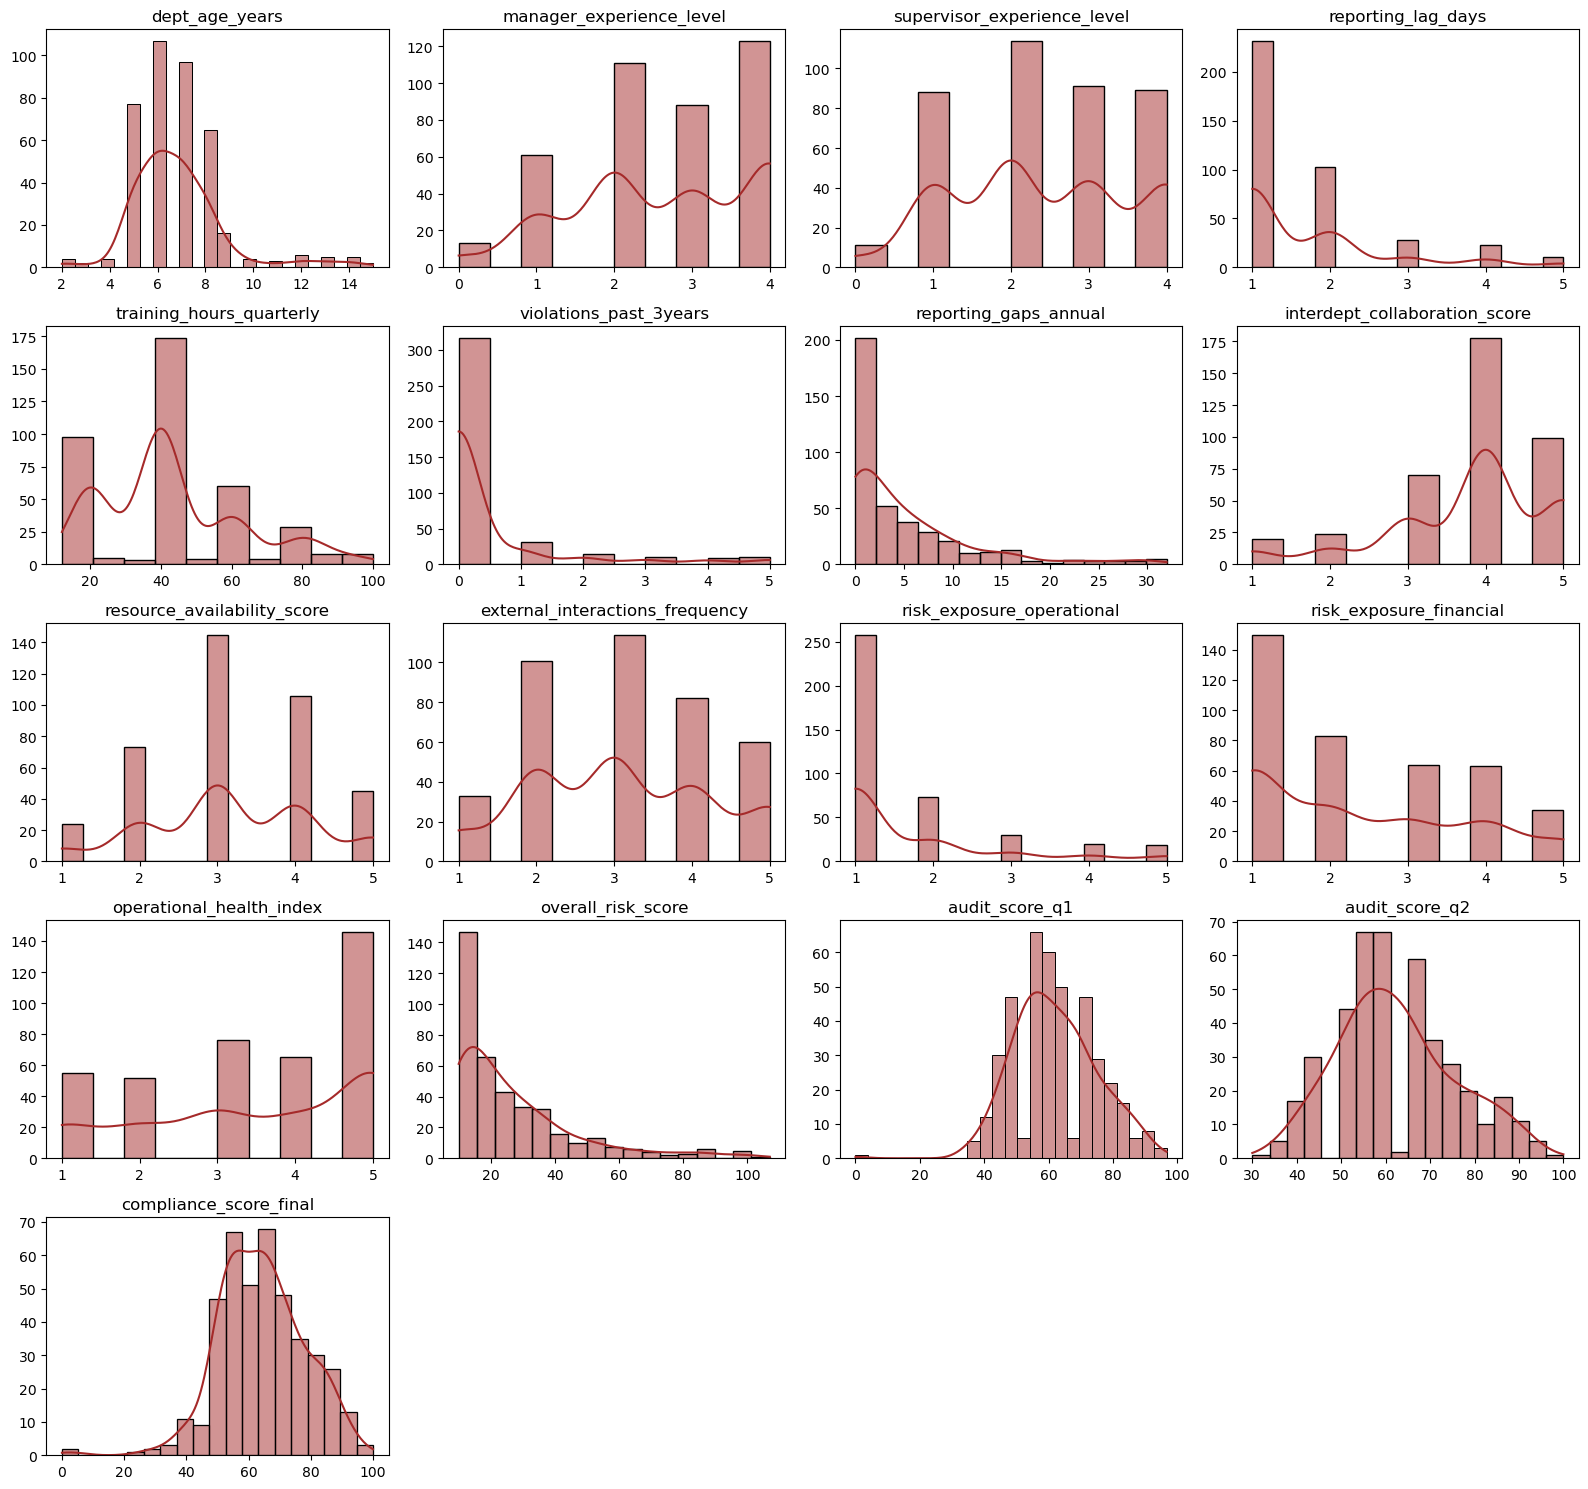

In [4451]:
n_cols = 4  # number of plots per row
n_rows = math.ceil(len(numerical_cols) / n_cols)

plt.figure(figsize=(4 * n_cols, 3 * n_rows))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(departments[col].dropna(), kde=True, color='brown')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

---
There exist a few clear outliers:
- In audit_score_q1 a few observations are equal to 0 which is almost impossible -> these should be set to NaN.
- There is overall_risk_score > 100, which is very unlikely, so these should be also set to NaN.
- In the compliance_score_final, compliance for some observations was very close to 0, however, lies within the appropriate range [0,100]. Therefore, we can't remove these values. But they will be clearly interesting for the later analysis as extremely non compliant, so we should flag them.

For scale variables there are no continueous values.

However, before we set outliers to NaN we should first explore these variables closer to prove the point.

---

**audit_score_q1**

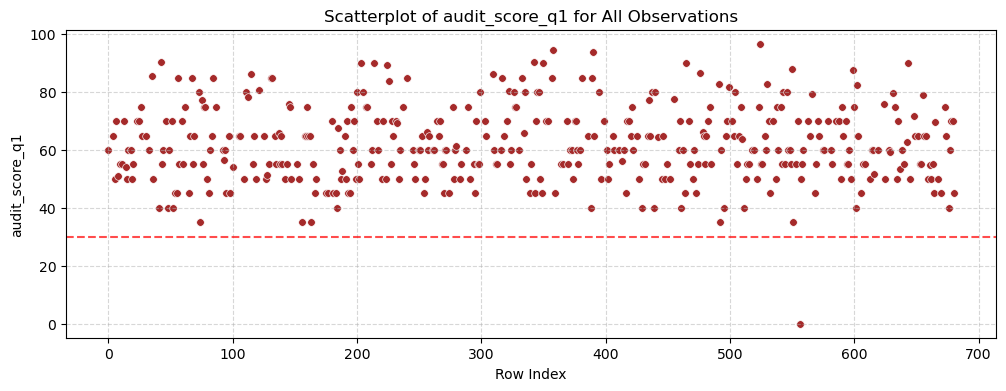

In [4454]:
# Scatterplot of audit_score_q1
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index, 
    y=departments['audit_score_q1'], 
    color='brown',
    s=30  # marker size
)

plt.xlabel("Row Index")
plt.ylabel("audit_score_q1")
plt.title("Scatterplot of audit_score_q1 for All Observations")
plt.axhline(30, color='red', linestyle='--', alpha=0.7)  # reference line at 0
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Outlier confirmed and is clearly <30. We set it to NaN.

---

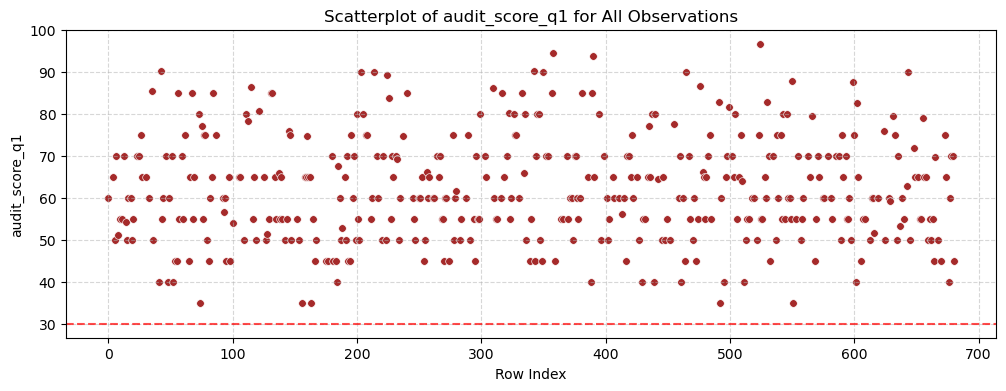

In [4456]:
outlier_mask = departments['audit_score_q1'] < 30

departments.loc[outlier_mask, 'audit_score_q1'] = np.nan

# controll check 
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index, 
    y=departments['audit_score_q1'], 
    color='brown',
    s=30  # marker size
)

plt.xlabel("Row Index")
plt.ylabel("audit_score_q1")
plt.title("Scatterplot of audit_score_q1 for All Observations")
plt.axhline(30, color='red', linestyle='--', alpha=0.7)  # reference line at 0
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**overall_risk_score**

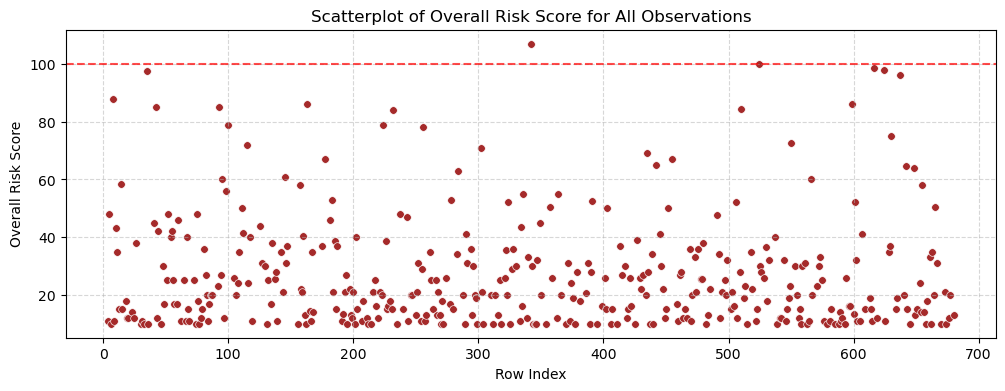

In [4459]:
# Scatterplot of overall_risk_score
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index, 
    y=departments['overall_risk_score'], 
    color='brown',
    s=30  # marker size
)

plt.xlabel("Row Index")
plt.ylabel("Overall Risk Score")
plt.title("Scatterplot of Overall Risk Score for All Observations")
plt.axhline(100, color='red', linestyle='--', alpha=0.7)  # reference line at 0
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Outlier confirmed and is clearly > 100. We set it to NaN.

---

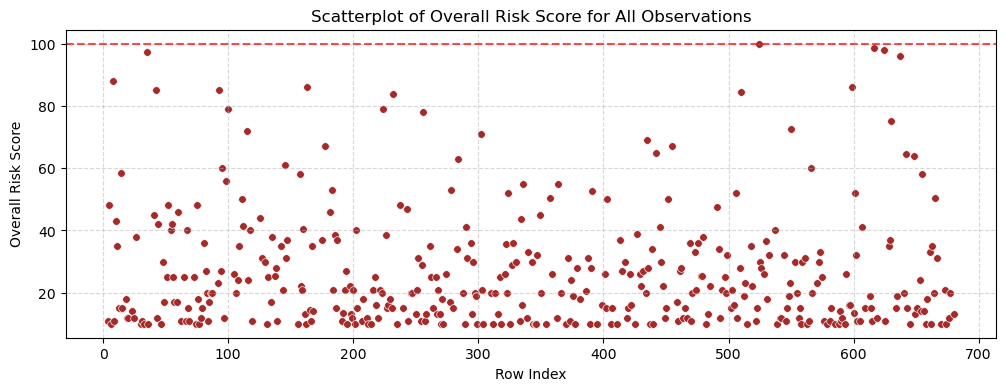

In [4464]:
# Set extreme high values (>100) to NaN for overall_risk_score
departments.loc[departments['overall_risk_score'] > 100, 'overall_risk_score'] = np.nan
# controll check
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index, 
    y=departments['overall_risk_score'], 
    color='brown',
    s=30  # marker size
)

plt.xlabel("Row Index")
plt.ylabel("Overall Risk Score")
plt.title("Scatterplot of Overall Risk Score for All Observations")
plt.axhline(100, color='red', linestyle='--', alpha=0.7)  # reference line at 0
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**compliance_score_final**

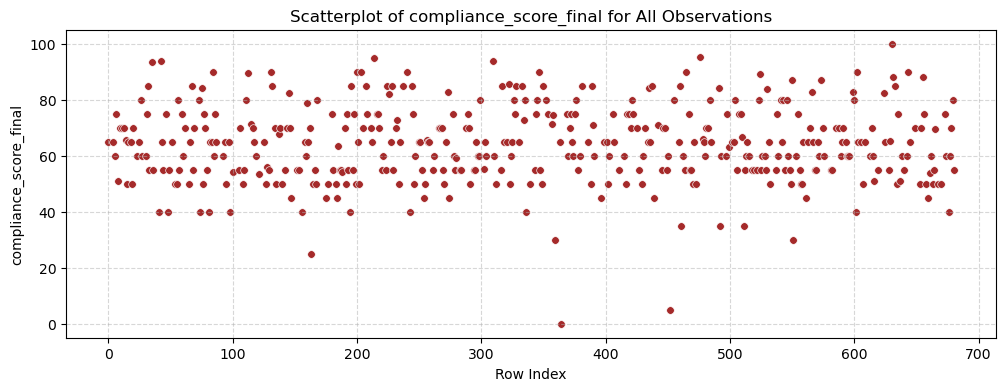

In [4467]:
# Scatterplot of overall_risk_score
plt.figure(figsize=(12, 4))
sns.scatterplot(
    x=departments.index, 
    y=departments['compliance_score_final'], 
    color='brown',
    s=30  # marker size
)

plt.xlabel("Row Index")
plt.ylabel("compliance_score_final")
plt.title("Scatterplot of compliance_score_final for All Observations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Two values are clearly smaller than 20. We flag them.

---

In [4470]:
# Flag extremely low compliance (<=20)
departments['extreme_non_compliance'] = (departments['compliance_score_final'] <= 20).astype(int)

#### **Boolean variables**

For boolean variables, twe check for continious variables.

---

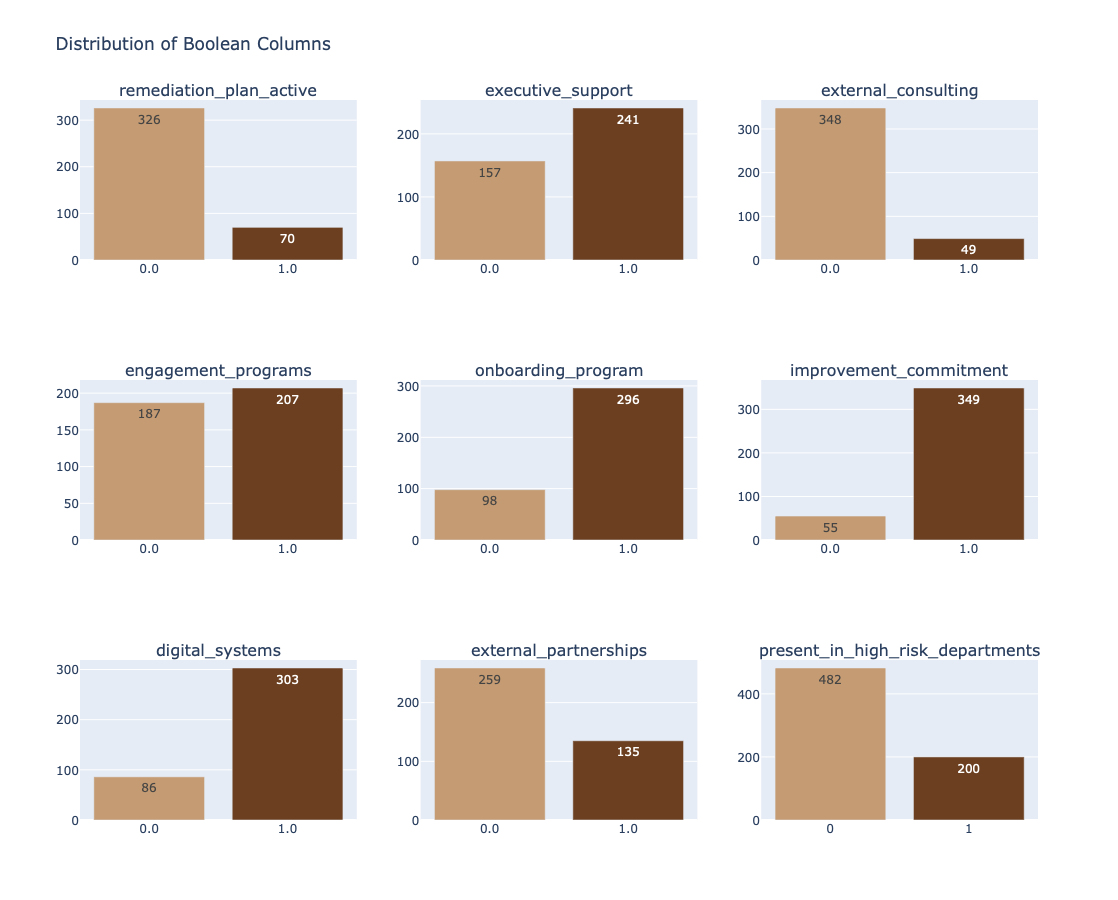

In [4474]:
# List of boolean columns
bool_cols_for_outliers = [col for col in boolean_cols]

# Create subplots
from plotly.subplots import make_subplots

rows = (len(bool_cols_for_outliers) + 2) // 3  # 3 plots per row
fig = make_subplots(rows=rows, cols=3, subplot_titles=bool_cols_for_outliers)

for i, col in enumerate(bool_cols_for_outliers):
    row = i // 3 + 1
    col_pos = i % 3 + 1
    
    counts = departments[col].value_counts().sort_index()
    fig.add_trace(
        go.Bar(
            x=counts.index.astype(str),
            y=counts.values,
            marker_color=["#c49b72", "#6b3f1f"],  # soft brown palette
            text=counts.values,
            textposition="auto"
        ),
        row=row,
        col=col_pos
    )

fig.update_layout(
    height=300*rows,  # adjust height depending on rows
    width=1000,
    title_text="Distribution of Boolean Columns",
    showlegend=False
)
fig.show()

---
For boolean variables there are no continueous values.

---

#### **Categorical columns**

For categorical variables, we check frequence outliers.

---

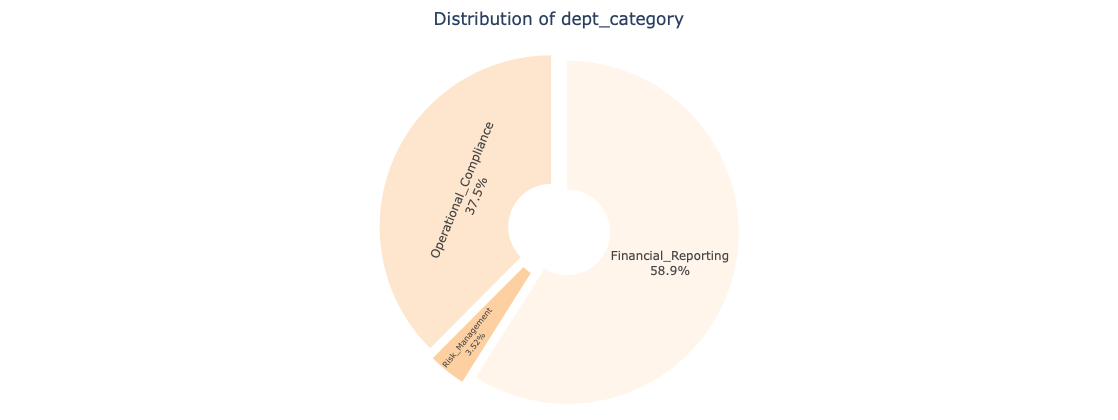

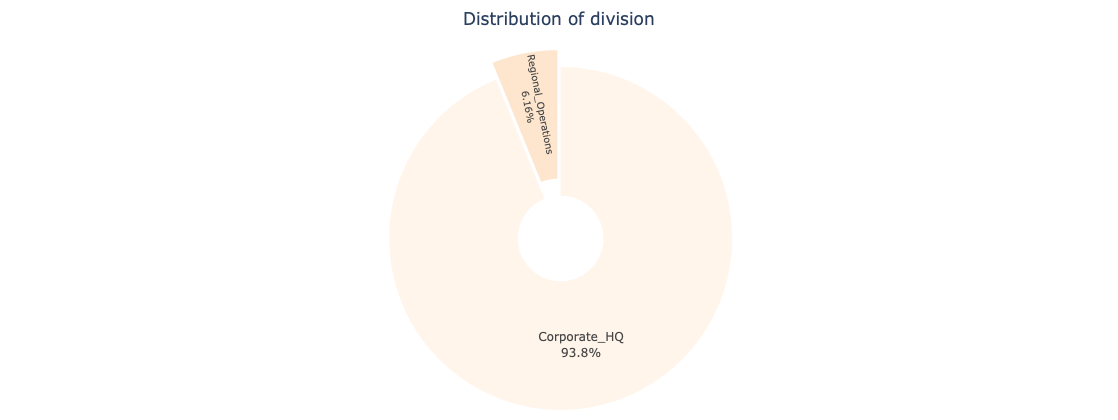

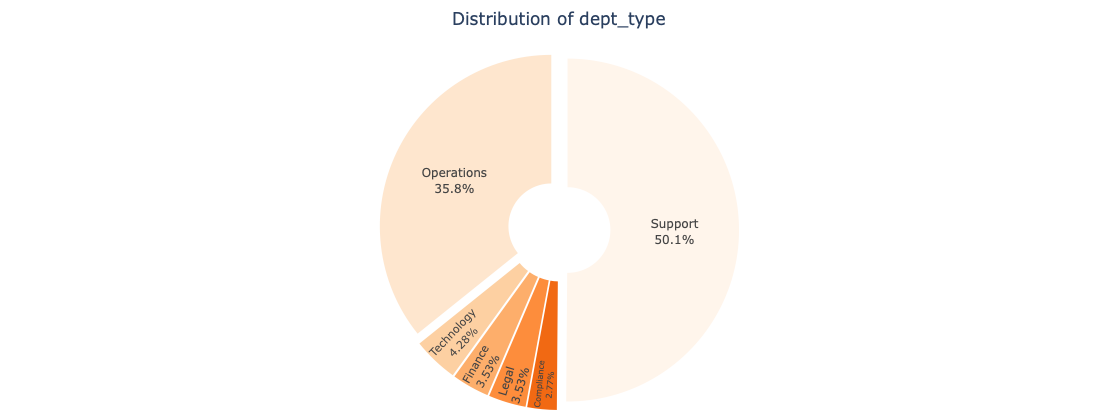

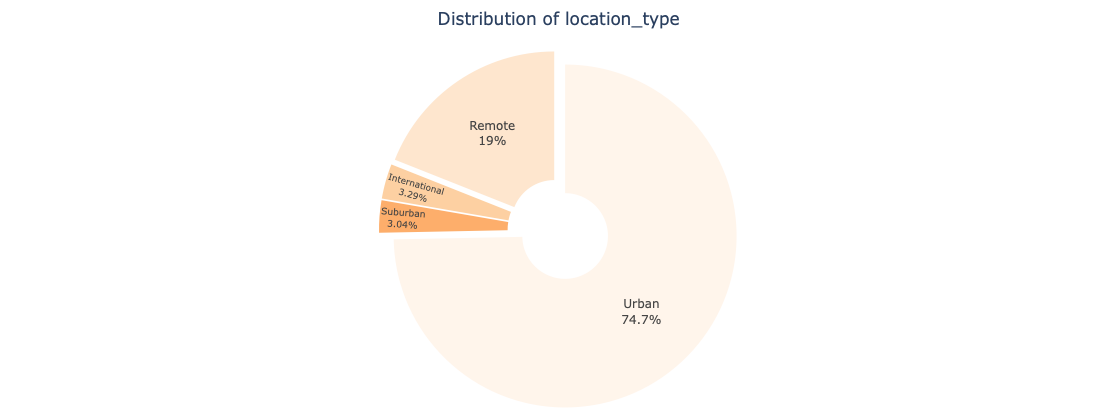

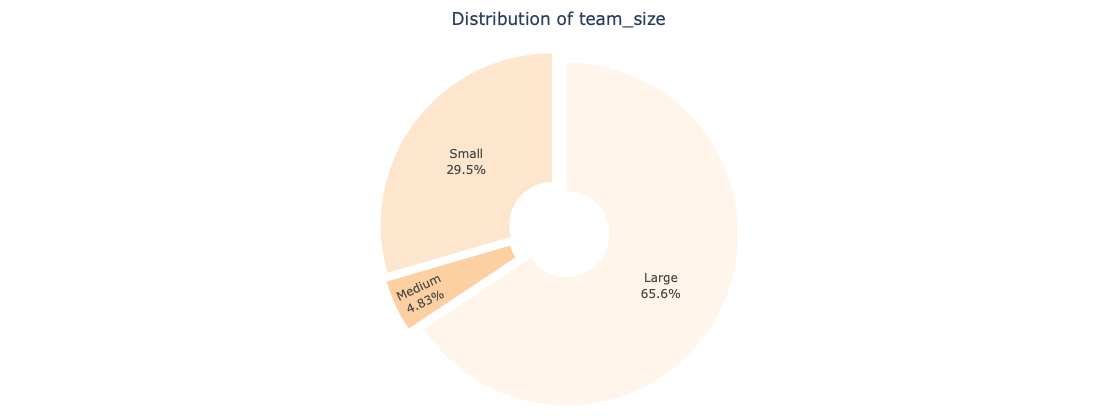

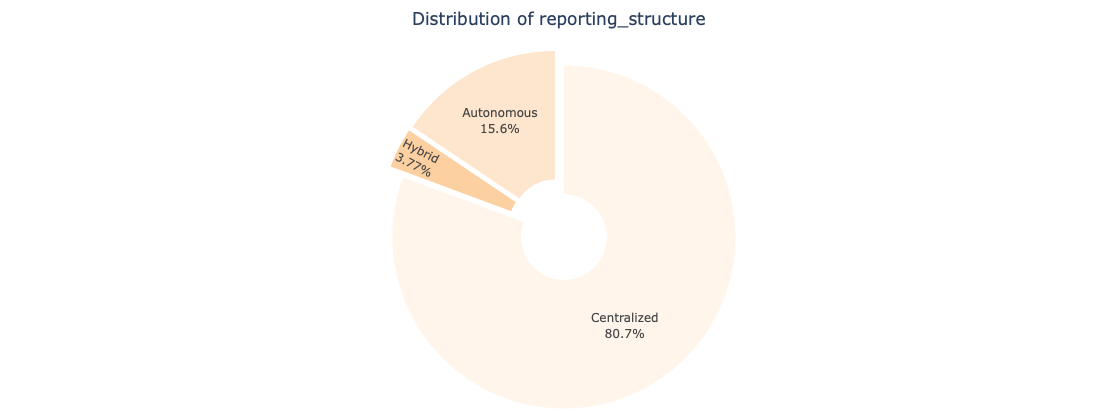

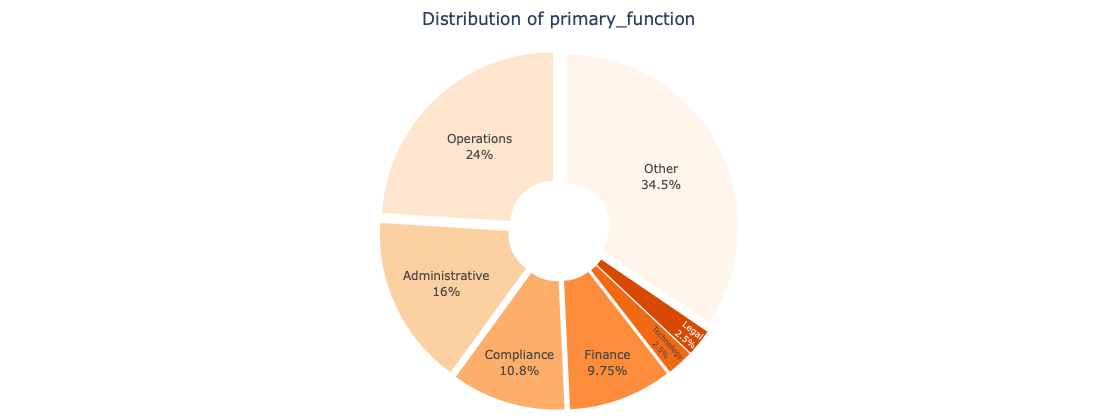

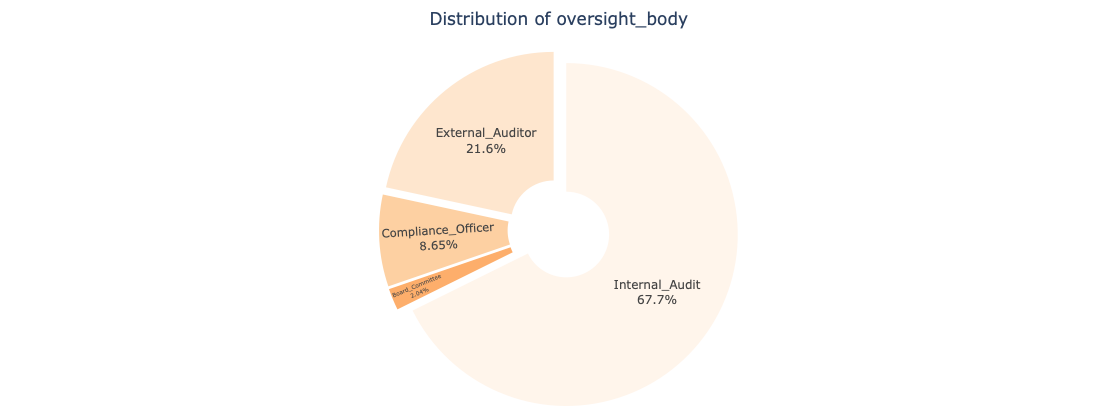

In [4479]:
# Exclude dept_id
categorical_cols_no_id = [c for c in categorical_cols if c != "dept_id"]

for col in categorical_cols_no_id:
    value_counts = departments[col].value_counts().reset_index()
    value_counts.columns = [col, "count"]

    fig = px.pie(
        value_counts,
        names=col,
        values="count",
        title=f"Distribution of {col}",
        color_discrete_sequence=px.colors.sequential.Oranges  # warm + elegant
    )
    
    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',
        hole=0.25,  # makes it a donut chart → more modern
        pull=[0.05] * len(value_counts)  # gentle "explosion" for aesthetics
    )

    fig.update_layout(
        title_x=0.5,
        width=420,
        height=420,
        showlegend=False,
        margin=dict(l=10, r=10, t=50, b=10),
    )

    fig.show()

---
Even the smallest categories are not small enough to combine them with some other categories so we don't modify anything at this stage.

---

### **Summary statistics**

In [4482]:
# Summary statistics for numerical_col
distribution_summary = departments[numerical_cols].describe().T  # transpose for readability

distribution_summary = distribution_summary.round(2)
distribution_summary

count   mean    std   min   25%   50%   75%  \
dept_age_years                   397.0   6.83   1.94   2.0   6.0   7.0   8.0   
manager_experience_level         396.0   2.62   1.17   0.0   2.0   3.0   4.0   
supervisor_experience_level      393.0   2.40   1.15   0.0   1.0   2.0   3.0   
reporting_lag_days               397.0   1.69   1.02   1.0   1.0   1.0   2.0   
training_hours_quarterly         393.0  43.26  19.79  12.0  21.0  40.0  60.0   
violations_past_3years           392.0   0.45   1.13   0.0   0.0   0.0   0.0   
reporting_gaps_annual            398.0   5.14   6.56   0.0   0.0   2.0   8.0   
interdept_collaboration_score    391.0   3.80   1.05   1.0   3.0   4.0   5.0   
resource_availability_score      393.0   3.19   1.06   1.0   3.0   3.0   4.0   
external_interactions_frequency  390.0   3.09   1.19   1.0   2.0   3.0   4.0   
risk_exposure_operational        399.0   1.66   1.10   1.0   1.0   1.0   2.0   
risk_exposure_financial          394.0   2.36   1.35   1.0   1.0   2.0   3.0   
operational_health_index         394.0   3.49   1.45   1.0   2.0   4.0   5.0   
overall_risk_score               393.0  26.69  18.91  10.0  12.0  20.0  34.0   
audit_score_q1                   413.0  62.10  12.63  35.0  55.0  60.0  70.0   
audit_score_q2                   420.0  62.36  13.35  30.0  55.0  60.0  70.0   
compliance_score_final           416.0  64.11  13.74   0.0  55.0  65.0  75.0   

                                   max  
dept_age_years                    15.0  
manager_experience_level           4.0  
supervisor_experience_level        4.0  
reporting_lag_days                 5.0  
training_hours_quarterly         100.0  
violations_past_3years             5.0  
reporting_gaps_annual             32.0  
interdept_collaboration_score      5.0  
resource_availability_score        5.0  
external_interactions_frequency    5.0  
risk_exposure_operational          5.0  
risk_exposure_financial            5.0  
operational_health_index           5.0  
overall_risk_score               100.0  
audit_score_q1                    96.7  
audit_score_q2                   100.0  
compliance_score_final           100.0

### **Logical Inconsistencies**

We have already checked in the Outliers check section that all values lay within the appropriate range. If they did not, we set them to NaN. Now we will check our dataset for the following logical inconsistency:
- Audit scores are absent, but compliance score exists.

---

In [4485]:
is_final_score_missing = departments['compliance_score_final'].isna()

# Audits are present (i.e., EITHER Q1 score is NOT NaN OR Q2 score is NOT NaN)
is_audit_present = departments['audit_score_q1'].notna() | departments['audit_score_q2'].notna()

inconsistent_scores = departments[is_final_score_missing & is_audit_present]

print("--- Cross-Column Validation Check ---")
print(f"Number of inconsistencies (Final Score Missing BUT Audit Data Present): {len(inconsistent_scores)}")

if len(inconsistent_scores) > 0:
    print("Inconsistent Dept IDs (First 5):")
    # Using .head() to only show the first few IDs
    print(inconsistent_scores['dept_id'].head().tolist())

--- Cross-Column Validation Check ---
Number of inconsistencies (Final Score Missing BUT Audit Data Present): 22
Inconsistent Dept IDs (First 5):
['DEPT-1133', 'DEPT-1752', 'DEPT-2279', 'DEPT-2792', 'DEPT-2995']


---
We will check if any of these ids are part of the high_risk_departments table, and if they are, we cannot drop them, otherwise we will drop these rows.

---

In [4488]:
# Check which inconsistent departments are considered high risk
inconsistent_scores_high_risk = inconsistent_scores[inconsistent_scores['present_in_high_risk_departments'] == 1]

print(f"Number of inconsistent departments flagged as high risk: {len(inconsistent_scores_high_risk)}")

if len(inconsistent_scores_high_risk) > 0:
    print("Dept IDs of inconsistent departments flagged as high risk:")
    display(inconsistent_scores_high_risk['dept_id'])
else:
    print("No inconsistent departments are flagged as high risk.")

Number of inconsistent departments flagged as high risk: 8
Dept IDs of inconsistent departments flagged as high risk:


10     DEPT-1133
52     DEPT-1752
93     DEPT-2279
157    DEPT-2995
342    DEPT-5329
377    DEPT-5849
535    DEPT-8087
648    DEPT-9653
Name: dept_id, dtype: object

---
Here we can see that we have 8 of these ID's which are added in the high_risk_departemnts table, so we will flag the 8 and drop the rest 14

---

In [4493]:
# Flag the 8 inconsistent departments that are in high_risk_departments
departments['audit_scores_missing'] = 0
departments.loc[inconsistent_scores_high_risk.index, 'audit_scores_missing'] = 1

# Drop the remaining inconsistent rows that are NOT in high_risk_departments
to_drop = inconsistent_scores.index.difference(inconsistent_scores_high_risk.index)
departments.drop(index=to_drop, inplace=True)

# Reset index
departments.reset_index(drop=True, inplace=True)

# Quick check
print(f"Remaining inconsistent rows: {(departments['compliance_score_final'].isna() & 
                                        (departments['audit_score_q1'].notna() | 
                                         departments['audit_score_q2'].notna())).sum()}")
print("Flagged audit_scores_missing:")
display(departments[departments['audit_scores_missing'] == 1]['dept_id'])

Remaining inconsistent rows: 8
Flagged audit_scores_missing:


10     DEPT-1133
52     DEPT-1752
93     DEPT-2279
156    DEPT-2995
337    DEPT-5329
371    DEPT-5849
524    DEPT-8087
635    DEPT-9653
Name: dept_id, dtype: object

### **Missing Values**

#### **Overview**

In [4497]:
# Count missing values per column
missing_counts = departments.isnull().sum()
missing_percent = (missing_counts / len(departments) * 100).round(2)

missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
}).sort_values(by='missing_percent', ascending=False)

display(missing_summary)

missing_count  missing_percent
external_interactions_frequency             292            43.71
digital_systems                             291            43.56
interdept_collaboration_score               290            43.41
overall_risk_score                          289            43.26
oversight_body                              288            43.11
resource_availability_score                 288            43.11
violations_past_3years                      288            43.11
engagement_programs                         288            43.11
onboarding_program                          287            42.96
operational_health_index                    287            42.96
risk_exposure_financial                     287            42.96
external_partnerships                       287            42.96
training_hours_quarterly                    287            42.96
supervisor_experience_level                 287            42.96
team_size                                   286            42.81
location_type                               285            42.66
external_consulting                         285            42.66
remediation_plan_active                     285            42.66
manager_experience_level                    284            42.51
reporting_lag_days                          284            42.51
dept_type                                   284            42.51
reporting_gaps_annual                       284            42.51
executive_support                           283            42.37
dept_age_years                              283            42.37
reporting_structure                         283            42.37
risk_exposure_operational                   281            42.07
primary_function                            279            41.77
improvement_commitment                      276            41.32
audit_score_q1                              269            40.27
audit_score_q2                              261            39.07
compliance_score_final                      252            37.72
division                                    244            36.53
extreme_non_compliance                        0             0.00
present_in_high_risk_departments              0             0.00
dept_id                                       0             0.00
dept_category                                 0             0.00
audit_scores_missing                          0             0.00

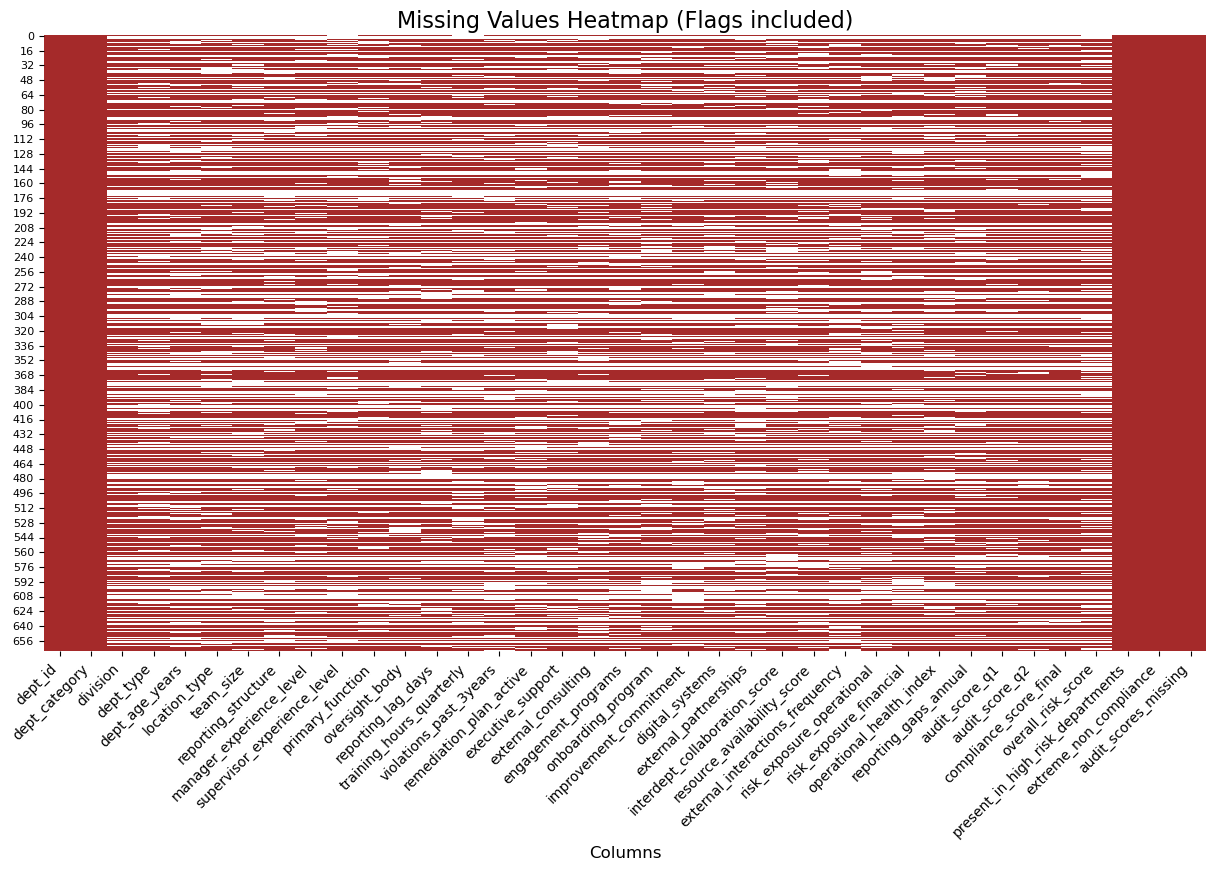

In [4499]:
plt.figure(figsize=(15,8))

sns.heatmap(
    departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap (Flags included)', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

---
In `departments` there is substantial missing data in the dataset (around 36–43% per column).

However, our key categorical identifier variables — dept_id, and dept_category — contain no missing values.

Because these columns are complete, we can reliably group the dataset by these identifiers to examine whether the missingness in other variables is associated with specific departments or department categories to see if missing data is random or systematically related to certain groups of observations.

---

#### **Missingness by dept_category**

In [4502]:
#columns to exclude
analytic_cols = departments.columns.difference(['dept_id', 'dept_category', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing' ])

missing_by_category = departments.groupby('dept_category')[analytic_cols].apply(
    lambda x: x.isnull().sum(),
    include_groups=False
)
display(missing_by_category)

grouped = departments.groupby('dept_category', dropna=False)
total_cells = grouped.size() * departments.shape[1]
missing_cells = grouped[analytic_cols].apply(lambda g: g.isna().sum().sum(), include_groups=False)
missing_rate = (missing_cells / total_cells) * 100

print("--- Overall Data Integrity Rate by Category ---")
print(missing_rate.round(2))

audit_score_q1  audit_score_q2  \
dept_category                                            
Financial_Reporting                 21              15   
Operational_Compliance             246             244   
Risk_Management                      2               2   

                        compliance_score_final  dept_age_years  dept_type  \
dept_category                                                               
Financial_Reporting                          3              34         35   
Operational_Compliance                     245             244        245   
Risk_Management                              4               5          4   

                        digital_systems  division  engagement_programs  \
dept_category                                                            
Financial_Reporting                  41         0                   40   
Operational_Compliance              245       244                  247   
Risk_Management                       5         0                    1   

                        executive_support  external_consulting  \
dept_category                                                    
Financial_Reporting                    38                   39   
Operational_Compliance                244                  244   
Risk_Management                         1                    2   

                        external_interactions_frequency  \
dept_category                                             
Financial_Reporting                                  47   
Operational_Compliance                              244   
Risk_Management                                       1   

                        external_partnerships  improvement_commitment  \
dept_category                                                           
Financial_Reporting                        38                      32   
Operational_Compliance                    247                     244   
Risk_Management                             2                       0   

                        interdept_collaboration_score  location_type  \
dept_category                                                          
Financial_Reporting                                42             35   
Operational_Compliance                            245            245   
Risk_Management                                     3              5   

                        manager_experience_level  onboarding_program  \
dept_category                                                          
Financial_Reporting                           37                  42   
Operational_Compliance                       245                 245   
Risk_Management                                2                   0   

                        operational_health_index  overall_risk_score  \
dept_category                                                          
Financial_Reporting                           40                  40   
Operational_Compliance                       246                 244   
Risk_Management                                1                   5   

                        oversight_body  primary_function  \
dept_category                                              
Financial_Reporting                 41                30   
Operational_Compliance             244               246   
Risk_Management                      3                 3   

                        remediation_plan_active  reporting_gaps_annual  \
dept_category                                                            
Financial_Reporting                          39                     37   
Operational_Compliance                      244                    245   
Risk_Management                               2                      2   

                        reporting_lag_days  reporting_structure  \
dept_category                                                     
Financial_Reporting                     39                   37   
Operational_Compliance     

--- Overall Data Integrity Rate by Category ---
dept_category
Financial_Reporting        7.74
Operational_Compliance    82.74
Risk_Management            8.56
dtype: float64


---
**Here we see a pattern:** most data is missing for 'Operational_Compliance'. Then data is almost equally missing for 'Financial_Reporting' and 'Risk_Management' category. These are the categories of rules that departments have to deal with. Therefore, when departments deal with 'Operational_Compliance' rules, the data becomes missing. Why? What is the correlation between the data being missing and this type of rules?

We will find the answer later in the next section.

---

#### **Missingness by division**

'division' has the least percent of missing values (37%) out of all columns with missing values, therefore, we can check the missingness by division too.

---

In [4508]:
# Columns to exclude
analytic_cols = departments.columns.difference(['dept_id', 'dept_category', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing' ])

missing_by_division = departments.groupby('division')[analytic_cols].apply(lambda x: x.isna().sum())
display(missing_by_division)
grouped_data = departments.groupby('division', dropna=False)
total_cells_per_division = grouped_data.size() * len(analytic_cols)
total_missing_per_division = grouped_data[analytic_cols].apply(lambda x: x.isna().sum().sum())

# Missing rate per division (%)
overall_missing_rate = (total_missing_per_division / total_cells_per_division) * 100

print("--- Overall Data Integrity Rate by Division  ---")
final_rates = overall_missing_rate.round(2)
display(final_rates)

audit_score_q1  audit_score_q2  compliance_score_final  \
division                                                                      
Corporate_HQ                     22              14                       6   
Regional_Operations               3               3                       2   

                     dept_age_years  dept_type  digital_systems  division  \
division                                                                    
Corporate_HQ                     35         36               43         0   
Regional_Operations               4          4                4         0   

                     engagement_programs  executive_support  \
division                                                      
Corporate_HQ                          43                 39   
Regional_Operations                    1                  0   

                     external_consulting  external_interactions_frequency  \
division                                                                    
Corporate_HQ                          39                               46   
Regional_Operations                    2                                2   

                     external_partnerships  improvement_commitment  \
division                                                             
Corporate_HQ                            42                      30   
Regional_Operations                      1                       2   

                     interdept_collaboration_score  location_type  \
division                                                            
Corporate_HQ                                    43             36   
Regional_Operations                              3              5   

                     manager_experience_level  onboarding_program  \
division                                                            
Corporate_HQ                               39                  42   
Regional_Operations                         1                   1   

                     operational_health_index  overall_risk_score  \
division                                                            
Corporate_HQ                               42                  41   
Regional_Operations                         1                   4   

                     oversight_body  primary_function  \
division                                                
Corporate_HQ                     42                29   
Regional_Operations               2                 6   

                     remediation_plan_active  reporting_gaps_annual  \
division                                                              
Corporate_HQ                              39                     36   
Regional_Operations                        2                      4   

                     reporting_lag_days  reporting_structure  \
division                                                       
Corporate_HQ                         39                   35   
Regional_Operations                   1                    4   

                     resource_availability_score  risk_exposure_financial  \
division                                                                    
Corporate_HQ                                  41                       38   
Regional_Operations                            3                        5   

                     risk_exposure_operational  supervisor_experience_level  \
division                                                                      
Corporate_HQ                                34                           41   
Regional_Operations                          3                            2   

                     team_size  training_hours_quarterly  \
division                                                   
Corporate_HQ                40                        41   
Regional_Operations          2                         2   

                     violations_past_3years  
division                             

--- Overall Data Integrity Rate by Division  ---


division
Corporate_HQ             8.90
Regional_Operations      9.86
NaN                    100.00
dtype: float64

---
Here we see another pattern: 'Corporate_HQ' division, according to the first table, misses far more values than Regional_Operations. However, it is an illusion arising from the fact that a lot of departments (428) belong to the Corpoprate_HQ and only 27 departments belong to the Regional Operations division (from divisions table). In fact, the percentage of missing values in these two divisions is almost the same (around 9%).

What's more interesting, the missing division information (NaN) has an extremely high percent of missing data (100%). This is the strong proof that if the division information is missing -> everything else (exept for the 'dept_id', 'dept_category') is missing. Therefore, these rows, where division is missing, are useless:
- non-usable for modeling
- non-recoverable (too much missing data)

Therefore, we shoul drop them. But before, we want to find out another interesting detail: do all missing rows belong to the Operational_Compliance category?

---

In [4511]:
# Rows where division is missing
missing_division_rows = departments[departments['division'].isna()]

total_missing_division = missing_division_rows.shape[0]

# Number of rows with missing division that belong to Operational_Compliance
missing_div_opcompliance = (missing_division_rows['dept_category'] == 'Operational_Compliance').sum()

print(f"Total rows with missing division: {total_missing_division}")
print(f"Rows with missing division and category 'Operational_Compliance': {missing_div_opcompliance}")

Total rows with missing division: 244
Rows with missing division and category 'Operational_Compliance': 244


---
The hypothesis is confirmed: there is a perfect overlap: **missing division -> missing data -> Operational_Compliance** category.

But are there any departments which deal with Operational_Compliance rules which actually submitted their data?

---

In [4514]:
# Exclude the constant columns
exclude_cols = ['dept_id', 'dept_category', 'division']
analytic_cols = departments.columns.difference(exclude_cols)

# Mask for Operational_Compliance category
mask_op_compliance = departments['dept_category'] == 'Operational_Compliance'

# Check rows with AT LEAST ONE non-missing value in analytical columns
op_compliance_not_missing = departments.loc[mask_op_compliance, analytic_cols].dropna(how='all')

print(f"Number of Operational_Compliance rows with at least some data: {op_compliance_not_missing.shape[0]}")

Number of Operational_Compliance rows with at least some data: 256


---
Yes, there are 12 such departments. So the question now is: Why did these 12 departments manage to submit their data while the others did not?

Unfortunately, we cannot answer this question with the current dataset. Even if we analyze these 12 departments, we cannot compare them to the departments with missing values, because all the analytical columns are missing for the others. Only the dept_id ispresent, but this does not provide any meaningful information for analysis.

We have the last thing to check before we drop these departments with missing values: Does any of them belong to the table 'high_risk_departments'? This is meaningful, because the table 'high_risk_departments' shows departments already marked as risky and if any of the departments that we are going to drop will appear in this table, we can lose an important detail in analysing what makes departments risky. Maybe lack of values makes departments risky - we don't know yet.

---

In [4517]:
# Select departments with missing division
missing_division_rows = departments[departments['division'].isna()]

# Find which of these departments are in high_risk_departments
matching_high_risk = high_risk_departments[
    high_risk_departments['dept_id'].isin(missing_division_rows['dept_id'])
]

# Display the departments as they are in the departments table
if not matching_high_risk.empty:
    print("Departments with missing division in the departments table:")
    display(missing_division_rows[
        missing_division_rows['dept_id'].isin(matching_high_risk['dept_id'])
    ])

    print("Same departments in the high_risk_departments table:")
    display(matching_high_risk)
else:
    print("No departments with missing division are in high_risk_departments.")

Departments with missing division in the departments table:


dept_id           dept_category division dept_type  dept_age_years  \
102  DEPT-2377  Operational_Compliance     None      None             NaN   
315  DEPT-5023  Operational_Compliance     None      None             NaN   

    location_type team_size reporting_structure  manager_experience_level  \
102          None      None                None                       NaN   
315          None      None                None                       NaN   

     supervisor_experience_level primary_function oversight_body  \
102                          NaN             None           None   
315                          NaN             None           None   

     reporting_lag_days  training_hours_quarterly  violations_past_3years  \
102                 NaN                       NaN                     NaN   
315                 NaN                       NaN                     NaN   

     remediation_plan_active  executive_support  external_consulting  \
102                      NaN                NaN                  NaN   
315                      NaN                NaN                  NaN   

     engagement_programs  onboarding_program  improvement_commitment  \
102                  NaN                 NaN                     NaN   
315                  NaN                 NaN                     NaN   

     digital_systems  external_partnerships  interdept_collaboration_score  \
102              NaN                    NaN                            NaN   
315              NaN                    NaN                            NaN   

     resource_availability_score  external_interactions_frequency  \
102                          NaN                              NaN   
315                          NaN                              NaN   

     risk_exposure_operational  risk_exposure_financial  \
102                        NaN                      NaN   
315                        NaN                      NaN   

     operational_health_index  reporting_gaps_annual  audit_score_q1  \
102                       NaN                    NaN             NaN   
315                       NaN                    NaN             NaN   

     audit_score_q2  compliance_score_final  overall_risk_score  \
102             NaN                     NaN                 NaN   
315             NaN                     NaN                 NaN   

     present_in_high_risk_departments  extreme_non_compliance  \
102                                 1                       0   
315                                 1                       0   

     audit_scores_missing  
102                     0  
315                     0

Same departments in the high_risk_departments table:


dept_id        dept_category      division dept_type  dept_age_years  \
50  DEPT-5023  Financial_Reporting  Corporate_HQ   Support             6.0   
58  DEPT-2377  Financial_Reporting  Corporate_HQ      None             NaN   

   location_type team_size reporting_structure  manager_experience_level  \
50         Urban     Large         Centralized                       1.0   
58         Urban     Small          Autonomous                       4.0   

    supervisor_experience_level primary_function    oversight_body  \
50                          1.0             None  External_Auditor   
58                          4.0       Compliance    Internal_Audit   

    reporting_lag_days  training_hours_quarterly  violations_past_3years  \
50                 4.0                      20.0                     0.0   
58                 1.0                      40.0                     NaN   

    remediation_plan_active  executive_support  external_consulting  \
50                      1.0                1.0                  0.0   
58                      NaN                1.0                  0.0   

    engagement_programs  onboarding_program  improvement_commitment  \
50                  NaN                 0.0                     1.0   
58                  0.0                 NaN                     1.0   

    digital_systems  external_partnerships  interdept_collaboration_score  \
50              1.0                    1.0                            5.0   
58              0.0                    0.0                            4.0   

    resource_availability_score  external_interactions_frequency  \
50                          5.0                              5.0   
58                          1.0                              3.0   

    risk_exposure_operational  risk_exposure_financial  \
50                        5.0                      5.0   
58                        3.0                      5.0   

    operational_health_index  reporting_gaps_annual  audit_score_q1  \
50                       5.0                    0.0            50.0   
58                       5.0                    6.0            45.0   

    audit_score_q2  compliance_score_final  overall_risk_score  
50            50.0                    80.0                50.0  
58            45.0                    50.0                43.0

---
This comparison provided us with a great insight:

We can drop the rows with missing division information AND even those present in the high_risk_departments. Why? Because of the following reasoning:

1. Do all departments with missing values appear in the high_risk_departments? - No. So having all missing values is not equal to being risky.
2. Do missing overall_risk_score AND compliance_score_final make a department risky? - No (from conclusion 1).
3. Did these departments appear as risky because of the manual imputation? - Yes. So we initially didn't know anything about these departments and we know that the full missing data does not make a department risky. Therefore, all values for these departments were imputed with values that MADE them risky -> they appear as risky by accident.
4. Therefore, we should drop all departments with missing division.

To make sure that data missingness is not correlated with risk, we check correlation between missing values and compliance or risk

---

#### **Correlation between missing values and compliance or risk**

---
> The last thing about missing values we need to find before moving on to handling them: Is there any correlation between the missing values and the compliance or risk? Because if there is, then something about the missing data can affect the compliance or risk and we want to know what before handling missing values. Perhaps the number of missing values negatively correlates with the compliance and positively correlates with risk.
> 
---

In [4522]:
# Fraction of missing values per row
row_missing_rate = departments[analytic_cols].isna().mean(axis=1)

compliance_col = 'compliance_score_final'
risk_col = 'overall_risk_score'

correlation_compliance = row_missing_rate.corr(departments[compliance_col])
correlation_risk = row_missing_rate.corr(departments[risk_col])

print(f"Correlation between missingness and compliance_score:final: {correlation_compliance:.3f}")
print(f"Correlation between missingness and overall_risk_score: {correlation_risk:.3f}")

Correlation between missingness and compliance_score:final: 0.035
Correlation between missingness and overall_risk_score: 0.019


---
Correlation with compliance (0.35) → very low, meaning the amount of missing data does not systematically affect compliance scores.


Correlation with risk (0.019) → essentially zero, so missing data is not predictive of risk either.

In other words, based on this dataset:

Departments with more missing values are not inherently riskier.
Missingness seems to be mostly structural (like Operational_Compliance departments not submitting data), not related to the outcome variables.

Therefore, we should drop all rows with missing divisio.

---

In [4525]:
# Identify department IDs with missing division
missing_div_dept_ids = departments.loc[departments['division'].isna(), 'dept_id']

# Drop from departments
departments = departments[~departments['dept_id'].isin(missing_div_dept_ids)].copy()

# Drop from high_risk_departments
high_risk_clean = high_risk_departments[
    ~high_risk_departments['dept_id'].isin(missing_div_dept_ids)
].copy()

print(f"Dropped {len(missing_div_dept_ids)} departments with missing division.")

Dropped 244 departments with missing division.


In [4527]:
departments.shape

(424, 37)

In [4529]:
high_risk_departments.shape

(200, 34)

#### **high_risk_departments** table 

---
So far we analysed missing values in the `departments` table. Now we can look at two other improtant tables: `high_risk_departments` and `risk_summary_by_departments`

---

In [4533]:
num_rows, num_columns = high_risk_departments.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")
high_risk_departments.head()

Number of rows: 200
Number of columns: 34


dept_id        dept_category      division   dept_type  dept_age_years  \
0  DEPT-1133  Financial_Reporting  Corporate_HQ  Compliance             8.0   
1  DEPT-4312  Financial_Reporting  Corporate_HQ  Operations             6.0   
2  DEPT-3347  Financial_Reporting  Corporate_HQ  Operations             6.0   
3  DEPT-2554  Financial_Reporting  Corporate_HQ     Support             5.0   
4  DEPT-3151  Financial_Reporting  Corporate_HQ        None             8.0   

  location_type team_size reporting_structure  manager_experience_level  \
0         Urban     Large         Centralized                       2.0   
1         Urban     Small         Centralized                       1.0   
2         Urban     Small         Centralized                       2.0   
3         Urban     Small          Autonomous                       3.0   
4         Urban     Small         Centralized                       3.0   

   supervisor_experience_level primary_function    oversight_body  \
0                          2.0            Other              None   
1                          NaN            Other    Internal_Audit   
2                          1.0   Administrative              None   
3                          3.0            Other    Internal_Audit   
4                          3.0       Operations  External_Auditor   

   reporting_lag_days  training_hours_quarterly  violations_past_3years  \
0                 1.0                      20.0                     1.0   
1                 2.0                      40.0                     0.0   
2                 1.0                      20.0                     1.0   
3                 1.0                      20.0                     0.0   
4                 1.0                      40.0                     0.0   

   remediation_plan_active  executive_support  external_consulting  \
0                      0.0                1.0                  0.0   
1                      0.0                1.0                  0.0   
2                      0.0                0.0                  0.0   
3                      NaN                0.0                  0.0   
4                      0.0                1.0                  0.0   

   engagement_programs  onboarding_program  improvement_commitment  \
0                  1.0                 0.0                     0.0   
1                  0.0                 1.0                     1.0   
2                  1.0                 1.0                     1.0   
3                  0.0                 1.0                     1.0   
4                  0.0                 1.0                     1.0   

   digital_systems  external_partnerships  interdept_collaboration_score  \
0              1.0                    1.0                            4.0   
1              1.0                    0.0                            3.0   
2              0.0                    1.0                            4.0   
3              1.0                    0.0                            NaN   
4              1.0                    NaN                            3.0   

   resource_availability_score  external_interactions_frequency  \
0                          4.0                              NaN   
1                          4.0                              2.0   
2                          4.0                              4.0   
3                          3.0                              4.0   
4                          2.0                              4.0   

   risk_exposure_operational  risk_exposure_financial  \
0                        2.0                      2.0   
1                        1.0                      1.0   
2                        3.0                      5.0   
3                        4.0                      4.0   
4                        NaN                      4.0   

   operational_health_index  reporting_gaps_annual  audit_score_q1  \
0                       1.0                   26.0             NaN   
1                       5.0 

In [4535]:
# Missing values per column
missing_high_risk = high_risk_departments.isna().sum()

# Missing percentage
missing_high_risk_percent = (missing_high_risk / high_risk_departments.shape[0]) * 100

# Create DataFrame
missing_df = pd.DataFrame({
    'missing_count': missing_high_risk, 
    'missing_percent': missing_high_risk_percent
}).sort_values('missing_percent', ascending=False)

display(missing_df)

missing_count  missing_percent
dept_age_years                              28             14.0
violations_past_3years                      28             14.0
oversight_body                              25             12.5
digital_systems                             23             11.5
team_size                                   22             11.0
external_interactions_frequency             22             11.0
onboarding_program                          22             11.0
training_hours_quarterly                    21             10.5
dept_type                                   21             10.5
location_type                               21             10.5
manager_experience_level                    21             10.5
interdept_collaboration_score               21             10.5
engagement_programs                         20             10.0
overall_risk_score                          20             10.0
reporting_lag_days                          20             10.0
reporting_structure                         20             10.0
remediation_plan_active                     19              9.5
supervisor_experience_level                 19              9.5
risk_exposure_operational                   18              9.0
operational_health_index                    18              9.0
executive_support                           17              8.5
risk_exposure_financial                     17              8.5
resource_availability_score                 16              8.0
external_consulting                         16              8.0
primary_function                            16              8.0
external_partnerships                       15              7.5
reporting_gaps_annual                       14              7.0
improvement_commitment                      12              6.0
audit_score_q1                              11              5.5
audit_score_q2                               8              4.0
compliance_score_final                       7              3.5
dept_category                                0              0.0
division                                     0              0.0
dept_id                                      0              0.0

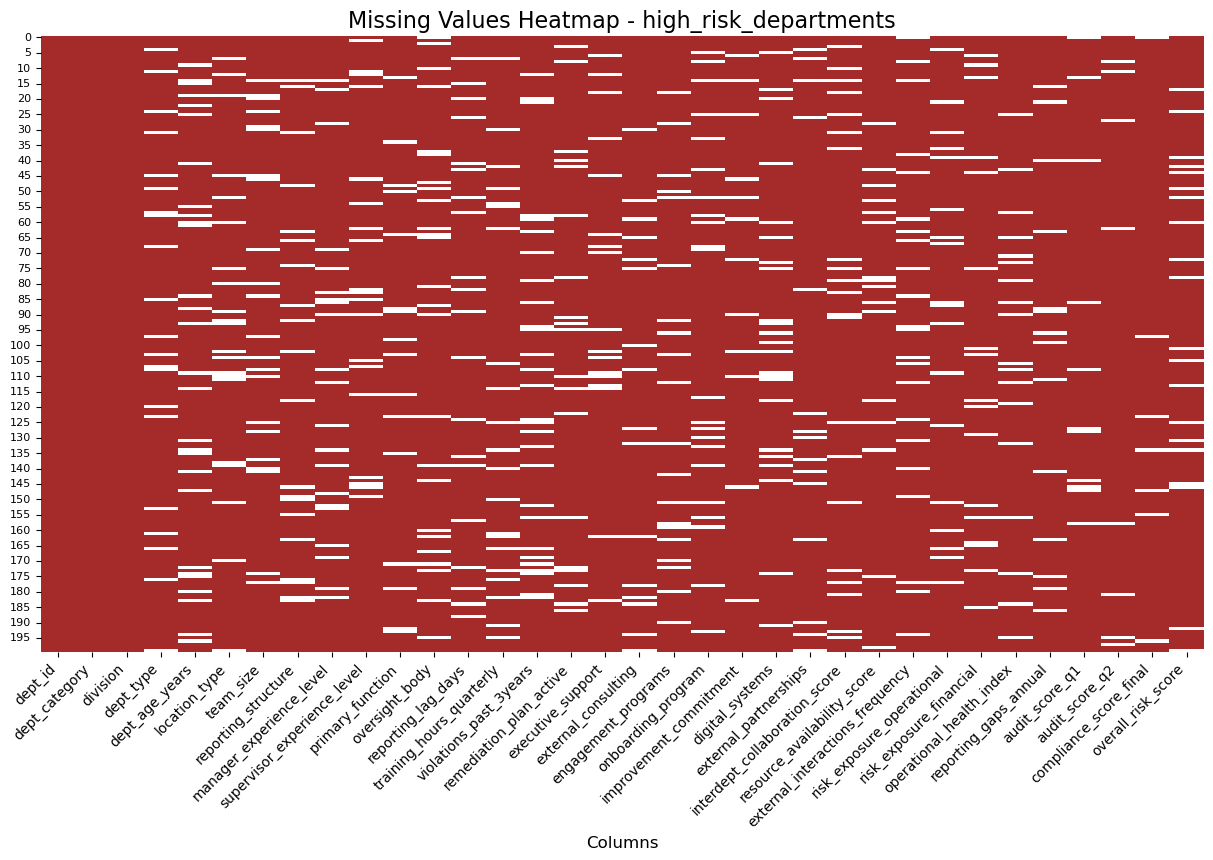

In [4537]:
plt.figure(figsize=(15, 8))
sns.heatmap(
    high_risk_departments.isnull(), 
    cbar=False, 
    cmap=sns.color_palette(["brown", "white"])
)
plt.title(f'Missing Values Heatmap - high_risk_departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

---
This table was already cleaned, there is much less missing data (around 10-14%). 

---

### **Handling missing data**

Now we are going to compare two potential imputation procedures:

**Procedure 1**: We impute missing values in departments table with those present in high_risk_departments table. Other missing values we impute with median (numerical) and mode (categorical + boolean). The same method we apply to the high_risk_departments. Compare how similar the rows in high_risk_departments are to those in departments.

**Procedure 2**: We impute missing values with median (numerical) and mode (categorical + boolean) in both tables and compare how similar the rows in high_risk_departments are to those in departments.

To compare Procedures:

1. Compute statistics from the risk_summary_by_division table for both methods and see which keeps the original data patterns.
2. Look at numerical values distribution. Compare with the original table. Adopt the procedure that better keeps original data patterns.


---

In [4542]:
# creating copies of departments and high_risk_departments tables
departments_copy_for_missing_imputation_1 = departments.copy()
high_risk_copy_for_missing_imputation_1 = high_risk_departments.copy()
departments_copy_for_missing_imputation_2 = departments.copy()
high_risk_copy_for_missing_imputation_2 = high_risk_departments.copy()

In [4544]:
# Columns to exclude from imputation
exclude_cols = ['dept_id', 'present_in_high_risk_departments', 'extreme_non_compliance', 'audit_scores_missing']

# Identify numerical and categorical columns
numerical_cols_copy = [c for c in numerical_cols if c not in exclude_cols] + bool_cols
categorical_cols_copy = [c for c in categorical_cols if c not in exclude_cols + ['dept_id']]

In [4546]:
# -----------------------------
# Procedure 1: Impute using high-risk reference
# -----------------------------

# Step 1: Impute departments_copy_for_missing_imputation_1 from high_risk_copy_for_missing_imputation_1
for idx, row in departments_copy_for_missing_imputation_1.iterrows():
    dept_id = row['dept_id']
    if dept_id in high_risk_copy_for_missing_imputation_1['dept_id'].values:
        hr_row = high_risk_copy_for_missing_imputation_1.loc[
            high_risk_copy_for_missing_imputation_1['dept_id'] == dept_id
        ].iloc[0]
        for col in numerical_cols_copy + categorical_cols_copy:
            if pd.isna(row[col]) and not pd.isna(hr_row[col]):
                departments_copy_for_missing_imputation_1.loc[idx, col] = hr_row[col]  # use .loc

# Step 2: Fill remaining missing values with median/mode
# Numerical → median
for col in numerical_cols_copy:
    median_val = departments_copy_for_missing_imputation_1[col].median()
    departments_copy_for_missing_imputation_1[col] = departments_copy_for_missing_imputation_1[col].fillna(median_val)
    high_risk_copy_for_missing_imputation_1[col] = high_risk_copy_for_missing_imputation_1[col].fillna(median_val)

# Categorical/Boolean → mode
for col in categorical_cols_copy:
    mode_val = departments_copy_for_missing_imputation_1[col].mode()[0]
    departments_copy_for_missing_imputation_1[col] = departments_copy_for_missing_imputation_1[col].fillna(mode_val)
    high_risk_copy_for_missing_imputation_1[col] = high_risk_copy_for_missing_imputation_1[col].fillna(mode_val)

# -----------------------------
# Step 3: Compare similarity
# -----------------------------
def row_similarity(row1, row2, cols):
    matches = sum(row1[c] == row2[c] for c in cols)
    return matches / len(cols) * 100

similarities = []
for idx, hr_row in high_risk_copy_for_missing_imputation_1.iterrows():
    dept_id = hr_row['dept_id']
    if dept_id in departments_copy_for_missing_imputation_1['dept_id'].values:
        dep_row = departments_copy_for_missing_imputation_1.loc[
            departments_copy_for_missing_imputation_1['dept_id'] == dept_id
        ].iloc[0]
        sim = row_similarity(hr_row, dep_row, numerical_cols_copy + categorical_cols_copy)
        similarities.append({'dept_id': dept_id, 'similarity_percent': sim})

similarity_df_1 = pd.DataFrame(similarities).sort_values(by='similarity_percent', ascending=False)
display(similarity_df_1)

dept_id  similarity_percent
0    DEPT-1133          100.000000
97   DEPT-1856          100.000000
124  DEPT-2368          100.000000
125  DEPT-8361          100.000000
126  DEPT-4235          100.000000
127  DEPT-1588          100.000000
129  DEPT-5544          100.000000
130  DEPT-8325          100.000000
131  DEPT-2037          100.000000
132  DEPT-8087          100.000000
133  DEPT-4401          100.000000
134  DEPT-3553          100.000000
135  DEPT-2040          100.000000
136  DEPT-2047          100.000000
137  DEPT-8168          100.000000
138  DEPT-2477          100.000000
139  DEPT-3887          100.000000
140  DEPT-9840          100.000000
141  DEPT-4342          100.000000
142  DEPT-7142          100.000000
143  DEPT-5851          100.000000
144  DEPT-4485          100.000000
145  DEPT-2995          100.000000
123  DEPT-4019          100.000000
122  DEPT-4928          100.000000
121  DEPT-1752          100.000000
109  DEPT-2507          100.000000
1    DEPT-4312          100.000000
101  DEPT-3258          100.000000
102  DEPT-5366          100.000000
103  DEPT-2968          100.000000
104  DEPT-1934          100.000000
105  DEPT-2308          100.000000
106  DEPT-2438          100.000000
107  DEPT-5376          100.000000
108  DEPT-6976          100.000000
110  DEPT-4749          100.000000
120  DEPT-6073          100.000000
111  DEPT-8426          100.000000
112  DEPT-7830          100.000000
113  DEPT-7708          100.000000
114  DEPT-3831          100.000000
115  DEPT-1694          100.000000
116  DEPT-6650          100.000000
117  DEPT-7435          100.000000
118  DEPT-8062          100.000000
119  DEPT-4759          100.000000
146  DEPT-3501          100.000000
147  DEPT-9863          100.000000
148  DEPT-3246          100.000000
186  DEPT-2692          100.000000
175  DEPT-8600          100.000000
176  DEPT-9746          100.000000
177  DEPT-8246          100.000000
178  DEPT-2896          100.000000
180  DEPT-9845          100.000000
182  DEPT-9477          100.000000
183  DEPT-3143          100.000000
184  DEPT-2882          100.000000
185  DEPT-3865          100.000000
187  DEPT-4463          100.000000
173  DEPT-2746          100.000000
188  DEPT-6779          100.000000
189  DEPT-8100          100.000000
190  DEPT-2800          100.000000
191  DEPT-7153          100.000000
192  DEPT-9790          100.000000
193  DEPT-4553          100.000000
194  DEPT-2279          100.000000
195  DEPT-8327          100.000000
196  DEPT-1235          100.000000
174  DEPT-1947          100.000000
172  DEPT-7890          100.000000
149  DEPT-9040          100.000000
159  DEPT-7887          100.000000
150  DEPT-5341          100.000000
151  DEPT-6416          100.000000
152  DEPT-3590          100.000000
153  DEPT-9653          100.000000
154  DEPT-8925          100.000000
155  DEPT-7787          100.000000
156  DEPT-4703          100.000000
157  DEPT-3061          100.000000
158  DEPT-8819          100.000000
160  DEPT-9598          100.000000
170  DEPT-4539          100.000000
161  DEPT-6589          100.000000
162  DEPT-5079          100.000000
163  DEPT-7472          100.000000
164  DEPT-4280          100.000000
165  DEPT-2992          100.000000
166  DEPT-3298          100.000000
167  DEPT-6832          100.000000
168  DEPT-4591          100.000000
169  DEPT-8270          100.000000
98   DEPT-6859          100.000000
99   DEPT-2665          100.000000
96   DEPT-8407          100.000000
25   DEPT-6192          100.000000
27   DEPT-1177          100.000000
28   DEPT-6557          100.000000
29   DEPT-7028          100.000000
30   DEPT-3484          100.000000
31   DEPT-5218          100.000000
32   DEPT-2460          100.000000
33   DEPT-3404          100.000000
34   DEPT-1953          100.000000
35   DEPT-2656          100.000000
36   DEPT-5313          100.000000
37   DEPT-6883          100.000000
38   DEPT-5560          100.000000
39   DEPT-3427          100.000000
40   DEPT-7719          100.000000
41   DEPT-4589   

In [4547]:
# -----------------------------
# Procedure 2: Impute using median/mode only
# -----------------------------

# Step 1: Fill missing values with median/mode in both tables

# Numerical → median
for col in numerical_cols_copy:
    median_val = departments_copy_for_missing_imputation_2[col].median()
    departments_copy_for_missing_imputation_2[col] = departments_copy_for_missing_imputation_2[col].fillna(median_val)
    high_risk_copy_for_missing_imputation_2[col] = high_risk_copy_for_missing_imputation_2[col].fillna(median_val)

# Categorical/Boolean → mode
for col in categorical_cols_copy:
    mode_val = departments_copy_for_missing_imputation_2[col].mode()[0]
    departments_copy_for_missing_imputation_2[col] = departments_copy_for_missing_imputation_2[col].fillna(mode_val)
    high_risk_copy_for_missing_imputation_2[col] = high_risk_copy_for_missing_imputation_2[col].fillna(mode_val)

# -----------------------------
# Step 2: Compare similarity
# -----------------------------
similarities_2 = []
for idx, hr_row in high_risk_copy_for_missing_imputation_2.iterrows():
    dept_id = hr_row['dept_id']
    if dept_id in departments_copy_for_missing_imputation_2['dept_id'].values:
        dep_row = departments_copy_for_missing_imputation_2.loc[
            departments_copy_for_missing_imputation_2['dept_id'] == dept_id
        ].iloc[0]
        sim = row_similarity(hr_row, dep_row, numerical_cols_copy + categorical_cols_copy)
        similarities_2.append({'dept_id': dept_id, 'similarity_percent': sim})

similarity_df_2 = pd.DataFrame(similarities_2).sort_values(by='similarity_percent', ascending=False)
display(similarity_df_2)

dept_id  similarity_percent
0    DEPT-1133          100.000000
97   DEPT-1856          100.000000
124  DEPT-2368          100.000000
125  DEPT-8361          100.000000
126  DEPT-4235          100.000000
127  DEPT-1588          100.000000
129  DEPT-5544          100.000000
130  DEPT-8325          100.000000
131  DEPT-2037          100.000000
132  DEPT-8087          100.000000
133  DEPT-4401          100.000000
134  DEPT-3553          100.000000
135  DEPT-2040          100.000000
136  DEPT-2047          100.000000
137  DEPT-8168          100.000000
138  DEPT-2477          100.000000
139  DEPT-3887          100.000000
140  DEPT-9840          100.000000
141  DEPT-4342          100.000000
142  DEPT-7142          100.000000
143  DEPT-5851          100.000000
144  DEPT-4485          100.000000
145  DEPT-2995          100.000000
123  DEPT-4019          100.000000
122  DEPT-4928          100.000000
121  DEPT-1752          100.000000
109  DEPT-2507          100.000000
1    DEPT-4312          100.000000
101  DEPT-3258          100.000000
102  DEPT-5366          100.000000
103  DEPT-2968          100.000000
104  DEPT-1934          100.000000
105  DEPT-2308          100.000000
106  DEPT-2438          100.000000
107  DEPT-5376          100.000000
108  DEPT-6976          100.000000
110  DEPT-4749          100.000000
120  DEPT-6073          100.000000
111  DEPT-8426          100.000000
112  DEPT-7830          100.000000
113  DEPT-7708          100.000000
114  DEPT-3831          100.000000
115  DEPT-1694          100.000000
116  DEPT-6650          100.000000
117  DEPT-7435          100.000000
118  DEPT-8062          100.000000
119  DEPT-4759          100.000000
146  DEPT-3501          100.000000
147  DEPT-9863          100.000000
148  DEPT-3246          100.000000
186  DEPT-2692          100.000000
175  DEPT-8600          100.000000
176  DEPT-9746          100.000000
177  DEPT-8246          100.000000
178  DEPT-2896          100.000000
180  DEPT-9845          100.000000
182  DEPT-9477          100.000000
183  DEPT-3143          100.000000
184  DEPT-2882          100.000000
185  DEPT-3865          100.000000
187  DEPT-4463          100.000000
173  DEPT-2746          100.000000
188  DEPT-6779          100.000000
189  DEPT-8100          100.000000
190  DEPT-2800          100.000000
191  DEPT-7153          100.000000
192  DEPT-9790          100.000000
193  DEPT-4553          100.000000
194  DEPT-2279          100.000000
195  DEPT-8327          100.000000
196  DEPT-1235          100.000000
174  DEPT-1947          100.000000
172  DEPT-7890          100.000000
149  DEPT-9040          100.000000
159  DEPT-7887          100.000000
150  DEPT-5341          100.000000
151  DEPT-6416          100.000000
152  DEPT-3590          100.000000
153  DEPT-9653          100.000000
154  DEPT-8925          100.000000
155  DEPT-7787          100.000000
156  DEPT-4703          100.000000
157  DEPT-3061          100.000000
158  DEPT-8819          100.000000
160  DEPT-9598          100.000000
170  DEPT-4539          100.000000
161  DEPT-6589          100.000000
162  DEPT-5079          100.000000
163  DEPT-7472          100.000000
164  DEPT-4280          100.000000
165  DEPT-2992          100.000000
166  DEPT-3298          100.000000
167  DEPT-6832          100.000000
168  DEPT-4591          100.000000
169  DEPT-8270          100.000000
98   DEPT-6859          100.000000
99   DEPT-2665          100.000000
96   DEPT-8407          100.000000
49   DEPT-7715          100.000000
26   DEPT-6321          100.000000
27   DEPT-1177          100.000000
28   DEPT-6557          100.000000
29   DEPT-7028          100.000000
30   DEPT-3484          100.000000
31   DEPT-5218          100.000000
32   DEPT-2460          100.000000
33   DEPT-3404          100.000000
34   DEPT-1953          100.000000
35   DEPT-2656          100.000000
36   DEPT-5313          100.000000
37   DEPT-6883          100.000000
38   DEPT-5560          100.000000
39   DEPT-3427          100.000000
40   DEPT-7719   

In [4549]:
# compute statistics like in the risk_summary_by_division table
def division_stats(df):
    return df.groupby('division').agg(
        avg_compliance_score=('compliance_score_final', 'mean'),
        std_compliance_score=('compliance_score_final', 'std'),
        min_compliance_score=('compliance_score_final', 'min'),
        max_compliance_score=('compliance_score_final', 'max'),
        total_violations=('violations_past_3years', 'sum'),
        avg_risk_score=('overall_risk_score', 'mean'),
        dept_count=('dept_id', 'count')
    ).reset_index()

In [4552]:
# Procedure 1
proc1_stats = division_stats(departments_copy_for_missing_imputation_1)

# Procedure 2
proc2_stats = division_stats(departments_copy_for_missing_imputation_2)

In [4554]:
# Display tables one after another
print("=== Original Divisions Table ===")
display(risk_summary_by_division)

print("\n=== Procedure 1 Division Stats ===")
display(proc1_stats)

print("\n=== Procedure 2 Division Stats ===")
display(proc2_stats)

=== Original Divisions Table ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.245477             13.369017   
1  Regional_Operations             76.054167             13.777896   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.463636         428  
1       64.000000          27


=== Procedure 1 Division Stats ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.372864             13.314393   
1  Regional_Operations             75.203846             13.552401   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.374372         398  
1       60.076923          26


=== Procedure 2 Division Stats ===


division  avg_compliance_score  std_compliance_score  \
0         Corporate_HQ             63.397990             13.307987   
1  Regional_Operations             75.203846             13.552401   

   min_compliance_score  max_compliance_score  total_violations  \
0                   0.0                  95.0             122.0   
1                  50.8                 100.0              55.0   

   avg_risk_score  dept_count  
0       24.374372         398  
1       56.769231          26

---
No huge differences appear and both methids can be used. Procedure 1 only preserves better ovg_risk_score for Regional_Operations (60/64 vs 57/64).

---

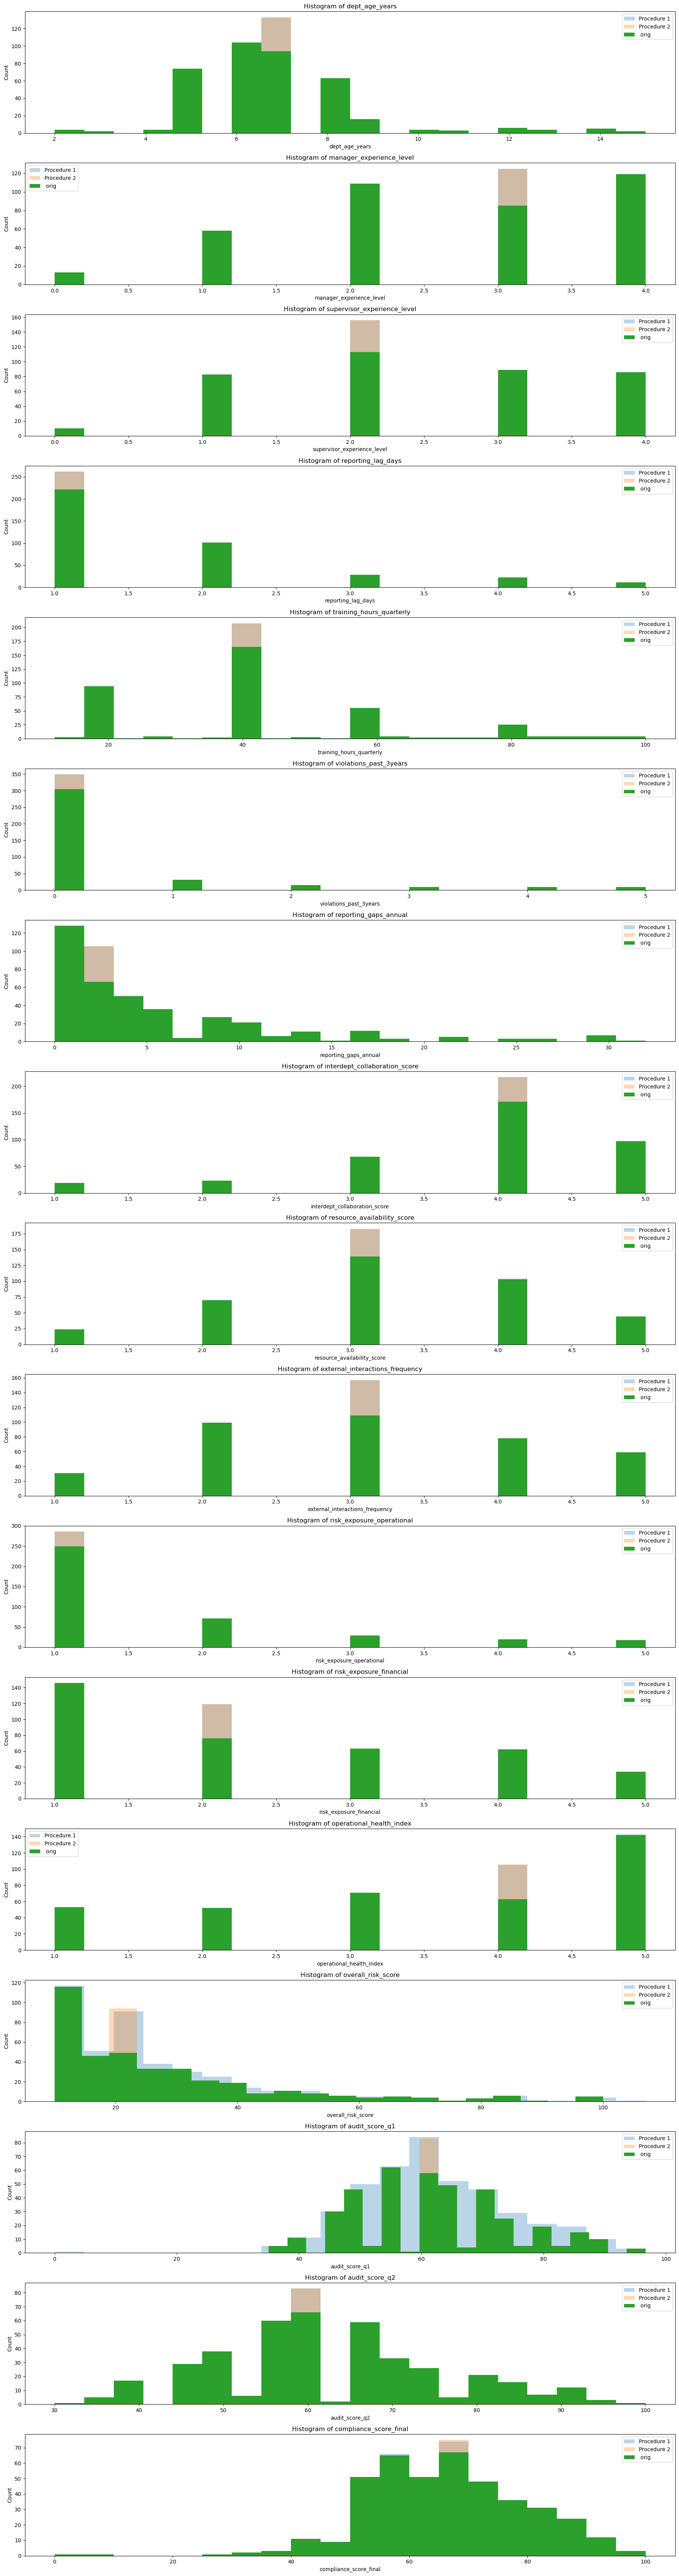

In [4557]:
#compate distributions

# Columns to compare
numerical_cols_for_hist = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2',
    'compliance_score_final'
]

# Set up the figure
plt.figure(figsize=(18, len(numerical_cols_for_hist)*4))

for i, col in enumerate(numerical_cols_for_hist, 1):
    plt.subplot(len(numerical_cols_for_hist), 1, i)
    plt.hist(departments_copy_for_missing_imputation_1[col], bins=20, alpha=0.3, label='Procedure 1')
    plt.hist(departments_copy_for_missing_imputation_2[col], bins=20, alpha=0.3, label='Procedure 2')
    plt.hist(departments[col], bins=20, alpha=1, label=' orig')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

---
Although the division-level statistics between the two procedures are similar, the distributions of individual numerical variables show that Procedure 2 preserves the original data patterns more accurately. Therefore, Procedure 2 should be adopted for final imputation.

---

#### **Adopting Procedure 2**

In [4560]:
departments = departments_copy_for_missing_imputation_2.copy()
high_risk_departments = high_risk_copy_for_missing_imputation_2.copy()
risk_summary_by_division_new = proc2_stats

In [4561]:
departments.shape

(424, 37)

In [4562]:
departments.head(100)

dept_id           dept_category             division   dept_type  \
0    DEPT-1003     Financial_Reporting         Corporate_HQ     Support   
4    DEPT-1066     Financial_Reporting         Corporate_HQ     Support   
5    DEPT-1070     Financial_Reporting         Corporate_HQ  Operations   
6    DEPT-1089     Financial_Reporting         Corporate_HQ     Support   
8    DEPT-1096     Financial_Reporting  Regional_Operations     Finance   
9    DEPT-1119     Financial_Reporting         Corporate_HQ     Support   
10   DEPT-1133     Financial_Reporting         Corporate_HQ  Compliance   
11   DEPT-1147     Financial_Reporting         Corporate_HQ  Technology   
13   DEPT-1168     Financial_Reporting         Corporate_HQ     Support   
14   DEPT-1177     Financial_Reporting  Regional_Operations  Operations   
15   DEPT-1183     Financial_Reporting         Corporate_HQ     Support   
16   DEPT-1192     Financial_Reporting         Corporate_HQ     Support   
18   DEPT-1233     Financial_Reporting         Corporate_HQ  Operations   
19   DEPT-1235     Financial_Reporting         Corporate_HQ     Support   
20   DEPT-1237     Financial_Reporting         Corporate_HQ     Support   
23   DEPT-1273     Financial_Reporting         Corporate_HQ     Support   
25   DEPT-1341     Financial_Reporting         Corporate_HQ     Support   
26   DEPT-1342     Financial_Reporting         Corporate_HQ  Operations   
27   DEPT-1344     Financial_Reporting         Corporate_HQ     Support   
30   DEPT-1378     Financial_Reporting         Corporate_HQ  Operations   
31   DEPT-1396     Financial_Reporting         Corporate_HQ  Operations   
32   DEPT-1416     Financial_Reporting         Corporate_HQ     Support   
33   DEPT-1439     Financial_Reporting         Corporate_HQ     Support   
35   DEPT-1455         Risk_Management  Regional_Operations     Support   
36   DEPT-1472     Financial_Reporting         Corporate_HQ     Support   
41   DEPT-1584     Financial_Reporting         Corporate_HQ  Operations   
42   DEPT-1588     Financial_Reporting  Regional_Operations  Operations   
43   DEPT-1620     Financial_Reporting         Corporate_HQ  Operations   
44   DEPT-1622     Financial_Reporting         Corporate_HQ  Operations   
46   DEPT-1649     Financial_Reporting         Corporate_HQ     Support   
48   DEPT-1673     Financial_Reporting         Corporate_HQ     Finance   
49   DEPT-1694     Financial_Reporting         Corporate_HQ  Operations   
51   DEPT-1744     Financial_Reporting         Corporate_HQ  Technology   
52   DEPT-1752     Financial_Reporting         Corporate_HQ     Support   
54   DEPT-1766     Financial_Reporting         Corporate_HQ  Operations   
55   DEPT-1777     Financial_Reporting         Corporate_HQ  Operations   
56   DEPT-1797     Financial_Reporting         Corporate_HQ     Support   
57   DEPT-1799     Financial_Reporting         Corporate_HQ     Support   
59   DEPT-1852     Financial_Reporting         Corporate_HQ  Operations   
60   DEPT-1856     Financial_Reporting         Corporate_HQ  Operations   
62   DEPT-1864     Financial_Reporting         Corporate_HQ     Support   
65   DEPT-1934     Financial_Reporting         Corporate_HQ       Legal   
66   DEPT-1945     Financial_Reporting         Corporate_HQ     Support   
67   DEPT-1947     Financial_Reporting         Corporate_HQ     Support   
68   DEPT-1953     Financial_Reporting         Corporate_HQ     Support   
69   DEPT-1972     Financial_Reporting         Corporate_HQ     Support   
73   DEPT-2035     Financial_Reporting         Corporate_HQ     Support   
74   DEPT-2037     Financial_Reporting         Corporate_HQ  Operations   
75   DEPT-2040  Operational_Compliance         Corporate_HQ  Operations   
76   DEPT-2047     Financial_Reporting         Corporate_HQ     Support   
77   DEPT-2092     Financial_Reporting         Corporate_HQ     Support   
78   DEPT-2106     Financial_Reporting         Corporate_HQ     Support   
79   DEPT-2114     Financial_Rep

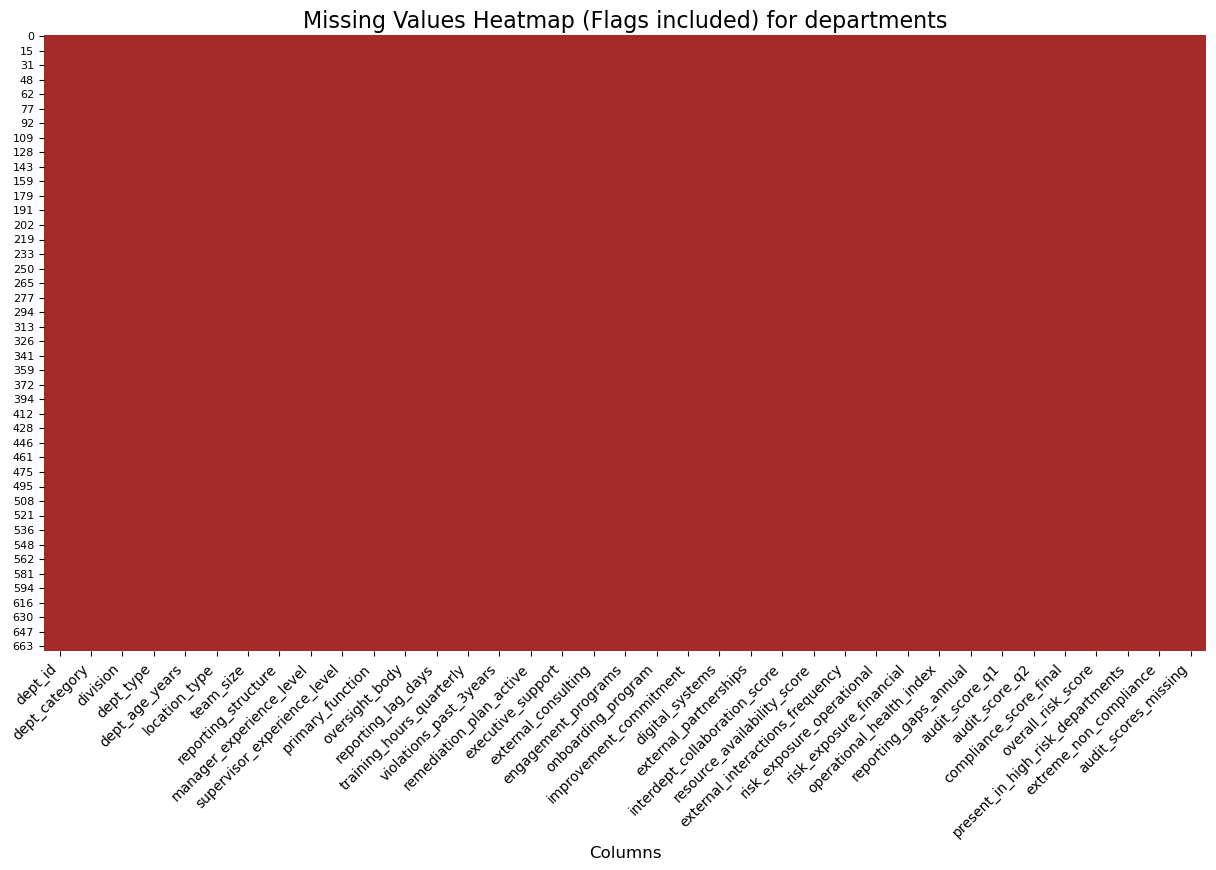

In [4563]:
plt.figure(figsize=(15,8))

sns.heatmap(
    departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap (Flags included) for departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

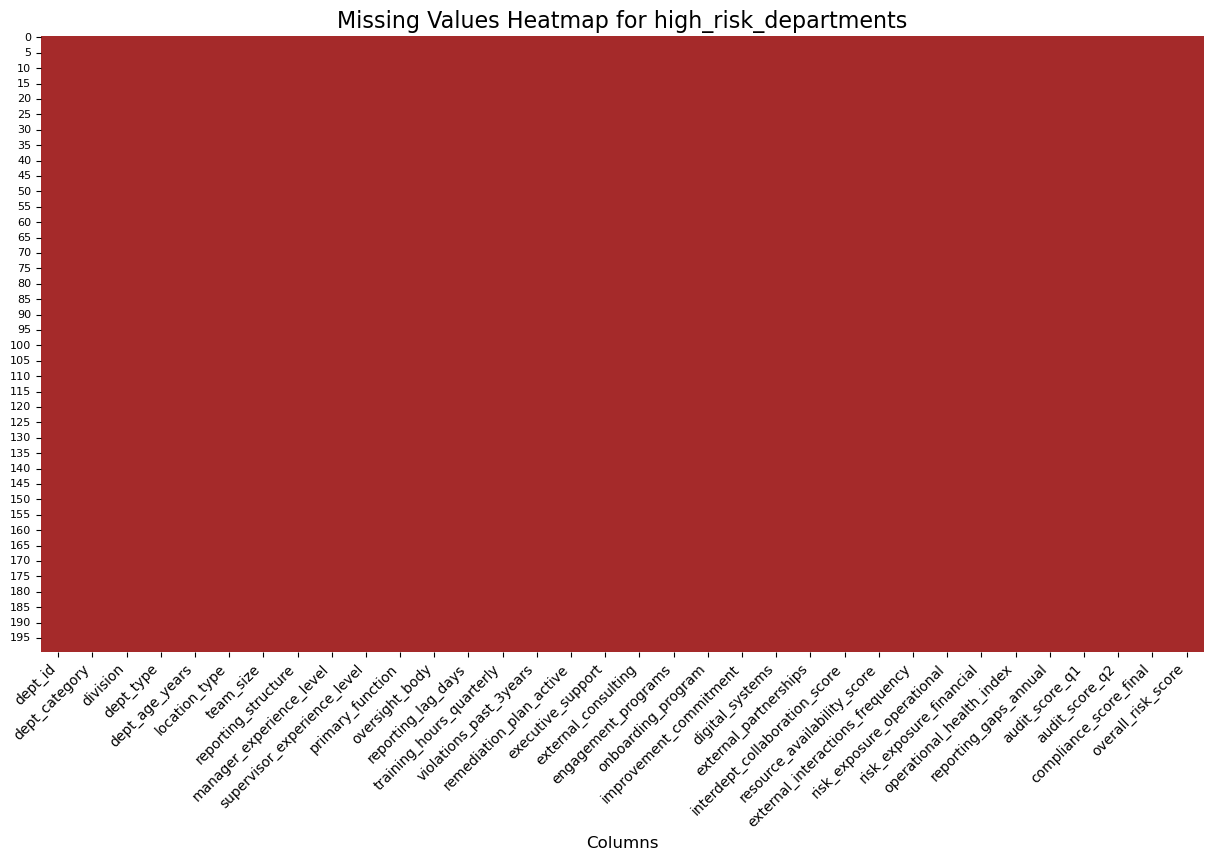

In [4564]:
plt.figure(figsize=(15,8))

sns.heatmap(
    high_risk_departments.isnull(),
    cbar=False,
    cmap=sns.color_palette(["brown", "white"])
)

plt.title('Missing Values Heatmap for high_risk_departments', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.show()

### **Correlation Analysis**

We check correlations with our two target variables:
- Primary: compliance_score_final
- Secondary: overall_risk_score

---
Both variables are numerical and continueous, therefore, we can check correlations **numetical vs numerical** and **numerical vs categorical**. Boolean variables we include in categorical.

---

#### **Target vs Categorical variables**

In [4569]:
categorical_cols = ['dept_category', 'division', 'dept_type', 
    'location_type', 'team_size', 'reporting_structure', 'primary_function', 
     'oversight_body'
]
bool_cols = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships', 'present_in_high_risk_departments', 
    'extreme_non_compliance','audit_scores_missing'
]
all_categorical_cols = categorical_cols + bool_cols

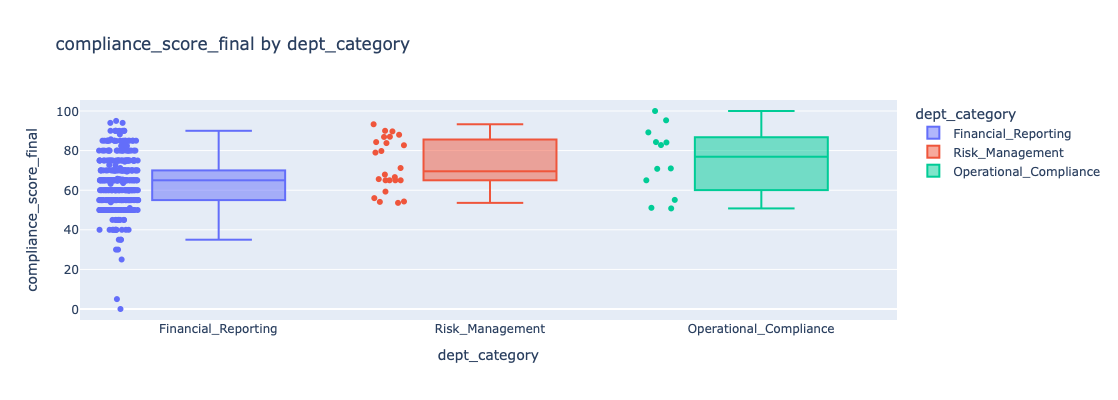

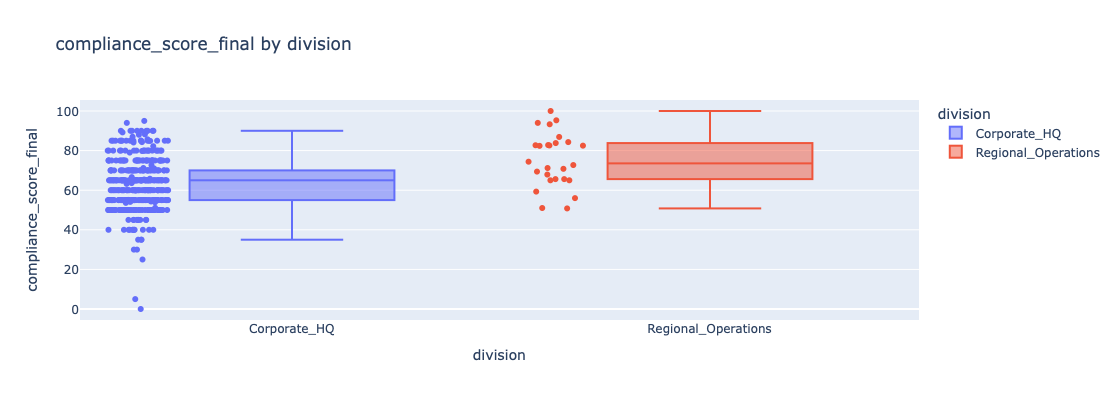

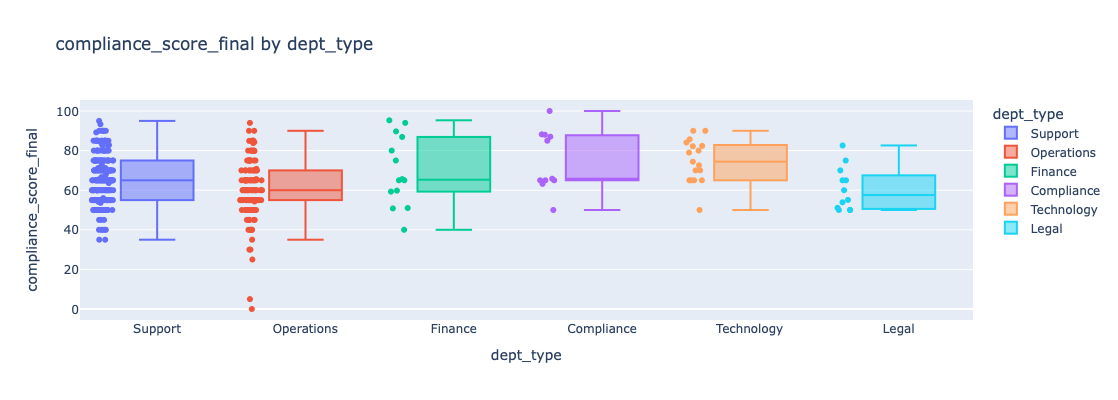

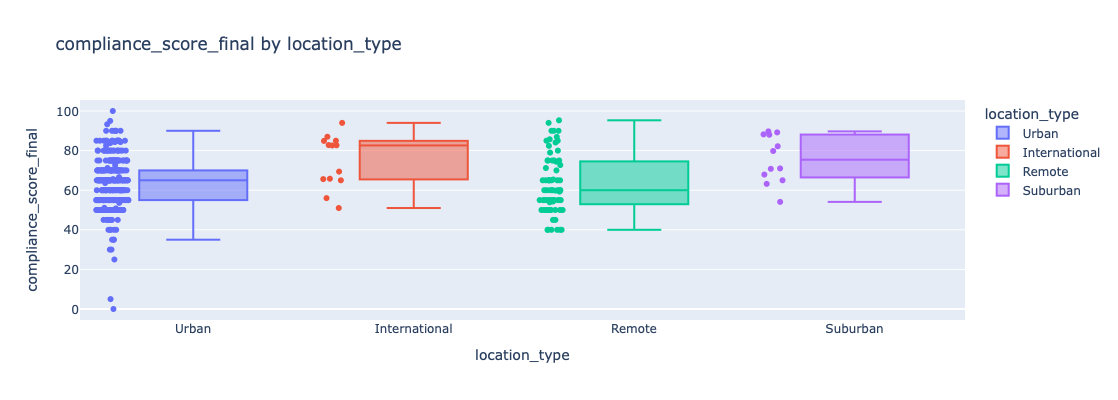

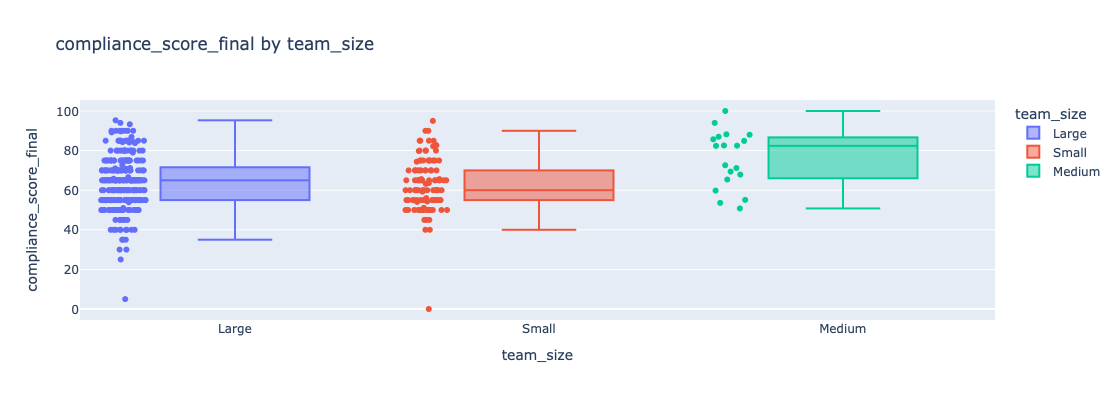

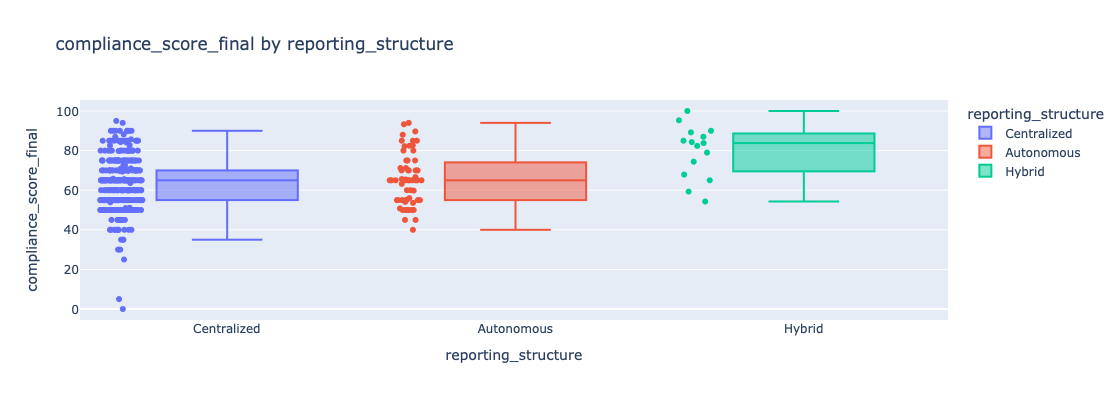

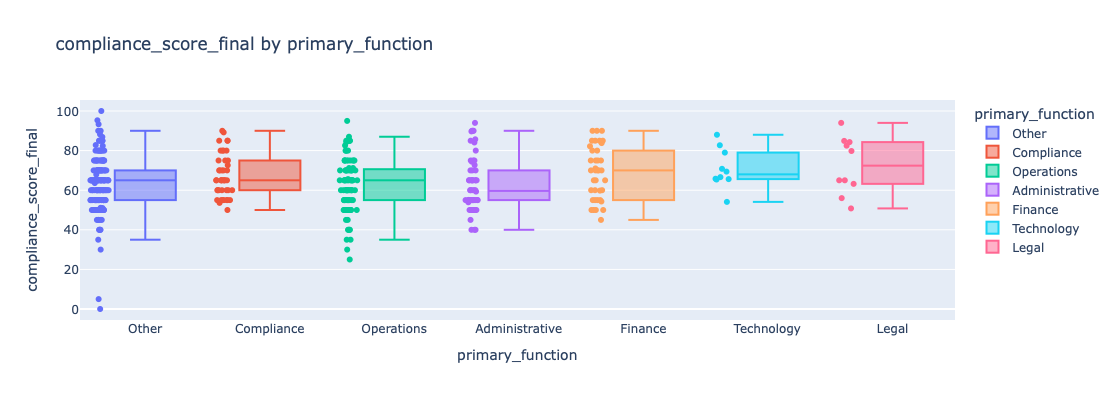

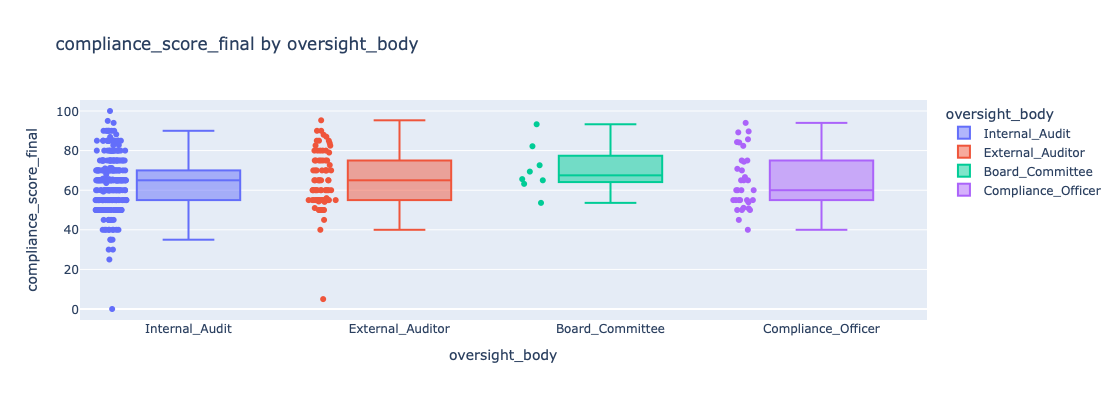

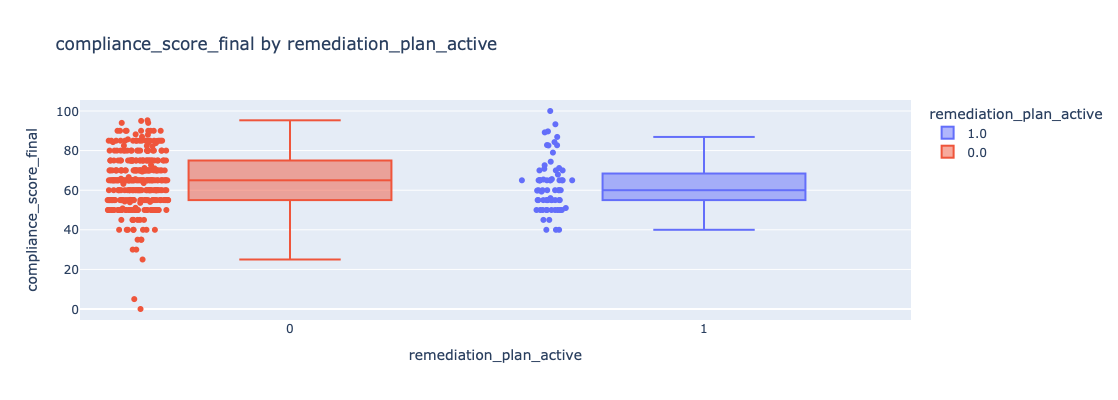

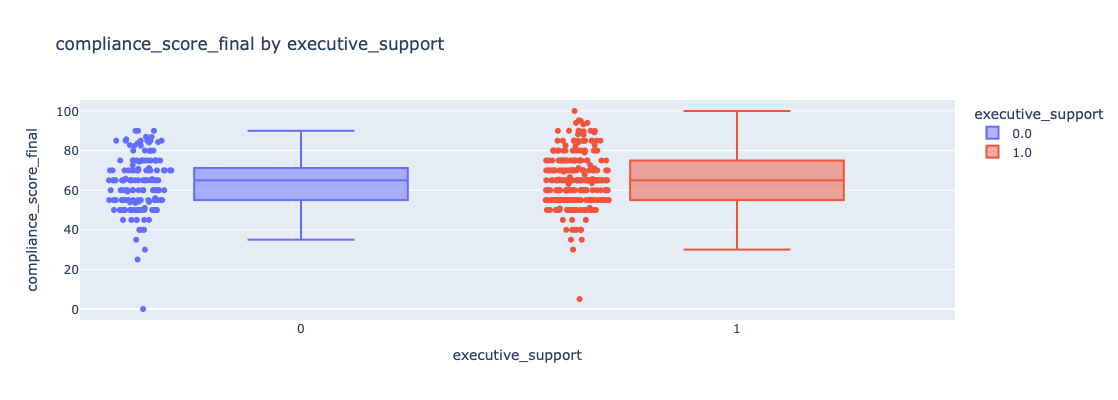

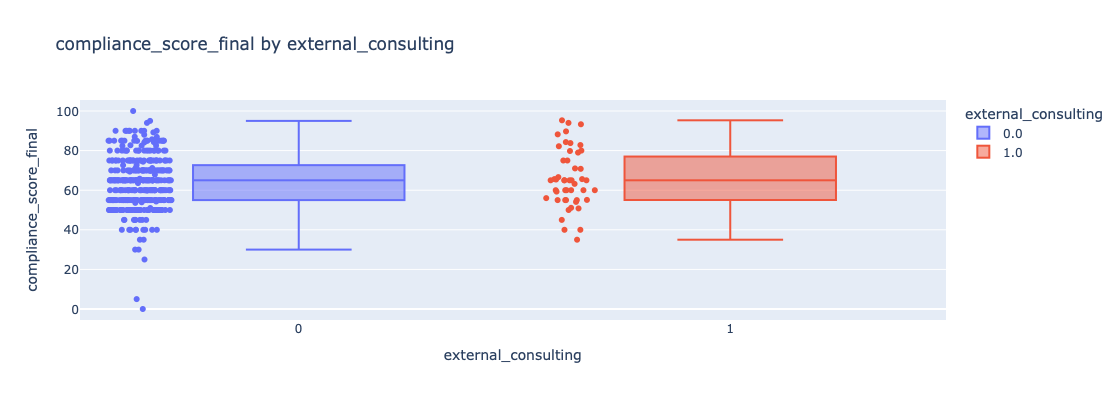

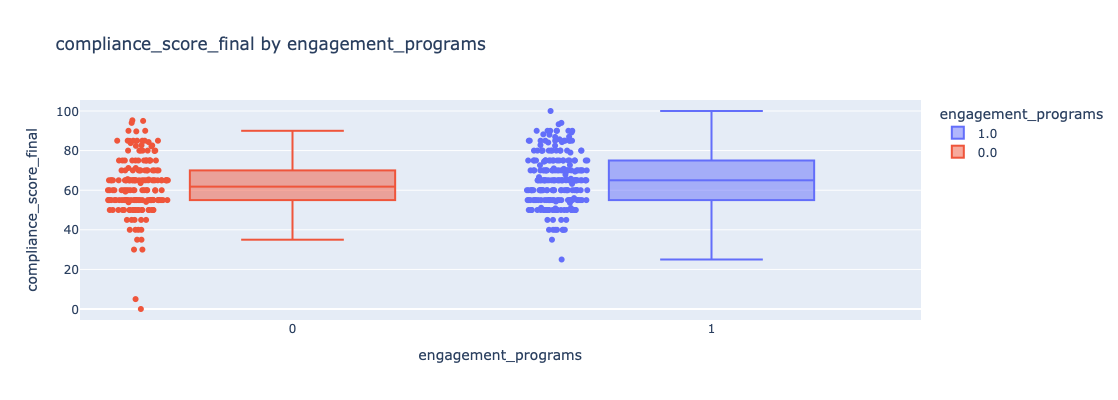

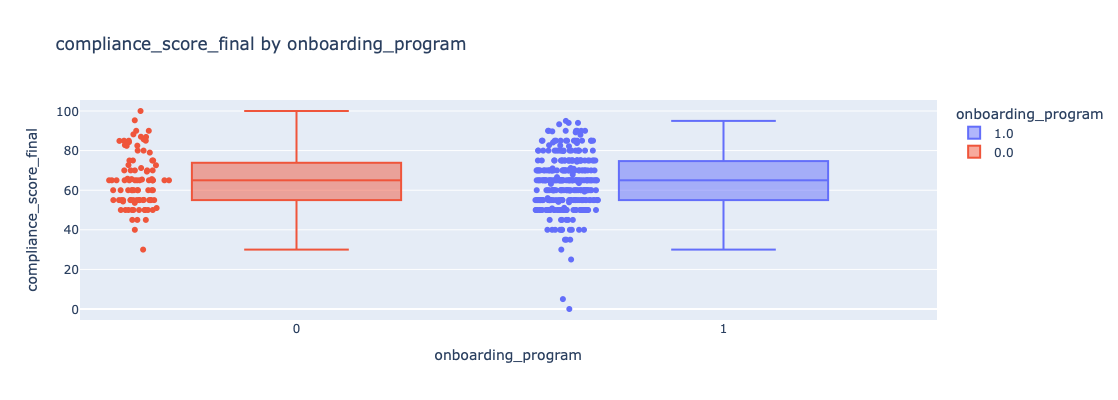

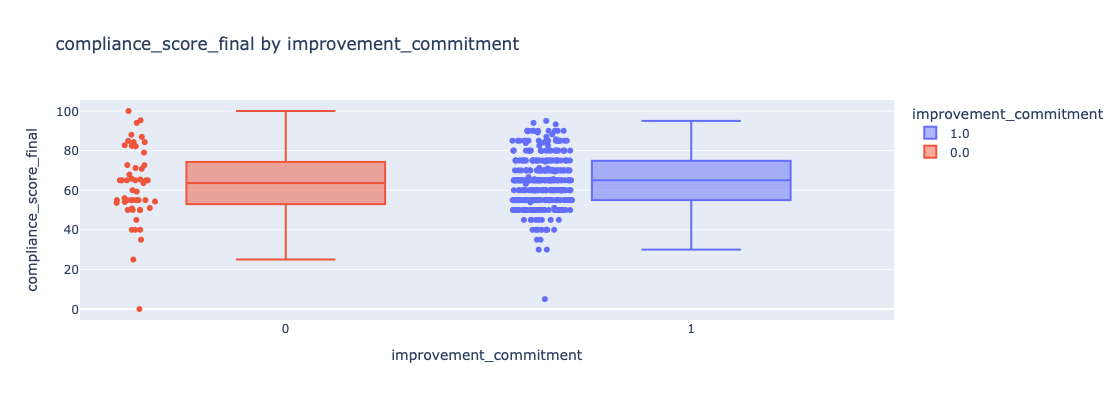

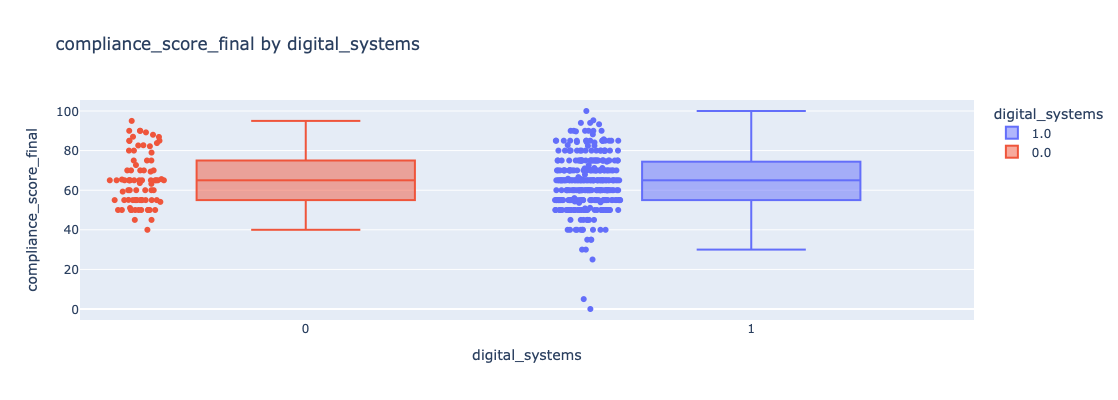

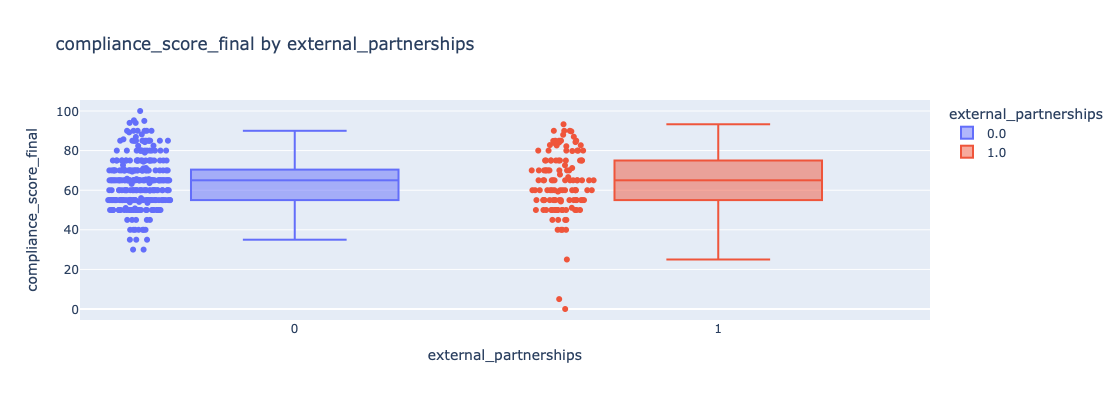

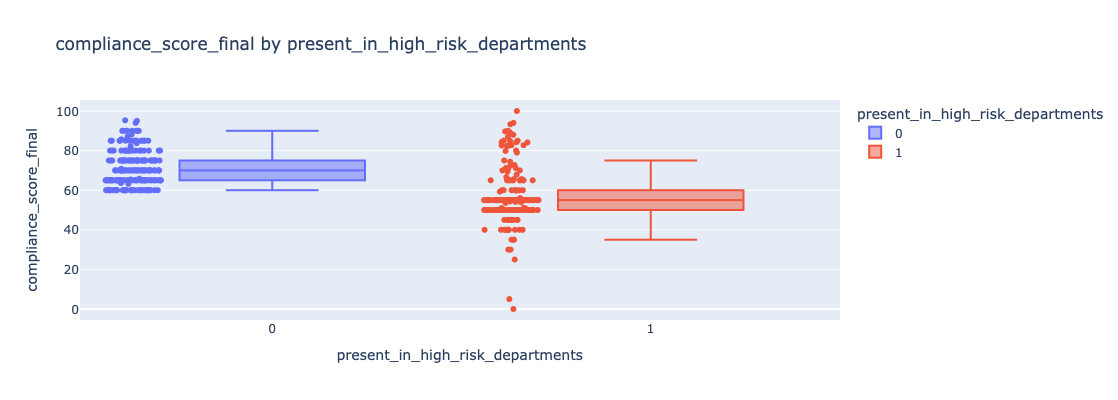

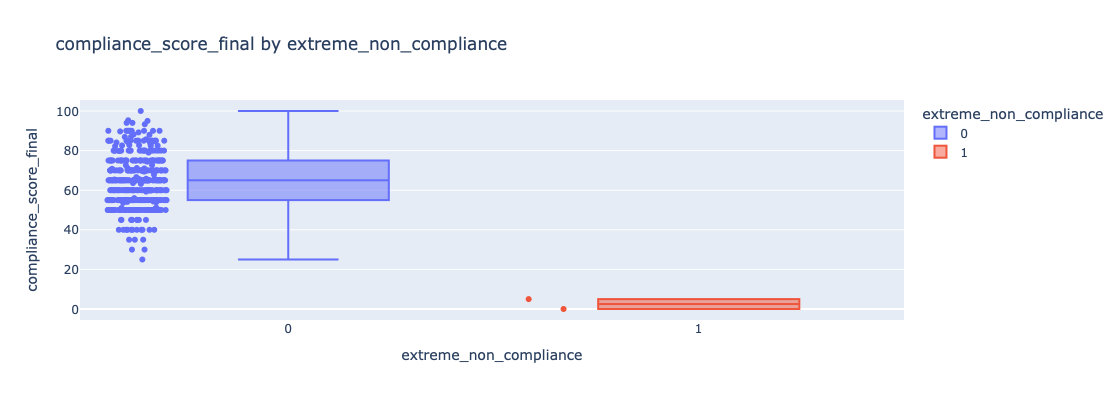

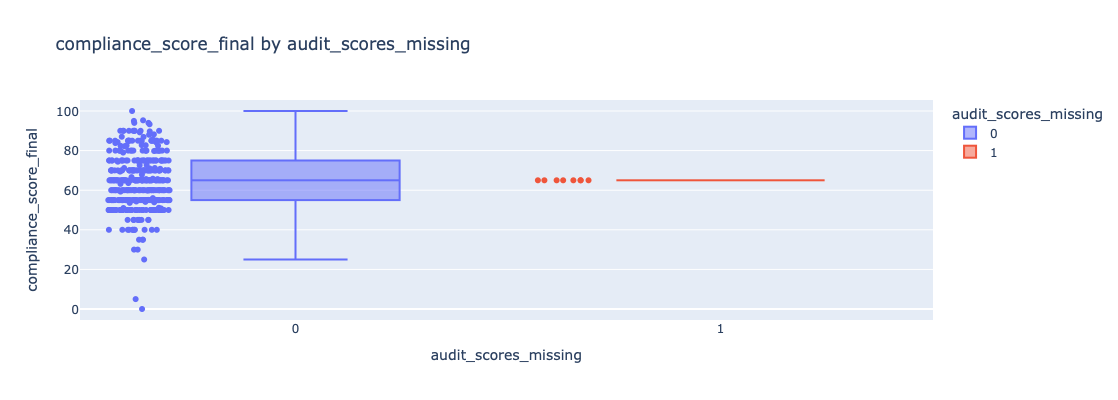

In [4570]:
for cat_col in all_categorical_cols:
    for num_col in ['compliance_score_final']:
        fig = px.box(
            departments,
            x=cat_col,
            y=num_col,
            color=cat_col,
            points='all',
            title=f'{num_col} by {cat_col}'
        )
        fig.update_layout(width=600, height=400)
        fig.show()

---
On average:
- For Technology department type (dept_type) the compliance is the highest, while for Legal department type it is the lowest.
- Medium team_size clearly has higher compliance as well as Hybrid reporting structure.
- International location in location_type shows higher compliance (important to mention, that the least amount of departments work abroad)
- Departments with Remediation plan have slightly higher compliance.
- Departments that were marked as high risky show lower compliance.
- Extreme non compliance, of course, shows very low compliance for these departments.
- Departments with Missing audit scores (any) ?????

---

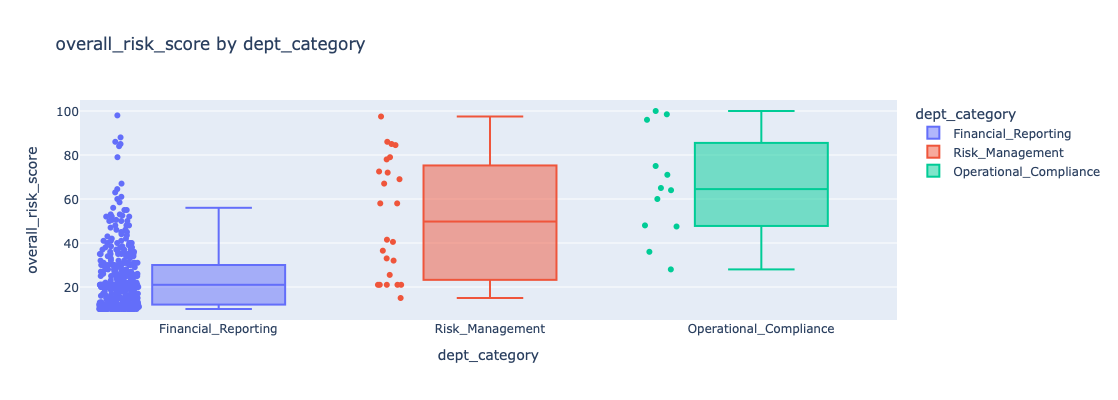

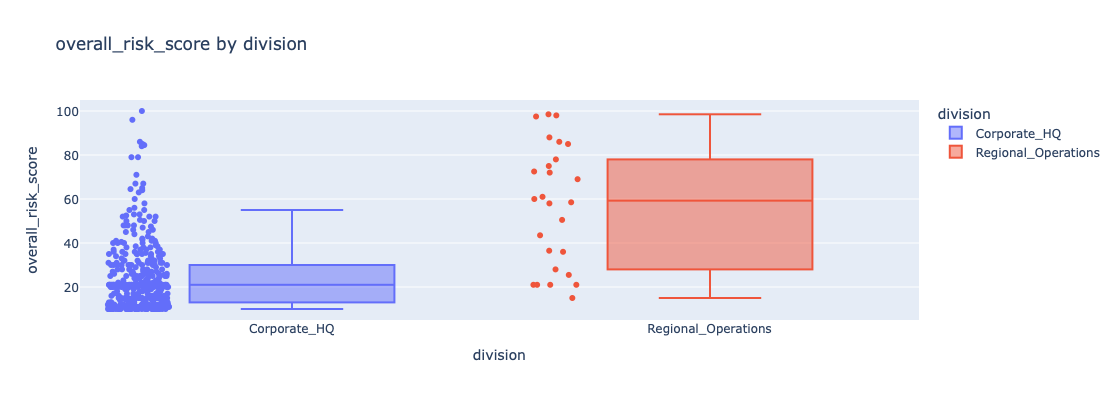

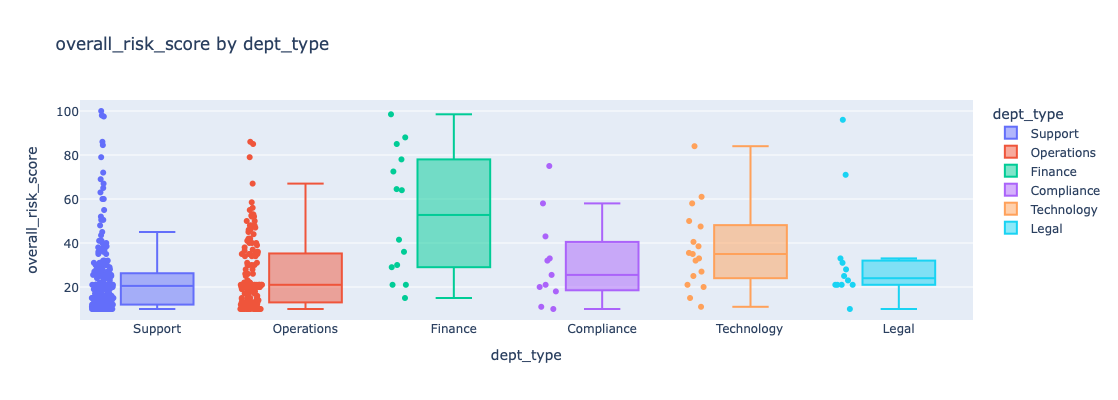

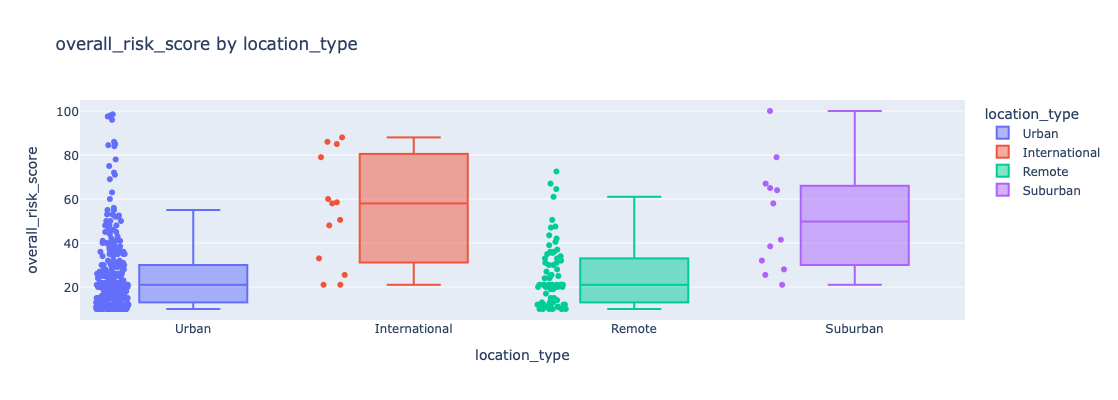

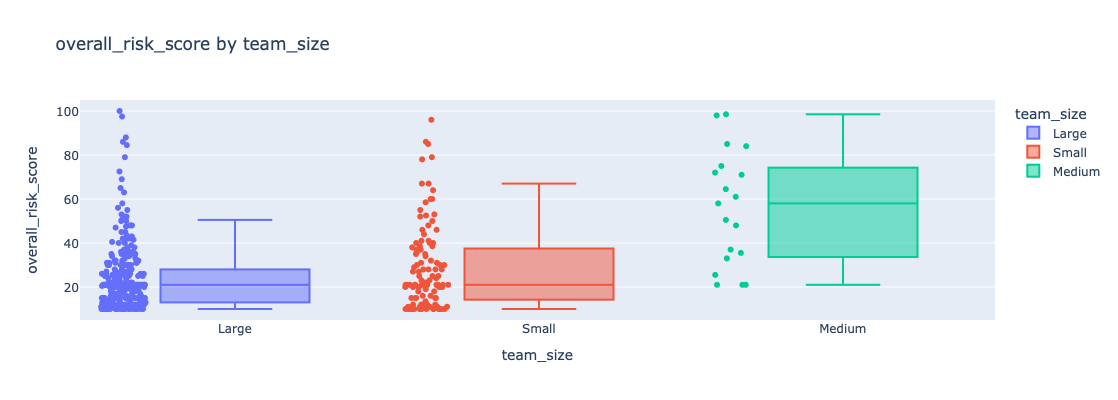

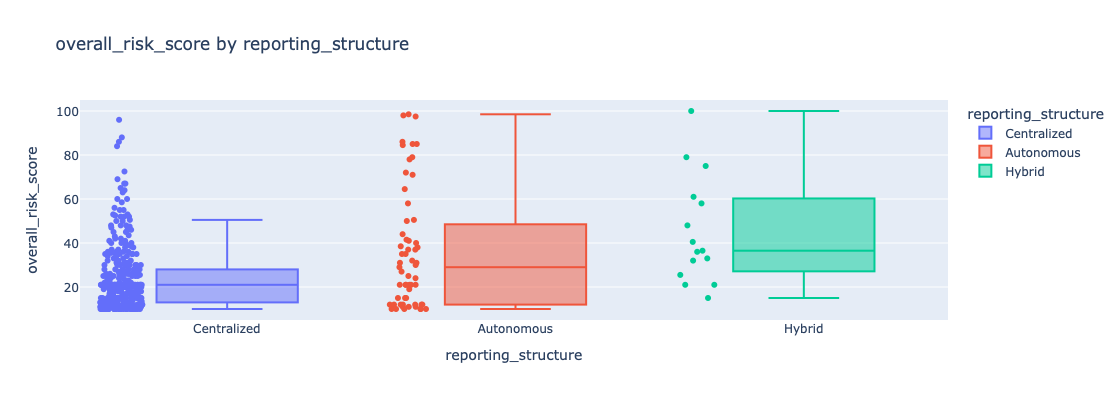

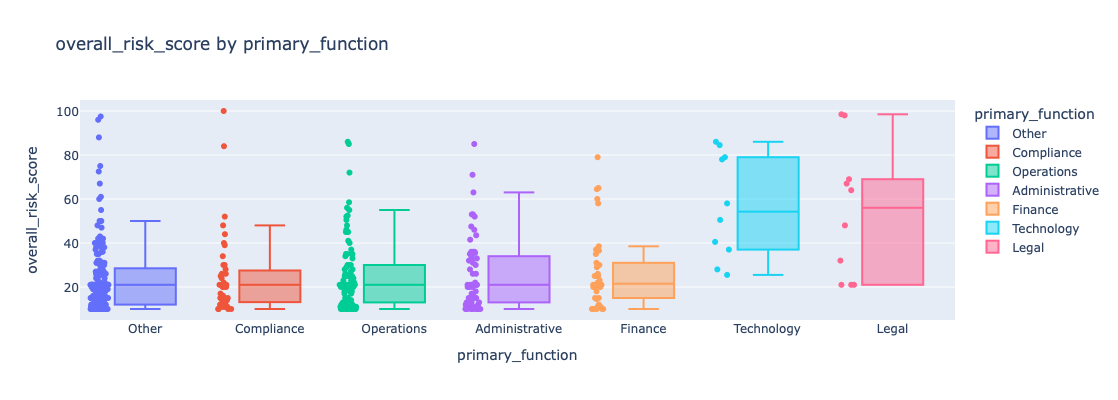

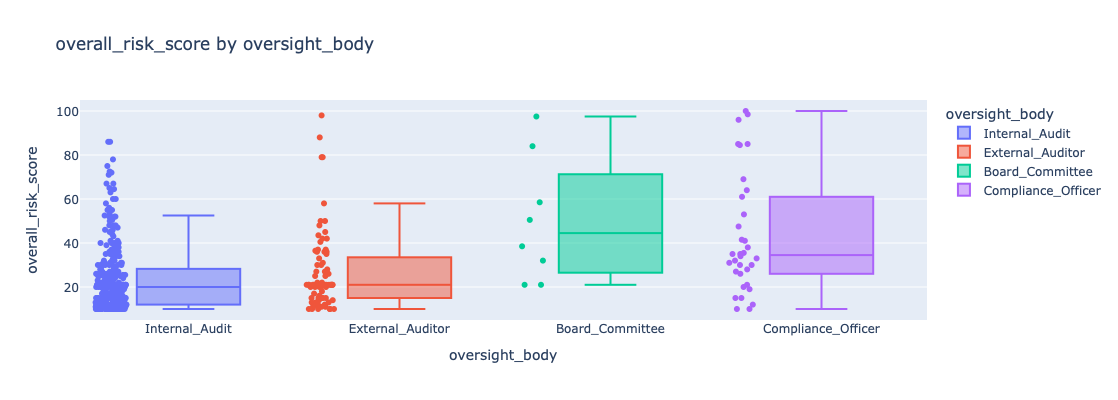

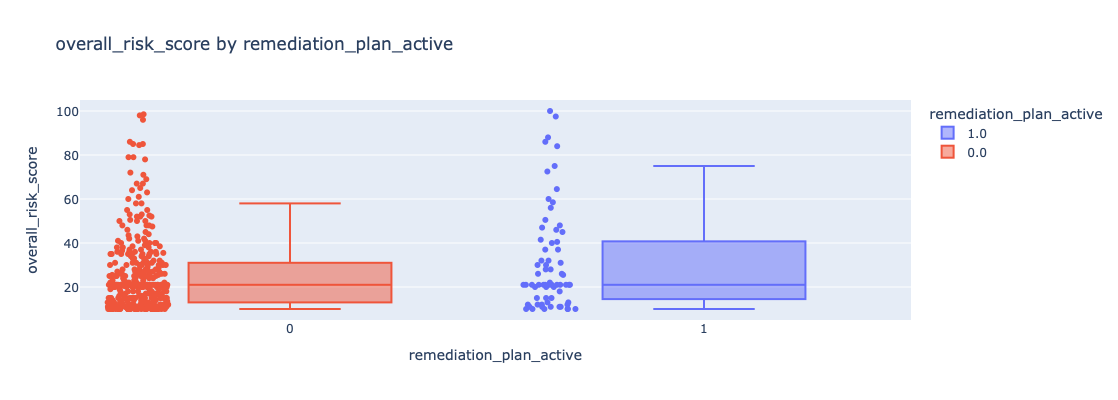

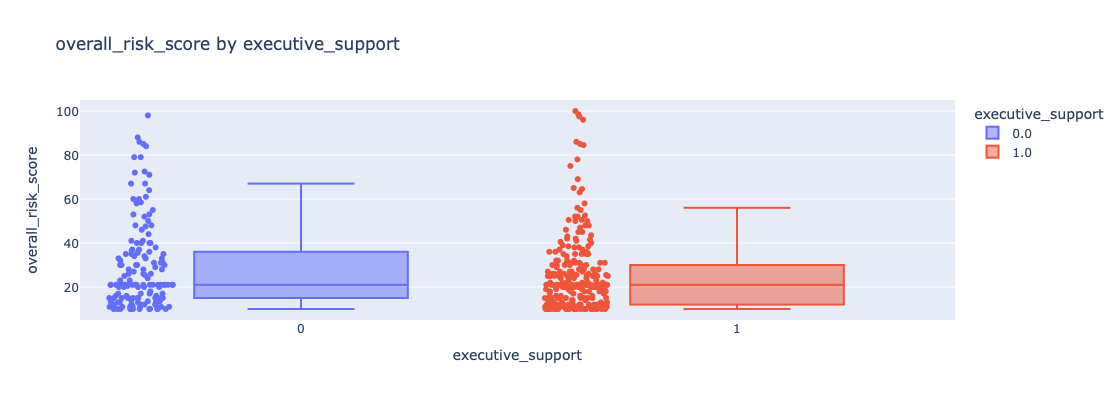

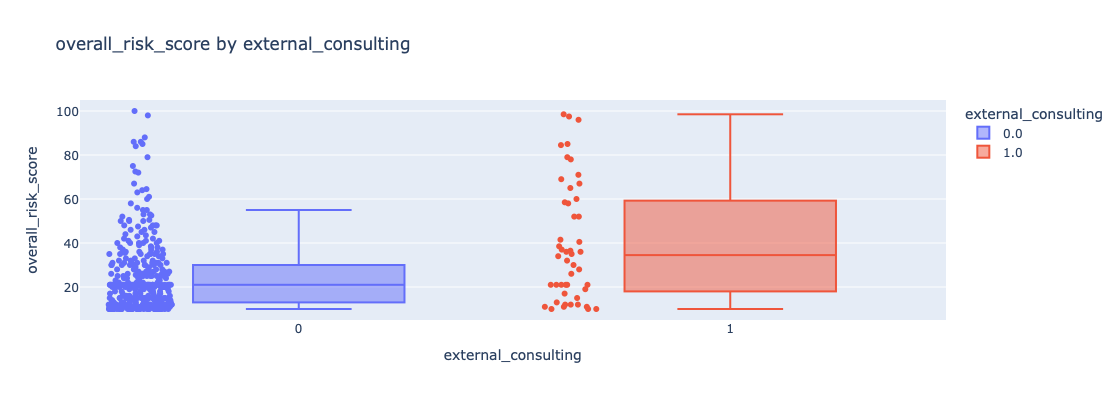

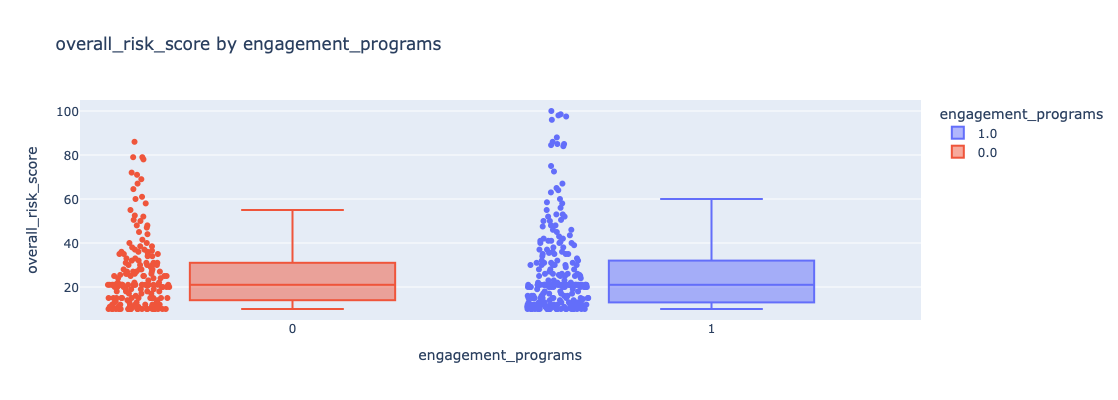

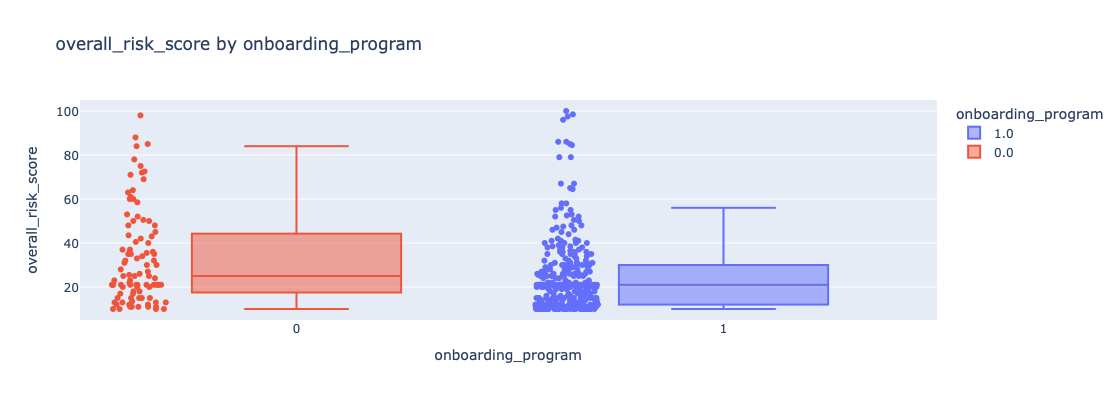

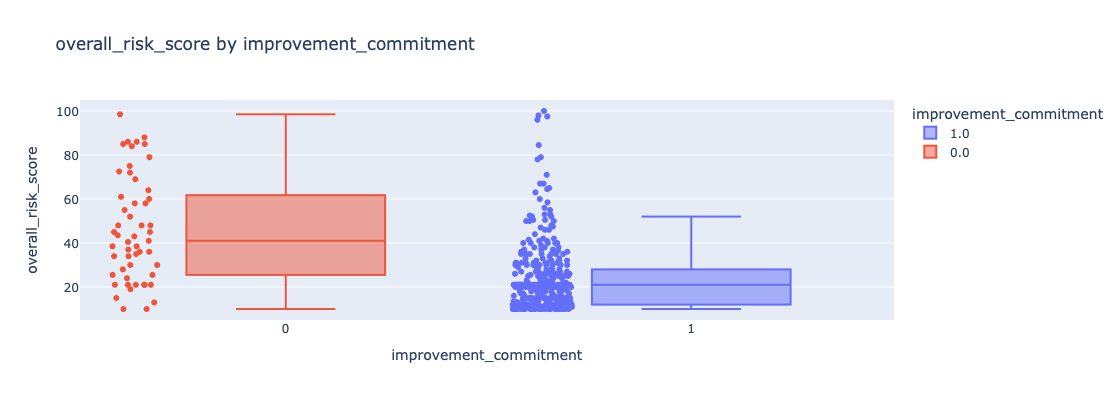

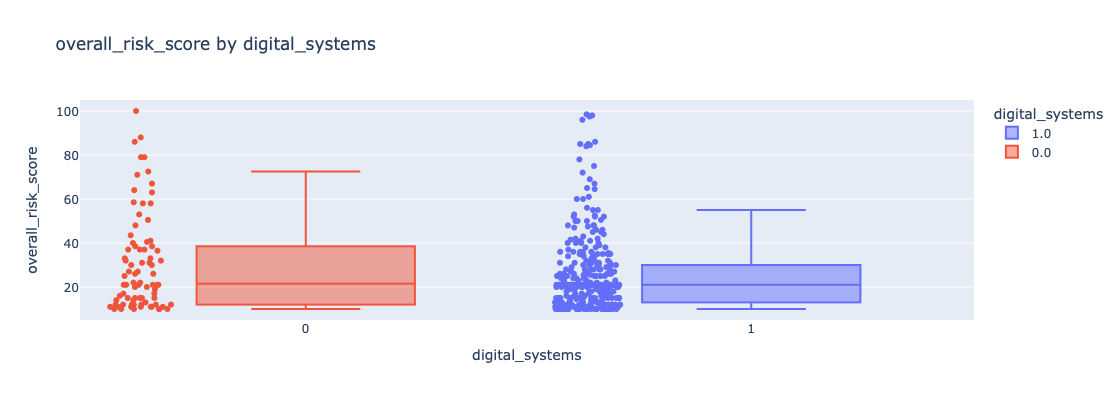

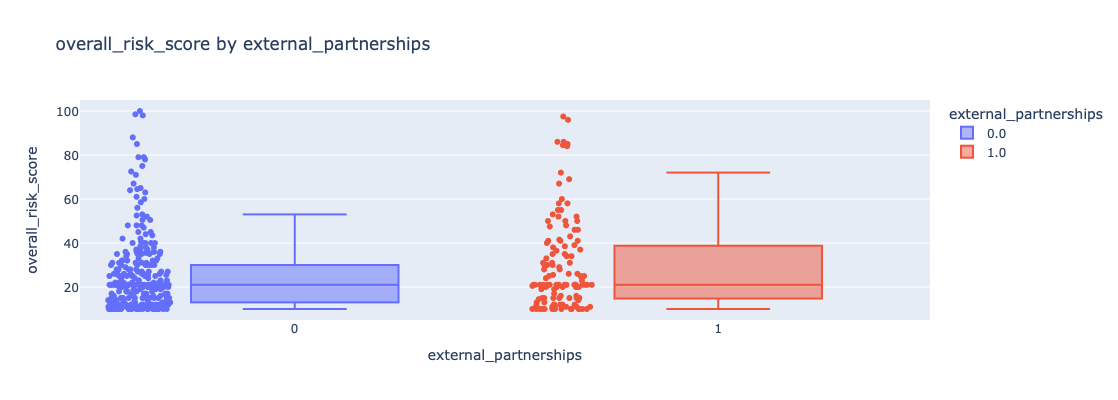

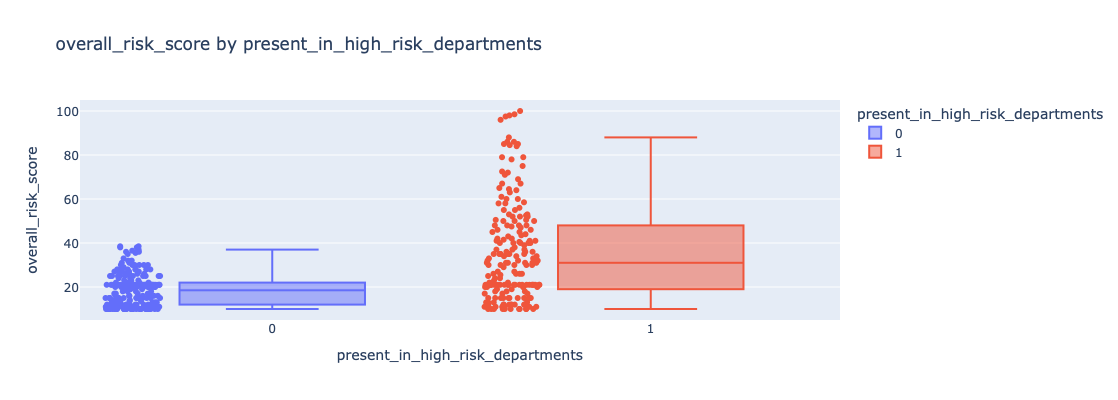

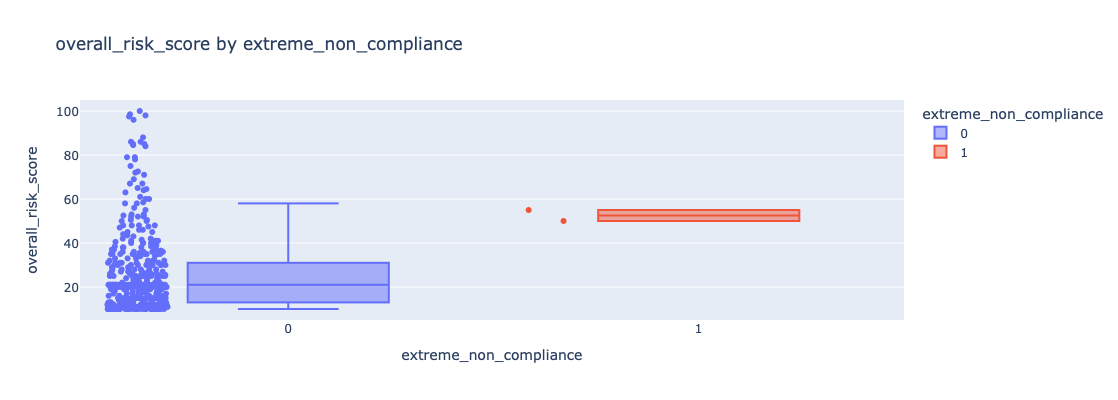

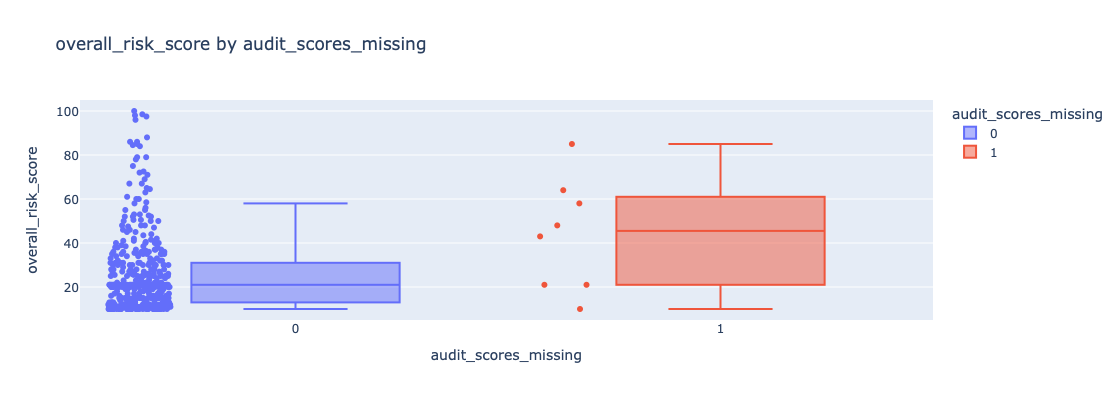

In [4576]:
for cat_col in all_categorical_cols:
    for num_col in ['overall_risk_score']:
        fig = px.box(
            departments,
            x=cat_col,
            y=num_col,
            color=cat_col,
            points='all',
            title=f'{num_col} by {cat_col}'
        )
        fig.update_layout(width=600, height=400)
        fig.show()

---
On average:
- Depsrtments dealing with Operational Compliance rules show the highest risk score, while for Financial Reporting, risk is the lowest.
- Regional Compliance  division also demonstrates very high risk score, comparing to Corporate division.
- Financial departments tend to have higher risks, while Support are among the lowest together with Operations.
- International and suburban locations are much more risky than urban and remote.
- Medium team size shows the highest risks, while small and large are approximately on the same level and are not risky in general.
- Departments whose primary function is Legal or technology have much higher risks than any others.
- Departments checked by Board Committee show the highest risks.
- Absence of Improvement commitmentsincreases risks
- Presence of external consulting also increases risks
- Obviousely, departments previousely marked as highly risky show higher risks scores.
- Departments with Extreme non-compliance are also much more risky.
- Departments with missing audit scores (any) have higher risks.

---

#### **Target vs Numerical variables**

In [4582]:
# Compute correlation matrix
corr_matrix = departments[numerical_cols].corr()

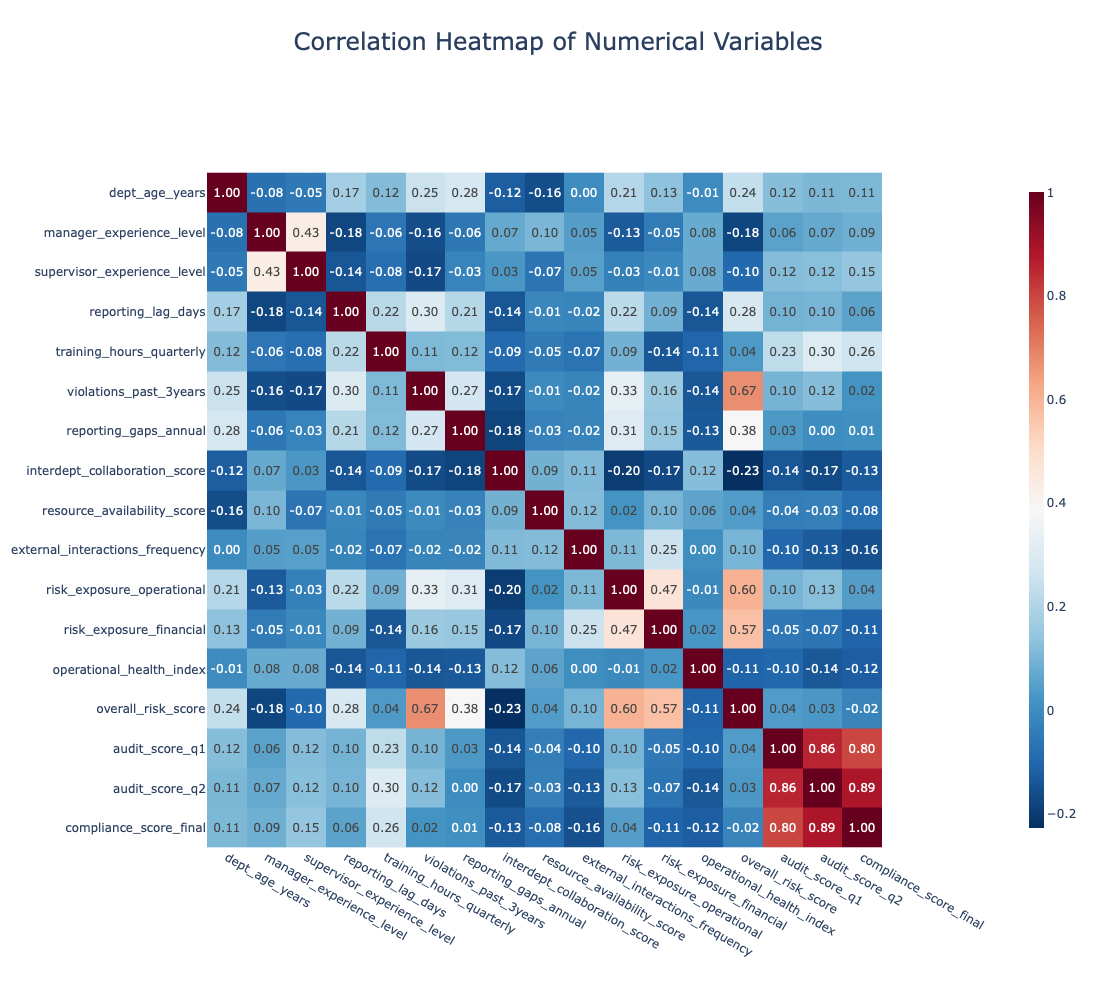

In [4583]:
fig = px.imshow(
    corr_matrix,
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    title="Correlation Heatmap of Numerical Variables",
    width=1000,
    height=1000
)

# Update layout for title and colorbar
fig.update_layout(
    title=dict(
        text="Correlation Heatmap of Numerical Variables",
        x=0.5,          # Center the title
        xanchor='center',
        font=dict(size=24)  # Bigger title
    ),
    coloraxis_colorbar=dict(
        thickness=15,   # thinner colorbar
        len=0.8         # scale length (0-1)
    )
)

fig.show()

---
***FOR compliance_score_final***

The two audit variables completely dominate:
- audit_score_q2 → 0.89
- audit_score_q1 → 0.80

This is the only non-audit factor with meaningful relationship:
training_hours_quarterly → 0.26

Weak correlations:
- external_interactions_frequency → -0.16
- operational_health_index → -0.12
- interdept_collaboration_score → -0.13
- dept_age_years → 0.11


Other relationaships are too weak.


They can be dropped 


***FOR overall_risk_score***

Strong predictors:
- risk_exposure_operational → 0.60
- violations_past_3years → 0.67
- risk_exposure_financial → 0.57
- reporting_gaps_annual → 0.38

These variables dominate the relationship with overall_risk_score and should definitely be kept.

Moderate predictors:
- dept_age_years → 0.24
- interdept_collaboration_score → -0,23
- reporting_lag_days → 0.28
- manager_experience_level → -0.18

Other relationaships are too weak.

---

### **Mutual Information**

Mutual Information measures how much knowing variable A reduces uncertainty about variable B.

Works for:
- nonlinear relationships
- categorical variables
- boolean variables

Interpretation:
- MI = 0 → variables are completely independent
- MI > 0 → some relationship exists
- The larger the MI, the stronger the dependency (not necessarily linear)

---

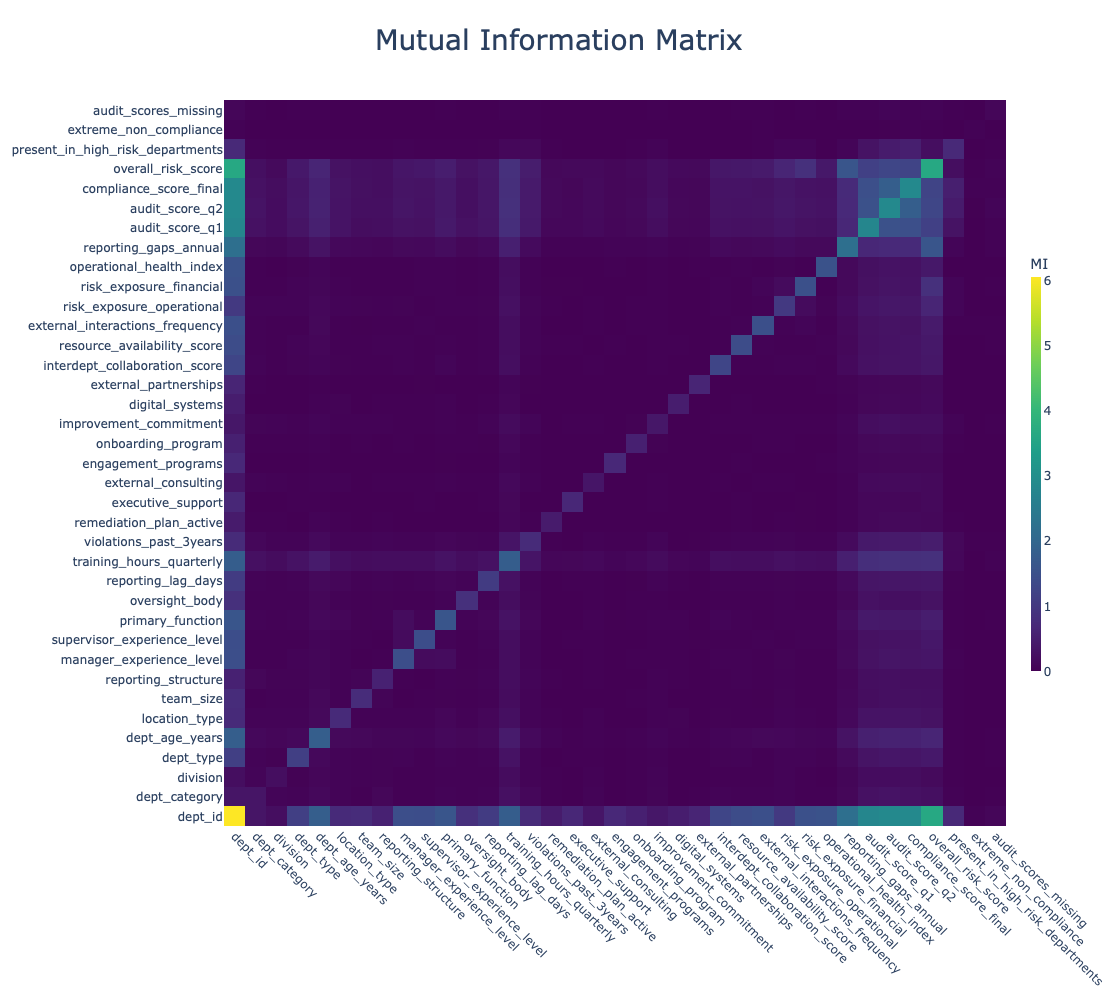

In [4587]:

# ----------------------------
# 1. Compute MI
# ----------------------------
cols = departments.columns
mi_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

def compute_mi(x, y):
    return mutual_info_score(x, y)

# Convert all columns to categorical integer codes
dep_mi = departments.copy()
for c in dep_mi.columns:
    dep_mi[c] = pd.factorize(dep_mi[c])[0]

for c1 in cols:
    for c2 in cols:
        mi_matrix.loc[c1, c2] = compute_mi(dep_mi[c1], dep_mi[c2])

# ----------------------------
# 2. Interactive Heatmap
# ----------------------------
fig = go.Figure(
    data=go.Heatmap(
        z=mi_matrix.values,
        x=cols,
        y=cols,
        colorscale="Viridis",
        colorbar=dict(
            title="MI",
            len=0.6,
            thickness=10
        ),
        hovertemplate="<b>%{y}</b> vs <b>%{x}</b><br>MI = %{z:.3f}<extra></extra>"
    )
)

fig.update_layout(
    title=dict(
        text="Mutual Information Matrix",
        x=0.5,
        xanchor="center",
        font=dict(size=28)
    ),
    width=1000,
    height=1000,
    xaxis=dict(tickangle=45)
)

fig.show()

In [4593]:
from sklearn.metrics import mutual_info_score
import numpy as np

cols = departments.columns
mi_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

def compute_mi(x, y):
    return mutual_info_score(x, y)

# Convert all to categorical codes for MI compatibility
dep_mi = departments.copy()
for c in dep_mi.columns:
    dep_mi[c] = pd.factorize(dep_mi[c])[0]

for c1 in cols:
    for c2 in cols:
        mi_matrix.loc[c1, c2] = compute_mi(dep_mi[c1], dep_mi[c2])

mi_matrix

dept_id  dept_category      division  \
dept_id                           6.049733       0.344634  2.305863e-01   
dept_category                     0.344634       0.344634  7.125919e-02   
division                          0.230586       0.071259  2.305863e-01   
dept_type                         1.131251       0.048908  2.617061e-02   
dept_age_years                    1.794168       0.121853  8.446096e-02   
location_type                     0.712716       0.057542  5.287137e-02   
team_size                         0.746180       0.022534  3.499338e-02   
reporting_structure               0.550979       0.096159  4.381937e-02   
manager_experience_level          1.444871       0.024225  1.201481e-02   
supervisor_experience_level       1.426786       0.020682  1.270631e-02   
primary_function                  1.604329       0.058269  3.775686e-02   
oversight_body                    0.836709       0.035910  2.853343e-02   
reporting_lag_days                1.066915       0.056301  3.679076e-02   
training_hours_quarterly          1.788167       0.256010  1.832019e-01   
violations_past_3years            0.728221       0.108131  4.963510e-02   
remediation_plan_active           0.444179       0.017304  2.482067e-02   
executive_support                 0.655241       0.007376  4.158353e-03   
external_consulting               0.353169       0.057713  3.117808e-02   
engagement_programs               0.681712       0.004995  2.817171e-07   
onboarding_program                0.534908       0.016836  1.512709e-02   
improvement_commitment            0.376770       0.065231  5.224923e-02   
digital_systems                   0.491110       0.008399  6.481377e-03   
external_partnerships             0.612455       0.017102  1.017570e-03   
interdept_collaboration_score     1.271026       0.047545  2.297585e-02   
resource_availability_score       1.401419       0.037089  2.473323e-02   
external_interactions_frequency   1.484641       0.035175  2.189186e-02   
risk_exposure_operational         1.026486       0.049979  4.831613e-02   
risk_exposure_financial           1.490492       0.019837  1.833717e-02   
operational_health_index          1.529468       0.020469  8.598432e-03   
reporting_gaps_annual             2.197532       0.095630  8.013034e-02   
audit_score_q1                    2.779665       0.279390  1.969659e-01   
audit_score_q2                    2.852004       0.315977  1.970543e-01   
compliance_score_final            2.862753       0.279393  1.994969e-01   
overall_risk_score                3.620098       0.245639  1.531003e-01   
present_in_high_risk_departments  0.690965       0.031483  2.523549e-02   
extreme_non_compliance            0.029973       0.000420  2.992265e-04   
audit_scores_missing              0.093600       0.018527  3.567832e-03   

                                  dept_type  dept_age_years  location_type  \
dept_id                            1.131251        1.794168       0.712716   
dept_category                      0.048908        0.121853       0.057542   
division                           0.026171        0.084461       0.052871   
dept_type                          1.131251        0.126516       0.046682   
dept_age_years                     0.126516        1.794168       0.131471   
location_type                      0.046682        0.131471       0.712716   
team_size                          0.035798        0.115045       0.038383   
reporting_structure                0.046662        0.083519       0.042716   
manager_experience_level           0.053981        0.079824       0.037786   
supervisor_experience_level        0.024862        0.067745       0.036334   
primary_function                   0.049428        0.122529       0.084070   
oversight_body                     0.028974        0.101326       0.033797   
reporting_lag_days                 0.052271        0.131957       0.087171   
training_hours_quarterly           0.290794        0.441827       0.236662   
violations_pas

---
**1. Compliance/Audit Cluster (very high MI)**
- audit_score_q1
- audit_score_q2
- compliance_score_final
- operational_health_index
- overall_risk_score
- violations_past_3years
- reporting_lag_days

These variables represent the same underlying process, are collinear. We should Keep 1–2 (e.g., compliance_score_final + overall_risk_score) OR create a composite index (e.g., average or PCA component) to capture cluster without multicollinearity.


**2. Training/Engagement Cluster**
- training_hours_quarterly
- engagement_programs
- onboarding_program
- remediation_plan_active

Represents organizational effort. Training-related features are important and we expect them to be strong predictors. Keep them OR summarize into a “training/engagement score” through averaging or PCA.



**3. Structural + Resources Cluster**
- dept_age_years
- team_size
- manager_experience_level
- interdept_collaboration_score
- resource_availability_score

Represents department capacity. Consistency across MI suggests institutional culture effects. Keep them and standatdaze before modeling.


**4. ID-Driven / Latent Department Identity Cluster**
- dept_id 

Because dept_id has strong MI with almost everything, there is a hidden latent variable that is not explicitly in the dataset. Therefore, we should not use dept_id in modeling.

## **Encoding**

---
We will begin with encoding of our categroical variables, in order to be able to work wiht them in trainin our ML model:

These following variables will be encoded using one-hot (dummy variable) encoding since we have no inherent order, and the varivbales do not have so many categories, so in this case OHE is the most effecive.

- dept_category
- division
- dept_type
- location_type
- team_size
- reporting_structure
- primary_function
- oversight_body

---

In [4598]:
departments_copy_for_encoding = departments.copy()

In [4600]:
#we list the variable swhich shall bve encoded as said before
categorical_cols_to_encode = [
    'dept_category', 'division', 'dept_type', 
    'location_type', 'team_size', 'reporting_structure', 'primary_function', 
     'oversight_body'
]

In [4602]:
# store safely the 'dept_id' column separately since we are creatign a new data farnme wiht the categorical varibales
department_ids = departments['dept_id']

# then we drop the 'dept_id' from the working dataframe so it is not encoded, since the pd.get_dummies will be encoding all catheorical variables included in the original dataframe
departments_working = departments.drop(columns=['dept_id'])

In [4604]:
# then here we perform one-H´hot encoding using the pd.get_dummies function as we know
departments_encoded = pd.get_dummies(
    departments_working, 
    columns=categorical_cols_to_encode, 
    drop_first=True,
    dtype=int
)

In [4606]:
# finally insert the original dept_id column back into the encoded dataframe
departments_encoded.insert(0, 'dept_id', department_ids)
departments = departments_encoded

In [4608]:
#to viualise the encoded varibales in the dataframe 
departments.head(2)

dept_id  dept_age_years  manager_experience_level  \
0  DEPT-1003             8.0                       1.0   
4  DEPT-1066             5.0                       3.0   

   supervisor_experience_level  reporting_lag_days  training_hours_quarterly  \
0                          2.0                 2.0                      40.0   
4                          4.0                 1.0                      60.0   

   violations_past_3years  remediation_plan_active  executive_support  \
0                     0.0                      1.0                0.0   
4                     0.0                      0.0                1.0   

   external_consulting  engagement_programs  onboarding_program  \
0                  0.0                  1.0                 1.0   
4                  0.0                  1.0                 1.0   

   improvement_commitment  digital_systems  external_partnerships  \
0                     1.0              1.0                    0.0   
4                     1.0              1.0                    0.0   

   interdept_collaboration_score  resource_availability_score  \
0                            5.0                          4.0   
4                            4.0                          2.0   

   external_interactions_frequency  risk_exposure_operational  \
0                              4.0                        1.0   
4                              2.0                        1.0   

   risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
0                      1.0                       4.0                    0.0   
4                      1.0                       5.0                    2.0   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  \
0            60.0            65.0                    65.0                21.0   
4            65.0            65.0                    65.0                11.0   

   present_in_high_risk_departments  extreme_non_compliance  \
0                                 0                       0   
4                                 0                       0   

   audit_scores_missing  dept_category_Operational_Compliance  \
0                     0                                     0   
4                     0                                     0   

   dept_category_Risk_Management  division_Regional_Operations  \
0                              0                             0   
4                              0                             0   

   dept_type_Finance  dept_type_Legal  dept_type_Operations  \
0                  0                0                     0   
4                  0                0                     0   

   dept_type_Support  dept_type_Technology  location_type_Remote  \
0                  1                     0                     0   
4                  1                     0                     0   

   location_type_Suburban  location_type_Urban  team_size_Medium  \
0                       0                    1                 0   
4                       0                    1                 0   

   team_size_Small  reporting_structure_Centralized  \
0                0                                1   
4                0                                1   

   reporting_structure_Hybrid  primary_function_Compliance  \
0                           0                            0   
4                           0                            1   

   primary_function_Finance  primary_function_Legal  \
0                         0                       0   
4                         0                       0   

   primary_function_Operations  primary_function_Other  \
0                            0                       1   
4                            0                       0   

   primary_function_Technology  oversight_body_Compliance_Officer  \
0                            0                                  0   
4                            0                                  0   

In [4610]:
#Chekc for shape of dataframe
print(f"\nFinal DataFrame Shape: {departments.shape}")


Final DataFrame Shape: (424, 53)


## **Multicolinearity check (?)**


Now we will dig into searching for multicollinearuty between our varibales, since this might be problematic for our future model training.

This step is critical for creating an analytical framework for explanation and risk mitigation

As an exapmle if two of our variables lets say: if team_size_Large and reporting_structure_Centralized are 95% correlated, our model will not be able to detect which of these two varibles are responsible for a change in the risk score.

In addition, statistically multicollinearity might create more unstabile and harder to train models.

We can detect multicollineraity using the VIF (variance inflation factor). The VIF measures how much the variance of a regression coefficient is increased due to collinearity with other predictors.

In [4614]:
columns_to_exclude = [
    'dept_id',
    'compliance_score_final',
    'overall_risk_score'
]

# Create the predictor dataframe by dropping non-predictor columns
multi_col_check = departments.drop(columns=columns_to_exclude, errors='ignore')

# 2. Select only continuous numerical columns
# This automatically excludes string/object (categorical) columns.
multi_col_check = multi_col_check.select_dtypes(include=np.number)

# 3. Exclude all columns ending with '_missing' (the imputation flags)
# This filters the numerical set down to just the continuous/ordinal features.
columns_to_keep = [col for col in multi_col_check.columns if not col.endswith('_missing')]
multi_col_check = multi_col_check[columns_to_keep]
print(f"Checking VIF on {len(multi_col_check.columns)} continuous numerical features only.")



# --- VIF Calculation ---

vif_list = [] # List to store VIF results temporarily

for i in range(multi_col_check.shape[1]):
    y = multi_col_check.iloc[:, i]
    X_i = multi_col_check.drop(columns=multi_col_check.columns[i])

    if X_i.shape[1] == 0:
        VIF = np.nan
    else:
        model = LinearRegression()
        model.fit(X_i, y)
        R2 = model.score(X_i, y)

        # Clip R2 close to 1 to handle perfect collinearity gracefully (VIF=inf)
        # This numerical clipping is the core fix, not the warning suppression.
        R2_clipped = np.clip(R2, a_min=None, a_max=0.99999999999999)
        VIF = 1 / (1 - R2_clipped)

    vif_list.append(VIF)

# Create the final results DataFrame outside the loop
vif_data = pd.DataFrame()
vif_data["Feature"] = multi_col_check.columns
vif_data["VIF"] = vif_list # Assign the collected VIF values

vif_data = vif_data.sort_values(by="VIF", ascending=False).round(2)

print("\n--- Manual Multicollinearity Check (VIF) - CONTINUOUS FEATURES ONLY ---")
print(vif_data)

Checking VIF on 49 continuous numerical features only.


NameError: name 'LinearRegression' is not defined

### **Standardize numerical variables**

In [4617]:
df = departments.copy()

In [4619]:
# Define feature groups
continuous_counts = [
    'dept_age_years', 'reporting_lag_days', 'training_hours_quarterly',
    'violations_past_3years', 'reporting_gaps_annual'
]

float_scores = ['overall_risk_score', 'audit_score_q1', 'audit_score_q2', 'compliance_score_final']

ordinal_scores = [
    'manager_experience_level', 'supervisor_experience_level',
    'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational',
    'risk_exposure_financial', 'operational_health_index'
]

binary_features = [
    'remediation_plan_active', 'executive_support', 'external_consulting',
    'engagement_programs', 'onboarding_program', 'improvement_commitment',
    'digital_systems', 'external_partnerships'
]


In [4621]:
# Handle skewness for counts
skew_threshold = 0.75
skewed_counts = df[continuous_counts].apply(lambda x: skew(x.dropna()))
skewed_counts = skewed_counts[abs(skewed_counts) > skew_threshold].index.tolist()

print("Skewed count features:", skewed_counts)

for col in skewed_counts:
    # log1p works for zeros
    df[col] = np.log1p(df[col])

Skewed count features: ['dept_age_years', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'reporting_gaps_annual']


In [4623]:
# Standardize continuous and ordinal features
to_standardize = continuous_counts + float_scores + ordinal_scores
scaler = StandardScaler()
df[to_standardize] = scaler.fit_transform(df[to_standardize])

print("\nStandardization complete. Preview:")
df.head(3)


Standardization complete. Preview:


dept_id  dept_age_years  manager_experience_level  \
0  DEPT-1003        0.733198                 -1.486610   
4  DEPT-1066       -1.089808                  0.306627   
5  DEPT-1070       -0.396733                  0.306627   

   supervisor_experience_level  reporting_lag_days  training_hours_quarterly  \
0                    -0.344146            0.597346                  0.057076   
4                     1.502915           -0.697432                  0.973154   
5                    -0.344146            1.516005                 -1.485584   

   violations_past_3years  remediation_plan_active  executive_support  \
0               -0.429057                      1.0                0.0   
4               -0.429057                      0.0                1.0   
5               -0.429057                      0.0                1.0   

   external_consulting  engagement_programs  onboarding_program  \
0                  0.0                  1.0                 1.0   
4                  0.0                  1.0                 1.0   
5                  0.0                  1.0                 1.0   

   improvement_commitment  digital_systems  external_partnerships  \
0                     1.0              1.0                    0.0   
4                     1.0              1.0                    0.0   
5                     1.0              1.0                    0.0   

   interdept_collaboration_score  resource_availability_score  \
0                       1.187074                     0.819720   
4                       0.176393                    -1.160686   
5                      -0.834289                    -0.170483   

   external_interactions_frequency  risk_exposure_operational  \
0                         0.817431                  -0.570093   
4                        -0.964526                  -0.570093   
5                         0.817431                   1.282164   

   risk_exposure_financial  operational_health_index  reporting_gaps_annual  \
0                -1.029951                  0.327411              -1.266665   
4                -1.029951                  1.050442              -0.177868   
5                 2.050820                 -0.395621               1.541237   

   audit_score_q1  audit_score_q2  compliance_score_final  overall_risk_score  \
0       -0.163561        0.204688                0.064613           -0.295272   
4        0.242945        0.204688                0.064613           -0.846065   
5       -0.976575       -0.558281               -0.303316            1.191870   

   present_in_high_risk_departments  extreme_non_compliance  \
0                                 0                       0   
4                                 0                       0   
5                                 1                       0   

   audit_scores_missing  dept_category_Operational_Compliance  \
0                     0                                     0   
4                     0                                     0   
5                     0                                     0   

   dept_category_Risk_Management  division_Regional_Operations  \
0                              0                             0   
4                              0                             0   
5                              0                             0   

   dept_type_Finance  dept_type_Legal  dept_type_Operations  \
0                  0                0                     0   
4                  0                0                     0   
5                  0                0                     1   

   dept_type_Support  dept_type_Technology  location_type_Remote  \
0                  1                     0                     0   
4                  1                     0                     0   
5                  0                     0                     0   

   location_type_Suburban  location_type_Urban  team_size_Medium  \
0                       0                    1                 0   
4      

---
Now we can deduce dimentionality

---

In [4626]:
#don't touch compliance_score_final as it is our primary target
pca_features = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2'
]

In [4628]:
# Example: apply PCA on Compliance/Audit cluster
audit_features = ['audit_score_q1', 'audit_score_q2', 'overall_risk_score', 'operational_health_index', 'violations_past_3years', 'reporting_lag_days']
pca = PCA(n_components=1)  # reduce cluster to 1 component
df['audit_pca'] = pca.fit_transform(df[audit_features])

# Optional: drop original highly collinear features
df = df.drop(columns=audit_features)

df.head()

dept_id  dept_age_years  manager_experience_level  \
0  DEPT-1003        0.733198                 -1.486610   
4  DEPT-1066       -1.089808                  0.306627   
5  DEPT-1070       -0.396733                  0.306627   
6  DEPT-1089        0.203635                  1.203245   
8  DEPT-1096        0.203635                 -1.486610   

   supervisor_experience_level  training_hours_quarterly  \
0                    -0.344146                  0.057076   
4                     1.502915                  0.973154   
5                    -0.344146                 -1.485584   
6                     1.502915                  0.057076   
8                    -2.191206                  1.710861   

   remediation_plan_active  executive_support  external_consulting  \
0                      1.0                0.0                  0.0   
4                      0.0                1.0                  0.0   
5                      0.0                1.0                  0.0   
6                      0.0                1.0                  1.0   
8                      1.0                0.0                  0.0   

   engagement_programs  onboarding_program  improvement_commitment  \
0                  1.0                 1.0                     1.0   
4                  1.0                 1.0                     1.0   
5                  1.0                 1.0                     1.0   
6                  0.0                 1.0                     1.0   
8                  1.0                 0.0                     0.0   

   digital_systems  external_partnerships  interdept_collaboration_score  \
0              1.0                    0.0                       1.187074   
4              1.0                    0.0                       0.176393   
5              1.0                    0.0                      -0.834289   
6              1.0                    1.0                       0.176393   
8              0.0                    0.0                       1.187074   

   resource_availability_score  external_interactions_frequency  \
0                     0.819720                         0.817431   
4                    -1.160686                        -0.964526   
5                    -0.170483                         0.817431   
6                    -1.160686                         0.817431   
8                     1.809923                        -1.855505   

   risk_exposure_operational  risk_exposure_financial  reporting_gaps_annual  \
0                  -0.570093                -1.029951              -1.266665   
4                  -0.570093                -1.029951              -0.177868   
5                   1.282164                 2.050820               1.541237   
6                  -0.570093                -1.029951              -1.266665   
8                   2.208292                 1.280627              -0.177868   

   compliance_score_final  present_in_high_risk_departments  \
0                0.064613                                 0   
4                0.064613                                 0   
5               -0.303316                                 1   
6                0.800471                                 0   
8               -0.965587                                 1   

   extreme_non_compliance  audit_scores_missing  \
0                       0                     0   
4                       0                     0   
5                       0                     0   
6                       0                     0   
8                       0                     0   

   dept_category_Operational_Compliance  dept_category_Risk_Management  \
0                                     0                              0   
4                                     0                              0   
5                                     0                              0   
6                                     0                              0   
8                                     0                 

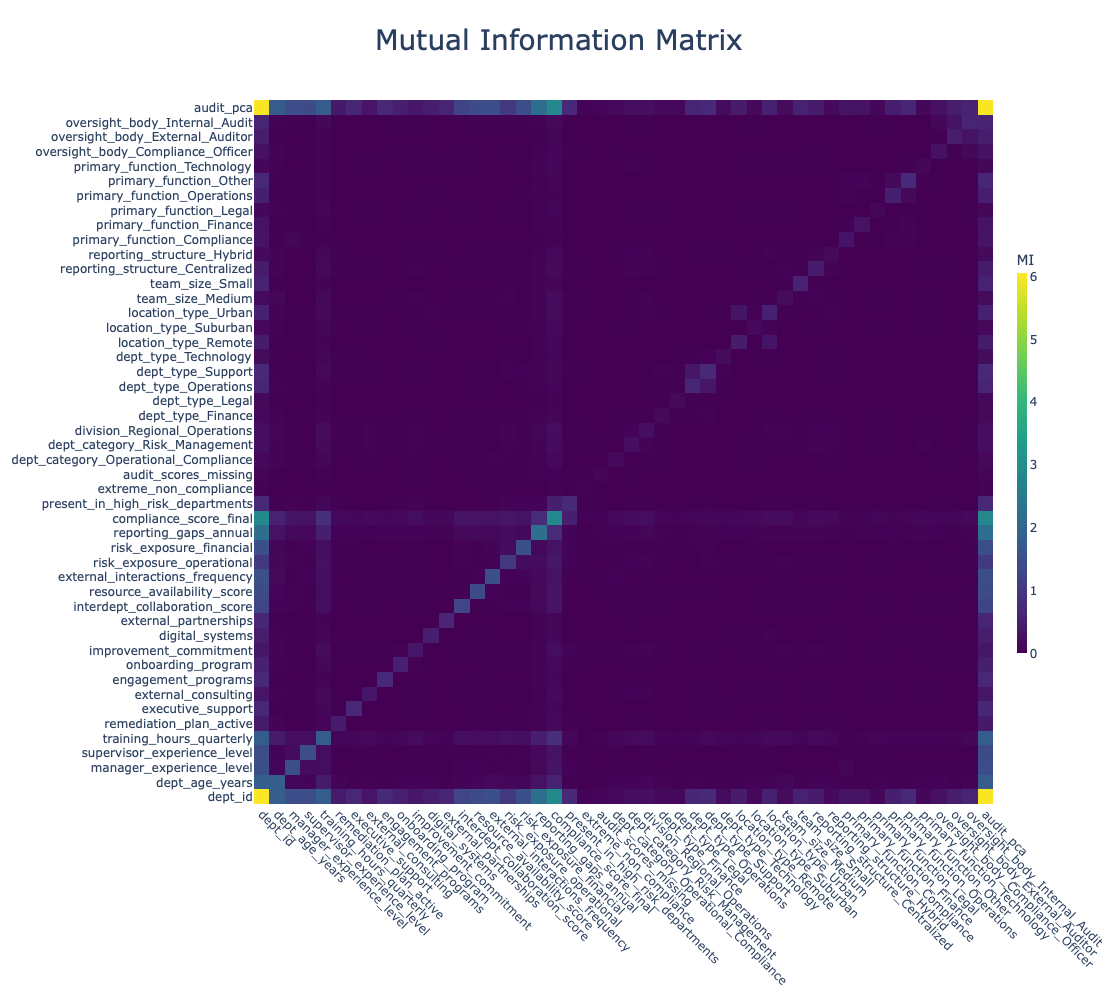

In [4636]:

# ----------------------------
# 1. Compute MI
# ----------------------------
cols = df.columns
mi_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

def compute_mi(x, y):
    return mutual_info_score(x, y)

# Convert all columns to categorical integer codes
dep_mi = df.copy()
for c in dep_mi.columns:
    dep_mi[c] = pd.factorize(dep_mi[c])[0]

for c1 in cols:
    for c2 in cols:
        mi_matrix.loc[c1, c2] = compute_mi(dep_mi[c1], dep_mi[c2])

# ----------------------------
# 2. Interactive Heatmap
# ----------------------------
fig = go.Figure(
    data=go.Heatmap(
        z=mi_matrix.values,
        x=cols,
        y=cols,
        colorscale="Viridis",
        colorbar=dict(
            title="MI",
            len=0.6,
            thickness=10
        ),
        hovertemplate="<b>%{y}</b> vs <b>%{x}</b><br>MI = %{z:.3f}<extra></extra>"
    )
)

fig.update_layout(
    title=dict(
        text="Mutual Information Matrix",
        x=0.5,
        xanchor="center",
        font=dict(size=28)
    ),
    width=1000,
    height=1000,
    xaxis=dict(tickangle=45)
)

fig.show()

In [ ]:
MAIIA
1. Split data into train and test
2. Three models to try

	1.	Linear Regression (baseline)
	2.	Random Forest Regressor (tree-based, non-linear)
	3.	Gradient Boosting (XGBoost or HistGradientBoosting)
3. compare them, evaluate, analyze
4. Hyperparameter optimization: possibly 5-folds cross-validation. list best parameters for each model.
5. compare models again. briefly explain which model we choose as the best and why

FILIPPA
1. look at multicolinearity again. there should be multicolinearity.
2. Look at the MI analysis section, it is very connected to multicolinearity. Do you think it makes sense? please double check after me MI and skeweness standardizing

EVELINA
1.Look at the MI analysis section, it is very connected to multicolinearity. Do you think it makes sense? please double check after me MI and skeweness standardizing
2.Start writing README. Think how we can deliver out project creatively, not like others. Consider adding mindmaps, nice graphs, etc. Think how we could stand out
    